In [ ]:
import os
import datetime
from google.colab import drive
drive.mount('/content/gdrive')

os.chdir('/content/gdrive/My Drive/Modeling/Images')

Mounted at /content/gdrive


In [1]:
#@title Importing & Initialization
import numpy as np
from scipy.io import loadmat,savemat
from scipy.interpolate import interp1d
from scipy.fft import fft, ifft
import scipy.integrate as integral
import time
import random
from scipy.io import savemat,loadmat
import matplotlib.pyplot as plt
import os
import math
import torch as T
from torch.fft import fft2,ifft2,ifftshift,fftshift
from numba import njit, prange
from tqdm import tqdm
import cv2
import warnings
from matplotlib import style
import statistics
warnings.filterwarnings('ignore')



In [2]:
#@title Device Selection
global device
device = T.device("cuda:0" if T.cuda.is_available() else "cpu")
print('Using ', device)

Using  cuda:0


In [3]:
#@title Initial Variables
scale = 1

lambda_ = 1.064e-3
#w0 = 2
Rc= 1e25
k=2*np.pi/lambda_
theta_g = 0.5
#zR=np.pi*w0**2/lambda_
Dx = Dy = scale* 64
z = scale* 3400
Np = scale* 6000

x = T.linspace(-Dx/2,Dx/2, Np)
y=x
X,Y = T.meshgrid(x,y,indexing='xy')

In [ ]:
#@title Analytical
dp = np.linspace(0,1,11)
ef0 =1
effm = []
efp = ef0*(1-(0.25*(dp)**2))
efw = ef0*(1- (dp)**2)
efpn = ef0*(1-2*np.log(2)*((dp))**2)
eflp = ef0*(1- (dp)**2)
plt.plot(dp,efp)
effm.append(eflp)
print(effm)
plt.plot(dp,efw)
plt.plot(dp,efpn)

In [4]:
#@title Functions
#Cart to polar coordinates
def cart2pol(x,y):
    # print("cart2pol")
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y,x)
    return phi, rho

#function to generate beams
def beam_generation1D(Rc,w0,dp,ax,aza,dthp,dthaz,a,b):


    s = time.time()
    scale = 1

    lambda_ = 1.064e-3
    #w0 = 2
    #Rc= 1e25
    k=2*np.pi/lambda_
    #theta_g = 0.5
    #zR=np.pi*w0**2/lambda_
    Dx = Dy = scale* 64
    z=scale* 3400
    Np = scale* 6000

    #w0 = 2
    x = T.linspace(-Dx/2,Dx/2,Np).to(device)
    y=x
    X,Y = T.meshgrid(x,y, indexing='xy')
    zR=np.pi*w0**2/lambda_
    #ax= pa + dthp

    axr = ax*np.pi/180
    #ax11 = np.arctan(np.sqrt(2)*np.tan(ax1))
    ax1 = ax + dthp
    axr1 = ax1*np.pi/180


    by = aza + dthaz
    byr1 = by*np.pi/180
    ds1= np.tan(axr)*z
    ds2= np.tan(axr1)*z
    Pa= T.exp(1j*k*X*np.sin(axr1)*np.cos(byr1) + 1j*k*Y*np.sin(axr1)*np.sin(byr1))#.to(device)
    #print(Pa)
    R=T.sqrt((X-(ds1*a))**2+(Y-(ds1*b))**2)#.to(device)

    P= dp
    A=(2*P)/(np.pi*(w0**2))
    C1=np.sqrt(A)*T.exp(1j*k*(R**2)/(2*Rc))#.to(device)
    e1 = T.exp(-(R**2)/(w0**2))
    Psi=C1*e1 *Pa#.to(device) #*np.exp(1j*np.pi)

    Ap = T.ones(X.shape).to(device)
    r=3
    Ap[R>r]=0
    uout = Psi * Ap

    #plt.imshow(np.real(A))
    e = time.time()-s
    return uout

def beam_generation2D(Rc,w0,dp,ax,aza,dthp,dthaz,a,b, axd):


    s = time.time()
    scale = 1

    lambda_ = 1.064e-3
    #w0 = 2
    #Rc= 1e25
    k=2*np.pi/lambda_
    #theta_g = 0.5
    #zR=np.pi*w0**2/lambda_
    Dx = Dy = scale* 64
    z=scale* 3400
    Np = scale* 6000

    #w0 = 2
    x = T.linspace(-Dx/2,Dx/2,Np).to(device)
    y=x
    X,Y = T.meshgrid(x,y, indexing='xy')
    zR=np.pi*w0**2/lambda_
    #ax= pa + dthp

    axr = ax*np.pi/180
    #ax11 = np.arctan(np.sqrt(2)*np.tan(ax1))
    ax1 = axd + dthp #0.70708883252643 + dthp
    axr1 = ax1*np.pi/180


    by = aza + dthaz
    byr1 = by*np.pi/180

    ds1= np.tan(axr)*z
    ds2= np.tan(axr1)*z
    Pa= T.exp(1j*k*X*np.sin(axr1)*np.cos(byr1) + 1j*k*Y*np.sin(axr1)*np.sin(byr1))#.to(device)
    #print(Pa)
    R=T.sqrt((X-(ds1*a))**2+(Y-(ds1*b))**2)#.to(device)

    P= dp
    A=(2*P)/(np.pi*(w0**2))
    C1=np.sqrt(A)*T.exp(1j*k*(R**2)/(2*Rc))#.to(device)
    e1 = T.exp(-(R**2)/(w0**2))
    Psi=C1*e1 *Pa#.to(device) #*np.exp(1j*np.pi)

    Ap = T.ones(X.shape).to(device)
    r=3
    Ap[R>r]=0
    uout = Psi * Ap

    #plt.imshow(np.real(A))
    e = time.time()-s
    return uout
def rectangularPulse(start,stop,x):
    s = time.time()
    pulse = []
    for i in x:
        if start<i and stop>i:
            val = 1
        elif i==stop or i==start:
            val = 0.5
        else:
            val = 0
        pulse.append(val)
    pulse = np.array(pulse)
    e = time.time() - s
    # print('rectangularPulse: ',str(e),'s')
    return pulse

@njit(parallel=True,fastmath=True)
def get_gamma(len_alpha,len_beta,alpha,beta):
    gamma = np.zeros((len_alpha,len_beta))
    for j in prange(len_beta):
        for i in prange(len_alpha):
            if alpha[i]**2 + beta[j]**2 > 1:
                gamma[j,i] = 0
            else:
                gamma[j,i] = np.sqrt(1-alpha[i]**2-beta[j]**2)
    return gamma


def rs_propagation(uin,z):
    start = time.time()
    layer = uin
    scale = 1
    lambda_ = 1.064e-3
    Dx = Dy = scale* 64
    phy_x= Dx
    phy_y= Dy

    obj_size = layer.shape
    r,c = layer.shape[0], layer.shape[1]
    Fs_x = obj_size[1]/phy_x
    Fs_y = obj_size[0]/phy_y

    dFx=Fs_x/obj_size[1]
    dFy=Fs_y/obj_size[0]
    Fx=np.arange(-Fs_x/2,Fs_x/2,dFx)
    Fy=np.arange(-Fs_y/2,Fs_y/2,dFy)
    alpha=lambda_*Fx
    beta=lambda_*Fy
    len_alpha=len(list(alpha))
    len_beta=len(list(beta))
    gamma=get_gamma(len_alpha,len_beta,alpha,beta)


    #def rectangularPulse(start,stop,x):
    H0 = T.tensor(np.exp(1j*k*gamma*z)).to(device)
    Fxlim = 1/(np.sqrt(1+(2*dFx*z)**2)*lambda_)
    Fylim = 1/(np.sqrt(1+(2*dFy*z)**2)*lambda_)

    FxBL = T.tensor(np.zeros((len(list(beta)),len(list(alpha))))).to(device)
    FyBL = T.tensor(np.zeros((len(list(beta)), len(list(beta))))).to(device)
    FxBLr = T.tensor(rectangularPulse(-Fxlim,Fxlim,Fx)).to(device)
    FyBLc = T.tensor(rectangularPulse(-Fxlim,Fylim,Fy)).to(device)

    for i in range(c):
        FxBL[i,0:r]=FxBLr
    for j in range(r):
        FyBL[0:c,j]=FyBLc

    H1=H0*FxBL*FyBL
    #uout=np.fft.ifft2(np.fft.ifftshift((np.fft.fftshift(np.fft.fft2(uin)))*H1))
    uout = ifft2(ifftshift((fftshift(fft2(layer)))*H1))
    end = time.time()-start
    return uout

#grating function
def grating(theta_g):
    theta_gr = theta_g*(np.pi/180)
    Ax=np.ones((1,Np),dtype=complex) #Define a Matrix by assigning 1 to all pixels
    Period = lambda_/np.sin(theta_gr) #0.24 #Define the period of the grating
    Px = Period*Np/Dx
    FF=0.5 #Define fill factor
    # Constructing the Grating

    for q in range (Np): #Scan pixel by pixel
        if q%Px<Px*FF: #Use remainder function ‘rem’ to construct the grating
            Ax[0,q]=  2#np.exp(1j*(np.pi))

    Ax=np.tile(Ax,(Np,1)) #replicate the row to create a 2D grating
    #Ay = [[Ax[j][i] for j in range(len(Ax))] for i in range(len(Ax[0])-1,-1,-1)]
    #Ay = np.rot90(Ax)
    A = Ax + np.rot90(Ax) #* np.exp(1j*(np.pi))
    A[A==2] = 1
    A[A==4] = 1
    A[A==3] = np.exp(1j*(np.pi))
    return A

def grating_1D(theta_g):
    theta_gr = theta_g*(np.pi/180)
    A=np.ones((1,Np),dtype=complex) #Define a Matrix by assigning 1 to all pixels
    Period = lambda_/np.sin(theta_gr) #0.24 #Define the period of the grating
    Px = Period*Np/Dx
    FF=0.5 #Define fill factor
    # Constructing the Grating

    for q in range (Np): #Scan pixel by pixel
        if q%Px<Px*FF: #Use remainder function ‘rem’ to construct the grating
            A[0,q]=np.exp(1j*(np.pi))
    #A=np.tile(A,(Np,1))
    grating =T.tensor(np.tile(A,(Np,1))).to(device)
    #A1=A.cpu().detach().numpy() #replicate the row to create a 2D grating
    #plt.imshow(np.real(A1))

    return grating


def grating_2D(theta_g):
    start = time.time()
    #Np = 4096
    lambda_ = 1.064e-3
    #Dx = 50
    FF=0.5
    #theta_g = 0.5
    theta_gr = theta_g*(np.pi/180)
    #Define a Matrix by assigning 1 to all pixels
    Period = lambda_/np.sin(theta_gr)  # Number of columns
    # Checkerboard period (alternating squares)
    Px = Period*Np/Dx
    # Create a 2D grid of indices using NumPy meshgrid
    x, y = np.meshgrid(np.arange(Np), np.arange(Np))

    # Create a binary checkerboard pattern using the modulus operator
    A = np.mod(np.floor(x/(Px*FF)) + np.floor(y/(Px*FF)), 2)
    g = np.array(A, dtype=complex)
    g[g==1] = 1
    g[g==0] = np.exp(1j*(np.pi))

    grating = T.tensor(g).to(device)
    return grating




def create_multi_level_grating(n_level=4,num_pixel=4096):
    n_val = np.linspace(0,np.pi,n_level)
    flipped = np.flip(n_val[1:-1])
    Dx = 50
    theta_g = 0.5
    theta_gr = theta_g*(np.pi/180)
    Period = lambda_/np.sin(theta_gr) #0.24 #Define the period of the grating
    Px = Period*Np/Dx
    for i in flipped:
        n_val = np.append(n_val,i)
    n_val
    width=Px//len(n_val)
    c=0
    l=[]
    for i in range(num_pixel):
        l.append(n_val[c])
        if i%width ==0 and i !=0:
            if c ==len(n_val)-1:
                c=0
            else:
                c+=1
    l_2d = np.tile(l,num_pixel)
    grating = (l_2d.reshape(num_pixel,num_pixel)+l_2d.reshape(num_pixel,num_pixel).T)/2
    return grating,l
#PUB
def PIB(iout,Roc, xp, yp):

    sx,sy=iout.shape
    x=np.linspace(-Dx/2,Dx/2,Np)
    X,Y=np.meshgrid(x,x)
    R=np.sqrt((X+xp)**2+(Y+yp)**2)
    PIBCirc=np.ones((sx,sy))
    PIBCirc[R>Roc]=0
    iCirc= PIBCirc* iout
    PIBc=np.sum(iCirc)
    #e = time.time()-s
    return PIBc

#Transverse phase abberation
def TPA(rh,th,TPstd):
    s = time.time()
    ax= 0.5

    axr = ax*np.pi/180
    ds1= np.tan(axr)*z
    R = 5
    rho = T.tensor(rh/R).to(device)
    th = T.tensor(th).to(device)
    #abr = T.tensor(abr).to(device)
    ZP1 = 2*rho*T.sin(th)
    ZP2 = 2*rho*T.cos(th)

    ZP3 = np.sqrt(3)*(2*(rho**2)-1)

    ZP4 = np.sqrt(6)*(rho**2*T.sin(2*th))
    ZP5 = np.sqrt(6)*(rho**2*T.cos(2*th))

    ZP6 = np.sqrt(8)*((3*rho**3 - 2*rho)*T.sin(th))
    ZP7 = np.sqrt(8)*((3*rho**3 - 2*rho)*T.cos(th))

    ZP8 = np.sqrt(8)*(rho**3*T.sin(3*th))
    ZP9 = np.sqrt(8)*(rho**3*T.cos(3*th))

    ZP10 = np.sqrt(5)*(6*(rho**4)-6*(rho**2)+1)


    abr = np.random.normal(0, TPstd, 10)
    #abr = T.tensor(abr).to(device)
    ZPt = abr[0]*ZP1 + abr[1]*ZP2 + abr[2]*ZP3 + abr[3]*ZP4 + abr[4]*ZP5 + abr[5]*ZP6 + abr[6]*ZP7 + abr[7]*ZP8 + abr[8]*ZP9 + abr[9]*ZP10
    ZPt[rho>1] = 0
    AbPh = T.exp(1j*2*np.pi*ZPt)
    #AbPh = T.AbPh.to(device)
    e = time.time()-s
    #print('Transverse_ph_abbrZP:',str(e),'s')
    return AbPh

def plot_savefig(icpu,i):
    plt.rcParams.update({'font.size': 10})
    #print("Eff=",eff)
    #print(np.max(iout1cpu))

    plt.figure(figsize=(5,4))
    plt.imshow(icpu, extent=[0,50,0,50], cmap= 'hot')
    plt.xlabel("Millimeters")
    plt.ylabel("Millimeters")
    #plt.xlim(1000,4000)
    #plt.ylim(1000,4000)
    plt.colorbar()
    plt.savefig('./files2/icpu_'+str(i+17)+'.png')
    plt.clf()
    plt.close()

def grating4(grating_size, stack_factor):
  # Parameters
    # grating_size = 64
    # stack_factor = 64
    total_size = 6000
    transition_point_1 = 0.25 #0.22057
    transition_point_2 = 0.45 #0.44563
    transition_point_3 = 0.55 #0.55437
    transition_point_4 = 0.75 #0.77943  # New transition point

    # Generate the binary phase grating
    single_grating = np.ones(grating_size, dtype=complex)
    transition_point_1_index = int(transition_point_1 * grating_size)
    transition_point_2_index = int(transition_point_2 * grating_size)
    transition_point_3_index = int(transition_point_3 * grating_size)  # Index for the new transition point
    transition_point_4_index = int(transition_point_4 * grating_size)

    single_grating[:transition_point_1_index] = np.exp(1j*np.pi)
    single_grating[transition_point_1_index:transition_point_2_index] = 1
    single_grating[transition_point_2_index:transition_point_3_index] = np.exp(1j*np.pi)
    single_grating[transition_point_3_index:transition_point_4_index] = 1  # Transition at 0.5
    single_grating[transition_point_4_index:] = np.exp(1j*np.pi)

    # Stack the grating
    stacked_grating = np.tile(single_grating, stack_factor)

    # Tile the stacked grating in the orthogonal direction
    g_2d = np.tile(stacked_grating, (6000, 1))
    g4 = T.tensor(g_2d).to(device)
    return g4

def grating4x4(grating_size, stack_factor):
    # Parameters
    # grating_size: Size of the grating in one dimension (e.g., 64)
    # stack_factor: Factor to stack the grating in one direction (e.g., 120)

    #total_size = 1000
    transition_point_1 = 0.25
    transition_point_2 = 0.45
    transition_point_3 = 0.55
    transition_point_4 = 0.75

    # Generate the binary phase grating in one orientation
    single_grating = np.ones((grating_size), dtype=complex)

    transition_point_1_index = int(transition_point_1 * grating_size)
    transition_point_2_index = int(transition_point_2 * grating_size)
    transition_point_3_index = int(transition_point_3 * grating_size)
    transition_point_4_index = int(transition_point_4 * grating_size)

    single_grating[:transition_point_1_index] = 2
    single_grating[transition_point_1_index:transition_point_2_index] = 1
    single_grating[transition_point_2_index:transition_point_3_index] = 2
    single_grating[transition_point_3_index:transition_point_4_index] = 1  # Transition at 0.5
    single_grating[transition_point_4_index:] = 2

    X_stack = np.tile(single_grating, stack_factor)
    Y_stack = np.tile(X_stack, (6000, 1))
    # Generate the rotated version of the grating (90 degrees rotation)
    rotated_grating = np.rot90(Y_stack)

    # Add the original and rotated gratings together
    A = Y_stack + rotated_grating #np.rot90(Y_stack)
    A[A==2] = 1
    A[A==4] = 1
    A[A==3] = np.exp(1j*(np.pi))
    # # Scale the phases from 0 to pi
    # combined_grating = np.pi * (combined_grating - np.min(combined_grating)) / (np.max(combined_grating) - np.min(combined_grating))

    # # Stack the grating
    # stacked_grating = np.tile(combined_grating, (stack_factor, stack_factor))
    g16 = T.tensor(A).to(device)
    return g16

def multigrating(grating_size, stack_factor):

    # grating_size = 64
    # stack_factor = 64
    n = grating_size
    total_size = 6000

    transition_point_1 = 0.5 #0.1255#5/n #0.22057
    transition_point_2 = 1 #2*0.125#15/n #0.44563
    transition_point_3 = 3*0.125#25/n #0.55437
    transition_point_4 = 4*0.125#35/n
    transition_point_5 = 5*0.125 #45/n #0.55437
    transition_point_6 = 6*0.125
    transition_point_7 = 7*0.125
    transition_point_8 = 8*0.125 #0.77943  # New transition point

    # Generate the binary phase grating
    single_grating = np.ones(grating_size, dtype=complex)
    transition_point_1_index = int(transition_point_1 * grating_size)
    transition_point_2_index = int(transition_point_2 * grating_size)
    transition_point_3_index = int(transition_point_3 * grating_size)  # Index for the new transition point
    transition_point_4_index = int(transition_point_4 * grating_size)
    transition_point_5_index = int(transition_point_5 * grating_size)  # Index for the new transition point
    transition_point_6_index = int(transition_point_6 * grating_size)
    transition_point_7_index = int(transition_point_7 * grating_size)  # Index for the new transition point
    transition_point_8_index = int(transition_point_8 * grating_size)

    single_grating[:transition_point_1_index] = 1
    single_grating[transition_point_1_index:transition_point_2_index] = np.exp(1j*np.pi)
    # single_grating[transition_point_2_index:transition_point_3_index] = np.exp(1j*4*np.pi/4)
    # single_grating[transition_point_3_index:transition_point_4_index] = np.exp(1j*6*np.pi/4)
    # single_grating[transition_point_4_index:transition_point_5_index] = np.exp(1j*8*np.pi/4)
    # single_grating[transition_point_5_index:transition_point_6_index] = np.exp(1j*6*np.pi/4)
    # single_grating[transition_point_6_index:transition_point_7_index] = np.exp(1j*4*np.pi/4)
    # single_grating[transition_point_7_index:transition_point_8_index] = np.exp(1j*2*np.pi/4)
    # single_grating[transition_point_8_index:transition_point_9_index] = np.exp(1j*np.pi/2)
    single_grating[transition_point_2_index:] = 1

    # Stack the grating
    stacked_grating = np.tile(single_grating, stack_factor)

    # Tile the stacked grating in the orthogonal direction
    g_2d = np.tile(stacked_grating, (6000, 1))

    gm = T.tensor(g_2d).to(device)
    return gm

def multilevel2D(gm):
    gm[gm==np.exp(1j*np.pi)] = 2
    gm[gm==1] = 1

    A = gm + np.rot90(gm)
    A[A==-1] = 1
    A[A==2] = 1
    A[A==4] = 1
    A[A==3] = np.exp(1j*(np.pi))
    # # Scale the phases from 0 to pi
    # combined_grating = np.pi * (combined_grating - np.min(combined_grating)) / (np.max(combined_grating) - np.min(combined_grating))

    # # Stack the grating
    # stacked_grating = np.tile(combined_grating, (stack_factor, stack_factor))
    gm2 = T.tensor(A).to(device)
    return gm2

def sinu_grating(grating_size, stack_factor, phs1, a, periods=1):
    # Parameters
    # grating_size: Size of the grating (e.g., 64)
    # stack_factor: Factor to stack the grating in one direction (e.g., 120)
    # periods: Number of periods in the grating (e.g., 1)

    # Generate the sinusoidal phase grating
    x = np.arange(grating_size) / grating_size
    phase_profile = a*np.sin(2*phs1 * periods * x)**2 * phs1

    # Stack the grating
    stacked_grating = np.tile(np.exp(1j * phase_profile), stack_factor)

    # Tile the stacked grating in the orthogonal direction
    g_2d = np.tile(stacked_grating, (grating_size * stack_factor, 1))
    #g_2d2 = (g_2d)**2
    #g_2d[np.angle(g_2d)<0] = 1

    gs = T.tensor(g_2d).to(device)
    #gs2 = T.tensor(g_2d2).to(device)
    return gs


def Tgrating(grating_size, stack_factor, maxp, periods=1):
    # Parameters
    # grating_size: Size of the grating (e.g., 64)
    # stack_factor: Factor to stack the grating in one direction (e.g., 120)
    # periods: Number of periods in the grating (e.g., 1)

    # Generate the symmetric triangular phase grating
    x = np.arange(grating_size) / grating_size
    phase_profile = (x * 2*maxp * np.pi * periods) % (2*maxp * np.pi)  # Ensure phase remains within one period

    # Make the phase increase linearly from 0 to 2π and then decrease linearly back to 0 within one period
    phase_profile[phase_profile > maxp*np.pi] = 2*maxp * np.pi - phase_profile[phase_profile > maxp*np.pi]

    # Stack the grating
    stacked_grating = np.tile(np.exp(1j * phase_profile), stack_factor)

    # Tile the stacked grating in the orthogonal direction
    g_2d = np.tile(stacked_grating, (grating_size * stack_factor, 1))
    gt = T.tensor(g_2d).to(device)
    # Plot the phase profile as an image
    # plt.figure(figsize=(10, 5))
    # plt.subplot(1, 2, 1)
    # plt.imshow(np.angle(g_2d), cmap='gray', extent=[0, grating_size * stack_factor, 0, grating_size * stack_factor])
    # plt.colorbar()
    # plt.title("Phase Profile (Image)")
    # plt.xlabel("X-axis")
    # plt.ylabel("Y-axis")

    # # Plot the linear phase change within one period
    # plt.subplot(1, 2, 2)
    # plt.plot(x, phase_profile, 'b-')
    # plt.title("Linear Phase Change within One Period")
    # plt.xlabel("X-axis")
    # plt.ylabel("Phase (radians)")
    # plt.grid()

    # plt.tight_layout()
    # plt.show()

    return gt

In [ ]:
#@title Polarization as Power Change
#Two beam DOE CBC with polarization state as power exchange

ax = 0.5
n = 1
m = 1
print ("Estimated simulation time =", 0.06*m*n,"minutes")
axr = ax*np.pi/180
ds1= np.tan(axr)*z

w01, w02 = 2, 2 #6.2/3,5.8/3,6/3,5.6/3
#dp11, dp12= 0, 0
#dp12 = 0.1
#dpi = 0.5
#theta = 45
# thetar = theta * np.pi/180
# dp = np.sin(thetar)**2

dthaz = 0
pvareff = []
pvareff2 = []
#dp11 = 0
#w01=0.5
dr = 0#-2.5
Rc1 = 1e25 #0.5*1e4
Rc2 = 1e25
dpi = 0

for j in range(m):
    #print("Iteration (m)=",j,"dpi =",dpi)
    #w02 = 1.5
    theta = 0
    #dp12 = 1-dp11
    abc = []
    abc2 = []
#t = np.linspace(1,n,1)
    for i in tqdm(range(n),ncols=120):
        #abr = np.random.uniform(-0.1, 0.1, 2)
        #print(Rc2)
        #dp11, dp12 = 0, 0 #dpi, dpi + dp
        #dp11, dp12= dp + abr[0], dp + abr[1]

        thetar = theta * np.pi/180
        dp = np.sin(thetar)**2
        dp11, dp12 = dpi, 0.5#dpi+dp #
        dp21, dp22 = 1- dp11, 1- dp12
        #dp12 = 1-dp11
        #print(dp11, dp12)
        ux1 = beam_generation1D(Rc1,w01,dp11,0.5,dr,0,dthaz,-1,0)
        ux2 = beam_generation1D(Rc2,w02,dp12,0.5,180+dr,0,dthaz,1,0)
        uy1 = beam_generation1D(Rc1,w01,dp21,0.5,0,0,dthaz,-1,0) * np.exp(1j*np.pi/2)
        uy2 = beam_generation1D(Rc2,w02,dp22,0.5,180+dr,0,dthaz,1,0) * np.exp(1j*np.pi/2)
        #TPA1 = TPA(rh1,th1)
        #TPA2 = TPA(rh2,th2)
        uinx = ux1 + (ux2 * np.exp(1j*np.pi))
        uiny = uy1 + (uy2 * np.exp(1j*np.pi))
        uin2 = uinx + uiny
        uoutx1 = rs_propagation(ux1,600)
        uoutx2 = rs_propagation(ux2,600)
        iin2 = T.abs(uin2)**2
        iin2cpu = iin2.cpu().detach().numpy()
        Pin2 = np.sum(iin2cpu)
        #uout1 = rs_propagation(uin2,600)
        g = grating_1D(0.5)
        #uout1g = uout1 * g
        uoutx1g = uoutx1 * g
        uoutx2g = uoutx2 * g
        uout2x1 = rs_propagation(uoutx1g,600)
        uout2x2 = rs_propagation(uoutx2g,600)
        ioutx1 = T.abs(uout2x1)**2
        ioutx2 = T.abs(uout2x2)**2
        ioutinc = ioutx1 + ioutx2
        ioutincpu = ioutinc.cpu().detach().numpy()
        #uout2 = rs_propagation(uout1g,600)
        #iout2 = T.abs(uout2)**2
        #iout2cpu = iout2.cpu().detach().numpy()
        #Pout2 = np.sum(iout2cpu)
        #PIBc2 = PIB(iout2cpu,5)
        #eff2 = 100* (PIBc2/Pin2)
        #uinx = (ux1 * TPA1) + (ux2 * TPA2 * np.exp(1j*np.pi))
        iin = T.abs(uinx)**2 + T.abs(uiny)**2
        iicpu = iin.cpu().detach().numpy()
        uoutx = rs_propagation(uinx,600)
        uouty = rs_propagation(uiny,600)
        iin2 = T.abs(uoutx)**2  + T.abs(uouty)**2
        ii2cpu = iin2.cpu().detach().numpy()

        uin2x = uoutx * g
        uin2y = uouty * g
        uout2x = rs_propagation(uin2x,600)
        #ang = T.angle(uout2x)
        #angcpu = ang.cpu().detach().numpy()
        uout2y = rs_propagation(uin2y,600)
        iout2x = T.abs(uout2x)**2
        iout2y = T.abs(uout2y)**2
        iout = iout2x +iout2y
        iocpu = iout.cpu().detach().numpy()
        PIBc = PIB(iocpu,5)
        PIBin = PIB(ioutincpu,5)
        effin = 100*(PIBin/Pin2)
        Pin = np.sum(iicpu)
        Pout = np.sum(iocpu)
        eff = 100*(PIBc/Pin)
        abc.append(eff)
        #abc2.append(eff2)
        theta = theta + 2.5
        #print("Iteration (n)=",i, "Eff=", eff)
        #dp12 = dp12 + 0.0499999999
        #w02 = w02 + 0.0499999999
        #dr = dr + 0.1
        #Rc2 = Rc2/2

    #print("Iteration (m)=",j)
    pvareff.append(abc)
    #pvareff2.append(abc2)
    dpi = dpi + 0.5
    #dp11 = dp11 + 0.0499999999
    #w01 = w01 + 0.0499999999
#print(statistics.mean(pvareff[0]),statistics.mean(pvareff[1]),statistics.mean(pvareff[2]),statistics.mean(pvareff[3]),statistics.mean(pvareff[4]),statistics.mean(pvareff[5]),statistics.mean(pvareff[6],statistics.mean(pvareff[7]),statistics.mean(pvareff[8]))
#print(statistics.stdev(pvareff[0]),statistics.stdev(pvareff[1]),statistics.stdev(pvareff[2]),statistics.stdev(pvareff[3]),statistics.stdev(pvareff[4]),statistics.stdev(pvareff[5]),statistics.stdev(pvareff[6]),statistics.stdev(pvareff[7]),statistics.stdev(pvareff[8]))
effwthpol = np.array(pvareff)
# plt.plot(effwthpol)
# plt.xlabel("Time/Iterations")
# plt.ylabel("Efficiency (%)")

In [ ]:
#@title Plotting
print("Eff=",eff,effin)
plt.figure(figsize=(10,8))
plt.imshow(iicpu)
plt.xlim(1000,5000)
plt.ylim(1000,5000)
plt.colorbar()
plt.show()
plt.figure(figsize=(10,8))
plt.imshow(iocpu)
plt.xlim(1000,5000)
plt.ylim(1000,5000)
plt.colorbar()
plt.show()
plt.figure(figsize=(10,8))
plt.imshow(ioutincpu)
plt.xlim(1000,5000)
plt.ylim(1000,5000)
plt.colorbar()


In [ ]:
#@title Two beam combining
#Polarization as phase change
ax = 0.5
n = 1
m = 1
l = 1
print ("Estimated simulation time =", 0.25*m*n,"minutes")
axr = ax*np.pi/180
ds1= np.tan(axr)*z
k = 2*np.pi/lambda_
#w01, w02 = 1, 1
rh1 = T.sqrt((X+(ds1))**2+(Y-(ds1*0))**2)
th1 = T.arctan2(Y-(ds1*0),X+(ds1))
rh2 = T.sqrt((X-(ds1))**2+(Y-(ds1*0))**2)
th2 = T.arctan2(Y-(ds1*0),X-(ds1))
TPstd = 0.0
dthp = 0.00
dthaz = 0
effct = []
imm = []

azh = 0
Rc1 = 1e25
Rc2 = 1e25
dpi = 1
pd = 0.0
#dp1 = 0
#dp11 = 1
#dp1 = 0
w01 = 2
#delta1 = 0#np.pi/4
dph = 0 #np.pi/20
dpol = 0
for j in range (m):
  effm = []
  im = []

  #dp2 = 0
  w02 = 2
  #dp12 = 1
  #delta2 = 0

  print("Updated variable = ", dph)
  for idx in tqdm(range(n),ncols=120):

    dlph = np.random.normal(0, dph, 2)
    pold = np.random.normal(0,dpol,2)
    poldp = np.clip(pold,-dpol/2,dpol/2)
    dpm = np.clip(dlph, -0.99, 1.5 )
    dp11 = dpi + dpm[0]
    dp12 = 0#dpi +dpm[1]
    dp1 = 1#dpi + poldp[0]
    dp2 = 1#dpi + poldp[1]
    #print (dpi,poldp,dp1,dp2)
    pth1 = np.arccos(np.sqrt(dp1))
    pth2 = np.arccos(np.sqrt(dp2))
    #dp11 = 1-dp12
    #dp12 = 0 #- dp11
    #dp21, dp22 = 1- dp11, 1- dp12
    #pth1 = 45
    #pth2 = 45
    pdm = np.random.normal(0, pd, 2)
    TPA1 = 1 #TPA(rh1,th1,TPstd)
    TPA2 = 1 #TPA(rh2,th2,TPstd)
    u1 = beam_generation1D(Rc1,w01,dp11,ax,azh,dthp,dthaz,-1,0) * TPA1 * np.exp(1j*pdm[0])

    #ux2 = beam_generation(Rc2,w02,dp12,0.5,180+dr,0,dthaz,1,0)
    # ux1 = np.sqrt(dp1) * u1 # * np.exp(1j*np.pi)
    # uy1 = np.sqrt(1-dp1) * u1 * np.exp(1j*dlph[0])
    ux1 = np.cos(pth1) * u1  #* np.exp(1j*np.pi*0)
    uy1 = np.sin(pth1) * u1 * np.exp(1j*dlph[0])
    i1 = T.abs(u1)**2

    ix1 = T.abs(ux1)**2
    iy1 = T.abs(uy1)**2
    u2 = beam_generation1D(Rc2,w02,dp12,ax,180+azh,dthp,dthaz,1,0) * TPA2 * np.exp(1j*pdm[1])
    # ux2 = np.sqrt(dp2) * u2 #np.cos(pthr) * u1
    # uy2 = np.sqrt(1-dp2) * u2 * np.exp(1j*dlph[1])
    ux2 = np.cos(pth2) * u2 #* np.exp(1j*np.pi)
    uy2 = np.sin(pth2) * u2 * np.exp(1j*dlph[1])

    Tph = T.angle(u1 + u2)
    Tphcpu =Tph.cpu().detach().numpy()
    #uin = ux1 + ux2 + uy1 + uy2
    i = T.abs(u1)**2 + T.abs(u2)**2
    ix = T.abs(ux1+ux2)**2
    iy = T.abs(uy1+uy2)**2
    icpu = i.cpu().detach().numpy()
    ixcpu = ix.cpu().detach().numpy()
    iycpu = iy.cpu().detach().numpy()
    g = grating_1D(0.5)
    #uin1 = ux1+(ux2*np.exp(1j*np.pi)) + uy1+(uy2 * np.exp(1j*np.pi))
    #uout1 = rs_propagation(uin1,600)
    #uoutg = uout1 * g
    #uout2 = rs_propagation(uoutg,600)
    #ioutb = T.abs(uout2)**2
    #ioutbcpu = ioutb.cpu().detach().numpy()
    uout1x = rs_propagation((ux1)+(ux2*np.exp(1j*np.pi)),600)
    #uout1x = rs_propagation((ux1+ux2),600)

    g4 = grating4(50,120)
    gm = multigrating(60,100)
    gs = sinu_grating(60, 100, periods=1)
    g16 = grating4x4(50,120)
    #gt = Tgrating(50,120)

    uout1xg = uout1x * g16
    uout1y = rs_propagation(uy1+(uy2 * np.exp(-1j*np.pi)),600)
    #uout1y = rs_propagation((uy1+uy2),600)
    iout1 = T.abs(uout1x)**2 + T.abs(uout1y)**2
    iout1cpu = iout1.cpu().detach().numpy()

    #imax = np.max(iout1cpu)
    #im.append(imax)
    uout1yg = uout1y * g16
    uout2x = rs_propagation(uout1xg,6000)
    uout2y = rs_propagation(uout1yg,6000)

    iout = T.abs(uout2x)**2 + T.abs(uout2y)**2
    ioutcpu = iout.cpu().detach().numpy()

    #plot_savefig(ioutcpu,idx)



    #imax = np.max(ioutcpu)
    #im.append(imax)
    ps = 1
    RoC = 5
    PIBc = PIB(ioutcpu,RoC,0,0)


    Pin = np.sum(icpu)
    #print(Pin,Pout)
    Pout = np.sum(ioutcpu)
    eff = 100*(PIBc/Pin)

    effm.append(eff)

    #dthp = dthp + 0.0005
    #dthaz = dthaz + 0.1
    #w02 = w02 + 2/10
    #TPstd = TPstd + 0.005
    #delta2 = delta2 + np.pi/11
    #dp2 = dp2 + 0.04999999999
    #dr = dr + 0.1
    #dp12 = dp12 + 0.05
    #w02 = w02 + 0.025
    #Rc2 = Rc2-100
    #pd = pd + np.pi/20

  print(effm)
  effct.append(effm)
  #imm.append(im)
  #pd = pd + 0.1
  #TPstd = TPstd + 0.01

  #print(dpi)
  #dpi = dpi+ 0.0499999999
  #w01 = w01 + 0.1
  #dph = dph + 0.1
  #Pstd = TPstd + 2/15
  #imm.append(im)
  #delta1 = delta1 + np.pi/11
  #dpi = dpi + 0.09999999999
print(effct)

Estimated simulation time = 0.25 minutes
Updated variable =  0


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:26<00:00, 26.42s/it]

[0.11355914618243147]
[[0.11355914618243147]]


In [ ]:
#@title Grating Profile
plt.rcParams.update({'font.size': 15})
# print("Eff=",eff)
# g = grating_1D(0.5)
g2 = grating_2D(0.1137488)
g4 = grating4(60,100)
gm = multigrating(60,100)
gm2 = multilevel2D(gm.cpu().detach().numpy())
gs = sinu_grating(120,50,np.pi,1/2,periods=1)
g16 = grating4x4(60,100)
gt = Tgrating(50,120,2,1)
#gcpu =g.cpu().detach().numpy()
# gcpu =g.cpu().detach().numpy()
g2cpu = g2.cpu().detach().numpy()
g4cpu =g4.cpu().detach().numpy()
gmcpu = gm.cpu().detach().numpy()
gm2cpu = gm2.cpu().detach().numpy()
gscpu = gs.cpu().detach().numpy()
g16cpu = g16.cpu().detach().numpy()
gtcpu = gt.cpu().detach().numpy()
plt.imshow(np.angle(gmcpu), cmap='gray')
plt.xlim(0,300)
plt.ylim(0,300)
plt.xlabel("x (pixels)")
plt.ylabel("y (pixels)")
plt.colorbar()
plt.show()
plt.imshow(np.angle(gscpu), cmap='gray')
plt.xlim(0,300)
plt.ylim(0,300)
plt.xlabel("x (pixels)")
plt.ylabel("y (pixels)")
plt.colorbar()
plt.show()
# plt.imshow(np.abs(gcpu), cmap='gray')
# plt.colorbar()
# plt.show()
# plt.imshow(np.abs(g4cpu), cmap='gray')
# plt.colorbar()
plt.plot(np.angle(gscpu[3000]))
plt.xlim(0,300)


In [ ]:
#@title 1x4 beam  combining
#Polarization as phase change
ax1 = 0.1137488 #0.073339
ax2 = 3*ax1 #0.220015
n = 1
m = 1
l = 1
print ("Estimated simulation time =", 0.25*m*n,"minutes")
axr = ax1*np.pi/180
ds1= np.tan(axr)*3400
k = 2*np.pi/lambda_
#w01, w02 = 1, 1
# rh1 = T.sqrt((X+(ds1))**2+(Y-(ds1*0))**2)
# th1 = T.arctan2(Y-(ds1*0),X+(ds1))
# rh2 = T.sqrt((X-(ds1))**2+(Y-(ds1*0))**2)
# th2 = T.arctan2(Y-(ds1*0),X-(ds1))
TPstd = 0.0
dthp = 0.00
dthaz = 0
effct = []
imm = []
ang1 = 0 #2.13
azh = 0
Rc1 = 1e25
Rc2 = 1e25
dpi = 1.2
pd = 0.0
pp = 1
#dp1 = 0
#dp11 = 1
#dp1 = 0
w01 = 2
maxp = 1
#delta1 = 0#np.pi/4
dph = 0 #np.pi/20
dpol = 0
for j in range (m):
  effm = []
  im = []
  ang2 = -0.65# 1.925#1.75
  #dp2 = 0
  w02 = 2
  #dp12 = 1
  #delta2 = 0

  print("Updated variable = ", ang1, ang2)
  for idx in tqdm(range(n),ncols=120):

    dlph = np.random.normal(0, dph, 2)
    pold = np.random.normal(0,dpol,2)
    poldp = np.clip(pold,-dpol/2,dpol/2)
    dpm = np.clip(dlph, -0.99, 1.5 )
    dp11 = dp12 = dpi +dpm[0]
    dp13 = dp14 = pp * dpi #dpi +dpm[1]
    dp1 = 1#dpi + poldp[0]
    dp2 = 1#dpi + poldp[1]
    #print (dpi,poldp,dp1,dp2)
    pth1 = np.arccos(np.sqrt(dp1))
    pth2 = np.arccos(np.sqrt(dp2))
    #dp11 = 1-dp12
    #dp12 = 0 #- dp11
    #dp21, dp22 = 1- dp11, 1- dp12
    #pth1 = 45
    #pth2 = 45
    pdm = np.random.normal(0, pd, 2)
    TPA1 = 1 #TPA(rh1,th1,TPstd)
    TPA2 = 1 #TPA(rh2,th2,TPstd)
    u0 = beam_generation1D(Rc1,w01,dp11,0,0,dthp,dthaz,0,0) * TPA1 * np.exp(1j*pdm[0])
    u1 = beam_generation1D(Rc1,w01,dp11,ax1,azh,dthp,dthaz,-1,0) * TPA1 * np.exp(1j*pdm[0])
    u2 = beam_generation1D(Rc2,w02,dp12,ax1,180+azh,dthp,dthaz,1,0) * TPA2 * np.exp(1j*pdm[1])
    u3 = beam_generation1D(Rc2,w02,dp13,ax2,azh,dthp,dthaz,-1,0) * TPA2 * np.exp(1j*pdm[1])
    u4 = beam_generation1D(Rc2,w02,dp14,ax2,180+azh,dthp,dthaz,1,0) * TPA2 * np.exp(1j*pdm[1])

    ux1 = np.cos(pth1) * u1  #* np.exp(1j*np.pi*0)
    uy1 = np.sin(pth1) * u1 * np.exp(1j*dlph[0])
    i1 = T.abs(u1)**2

    ix1 = T.abs(ux1)**2
    iy1 = T.abs(uy1)**2


    ux2 = np.cos(pth2) * u2 #* np.exp(1j*np.pi)
    uy2 = np.sin(pth2) * u2 * np.exp(1j*dlph[1])

    ux3 = np.cos(pth1) * u3  #* np.exp(1j*np.pi*0)
    uy3 = np.sin(pth1) * u3 * np.exp(1j*dlph[0])

    ux4 = np.cos(pth1) * u4  #* np.exp(1j*np.pi*0)
    uy4 = np.sin(pth1) * u4 * np.exp(1j*dlph[0])



    #Tph = T.angle(u1 + u2)
    #Tphcpu =Tph.cpu().detach().numpy()
    #uin = ux1 + ux2 + uy1 + uy2
    uin = u0 #u1 + u2 #+ u3 + u4#  + u3*np.exp(1j*ang2) + u4* np.exp(1j*ang2) #(u2 * np.exp(1j*angr))  #+ (u1 * np.exp(1j*np.pi/4)) + u2
    i = T.abs(uin)**2 # T.abs(u1)**2 + T.abs(u2)**2  +T.abs(u3)**2 + T.abs(u4)**2
    ix = T.abs(ux1+ux2)**2
    iy = T.abs(uy1+uy2)**2
    uout1 = rs_propagation(uin,400)
    uout1cpu = uout1.cpu().detach().numpy()
    iout1 = T.abs(uout1)**2
    icpu = i.cpu().detach().numpy()
    iout1cpu = iout1.cpu().detach().numpy()
    gm = multigrating(60,100)
    # gt = Tgrating(50,120,maxp,1)
    uout2 = uout1 * gm

    uout = rs_propagation(uout2,3400)
    Tph = T.angle(uout)
    Tphcpu =Tph.cpu().detach().numpy()

    iout = T.abs(uout)**2
    ioutcpu = iout.cpu().detach().numpy()
    # plt.imshow(icpu)
    # plt.show()
    # plt.imshow(iout1cpu)
    # plt.show()
    # plt.imshow(ioutcpu)

    # maxin = np.where(icpu == np.max(icpu))
    # maxout1 = np.where(iout1cpu == np.max(iout1cpu))
    # print(maxin, maxout1)

    ps = 1
    RoC = 3.375 #6.75
    PIBc0 = PIB(ioutcpu,RoC,0,0)
    PIBc1r = PIB(ioutcpu,RoC,-6.75*ps,0)
    PIBc1l = PIB(ioutcpu,RoC, 6.75*ps,0)
    # PIBc2r = PIB(ioutcpu,RoC, -12.8*ps,0)
    # PIBc2l = PIB(ioutcpu,RoC, 12.6*ps,0)
    PIBc3r = PIB(ioutcpu,RoC, -20.25*ps,0)
    PIBc3l = PIB(ioutcpu,RoC, 20.25*ps,0)
    # PIBc4r = PIB(ioutcpu,RoC, -25.6*ps,0)
    # PIBc4l = PIB(ioutcpu,RoC, 25.6*ps,0)
    PIBt = PIBc1r + PIBc1l + PIBc3r + PIBc3l
    Pin = np.sum(icpu)
    Pout = np.sum(ioutcpu)
    eff = 100*(PIBc0/Pout)
    print(Pin,Pout)
    effm.append(eff)
    #ang2 = ang2 + 0.05
    #pp = pp + 0.01
    # plt.imshow(iout1cpu)
    # plt.show()
    maxp = maxp + 0.1

    '''
    ixcpu = ix.cpu().detach().numpy()
    iycpu = iy.cpu().detach().numpy()
    g = grating_1D(0.5)
    #uin1 = ux1+(ux2*np.exp(1j*np.pi)) + uy1+(uy2 * np.exp(1j*np.pi))
    #uout1 = rs_propagation(uin1,600)
    #uoutg = uout1 * g
    #uout2 = rs_propagation(uoutg,600)
    #ioutb = T.abs(uout2)**2
    #ioutbcpu = ioutb.cpu().detach().numpy()
    uout1x = rs_propagation((ux1)+(ux2*np.exp(1j*np.pi)),500)
    #uout1x = rs_propagation((ux1+ux2),600)

    g4 = grating4(50,120)

    uout1xg = uout1x * g4
    uout1y = rs_propagation(uy1+(uy2 * np.exp(-1j*np.pi)),500)
    #uout1y = rs_propagation((uy1+uy2),600)
    iout1 = T.abs(uout1x)**2 + T.abs(uout1y)**2
    iout1cpu = iout1.cpu().detach().numpy()

    #imax = np.max(iout1cpu)
    #im.append(imax)
    uout1yg = uout1y * g4
    uout2x = rs_propagation(uout1xg,5000)
    uout2y = rs_propagation(uout1yg,5000)

    iout = T.abs(uout2x)**2 + T.abs(uout2y)**2
    ioutcpu = iout.cpu().detach().numpy()

    #plot_savefig(ioutcpu,idx)



    #imax = np.max(ioutcpu)
    #im.append(imax)
    ps = 1
    RoC = 3.2
    PIBc0 = PIB(ioutcpu,RoC,0,0)
    PIBc1r = PIB(ioutcpu,RoC,-6.4*ps,0)
    PIBc1l = PIB(ioutcpu,RoC, 6.4*ps,0)
    PIBc2r = PIB(ioutcpu,RoC, -12.8*ps,0)
    PIBc2l = PIB(ioutcpu,RoC, 12.6*ps,0)
    PIBc3r = PIB(ioutcpu,RoC, -19.2*ps,0)
    PIBc3l = PIB(ioutcpu,RoC, 19.2*ps,0)
    PIBc4r = PIB(ioutcpu,RoC, -25.6*ps,0)
    PIBc4l = PIB(ioutcpu,RoC, 25.6*ps,0)
    PIBt = PIBc1r + PIBc1l + PIBc3r + PIBc3l

    Pin = np.sum(icpu)
    #print(Pin,Pout)
    Pout = np.sum(ioutcpu)
    eff = 100*(PIBc0/Pin)

    effm.append(eff)

    #dthp = dthp + 0.0005
    #dthaz = dthaz + 0.1
    #w02 = w02 + 2/10
    #TPstd = TPstd + 0.005
    #delta2 = delta2 + np.pi/11
    #dp2 = dp2 + 0.04999999999
    #dr = dr + 0.1
    #dp12 = dp12 + 0.05
    #w02 = w02 + 0.025
    #Rc2 = Rc2-100
    #pd = pd + np.pi/20
    '''
  print(effm)
  effct.append(effm)
  #imm.append(im)
  #pd = pd + 0.1
  #TPstd = TPstd + 0.01
  #ang1 = ang1 + 0.01

  #print(dpi)
  #dpi = dpi+ 0.0499999999
  #w01 = w01 + 0.1
  #dph = dph + 0.1
  #Pstd = TPstd + 2/15
  #imm.append(im)
  #delta1 = delta1 + np.pi/11
  #dpi = dpi + 0.09999999999
print(effct)

In [ ]:
# print(np.where(effct[0]==np.max(effct[0])))
print(Pout/Pin, PIBc1r/Pout, PIBc3r/Pout, PIBc1l/Pout, PIBc3l/Pout)

0.843000267864874 0.22826140428806435 0.17556964734378103 0.22828146792240142 0.175514710187609


In [5]:
#@title 4x4 beam  combining
#Polarization as phase change
ax1 = 0.095263#0.1137488 #0.095263#0.1137488 #0.095263#
ax2 = 3*ax1 #0.220015
axd1 = np.arctan(np.sqrt(2)*np.tan(ax1))
axd2 = np.arctan(np.sqrt(2)*np.tan(ax2))
n = 1
m = 1
l = 1
print ("Estimated simulation time =", 0.17*m*n,"minutes")
axr = ax1*np.pi/180
ds1= np.tan(axr)*3400
k = 2*np.pi/lambda_
#w01, w02 = 1, 1
# rh1 = T.sqrt((X+(ds1))**2+(Y-(ds1*0))**2)
# th1 = T.arctan2(Y-(ds1*0),X+(ds1))
# rh2 = T.sqrt((X-(ds1))**2+(Y-(ds1*0))**2)
# th2 = T.arctan2(Y-(ds1*0),X-(ds1))
TPstd = 0.0
dthp = 0.00
dthaz = 0
effct = []
effct1 = []
imm = []
#ang1 = -2# 2.13
azh = 0
Rc1 = 1e25
Rc2 = 1e25
dp = 1
dpi = 1
dthp = 0
w0 = 2
pd = 0.0
dpd = 0
dpw = 0
dplp = 0
dth = 0
ang = (180/np.pi) * np.arctan(1/3)
ang11 = np.pi
ang12 = 0 #-0.96
#ang2 = 3.1 ##3.06
#dp1 = 0
#dp11 = 1
#dp1 = 0
#w01 = 1
#delta1 = 0#np.pi/4
dph = 0 #np.pi/20
dpol = 0
dpd1 = 1
ls = -5.35
phs1 = np.pi/2
pdm = 0,0,0,0, 0,0,0,0, 0,0,0,0, 0,0,0,0
dthp = 0,0,0,0, 0,0,0,0, 0,0,0,0, 0,0,0,0
a = 1#1.4
#phs2 = 1.4
# dp11 = dp12 = dp13 = dp14 = dpi
# dp15 = dp16 = dp17 = dp18 = dp19 = dp110 = dp111 = dp112 = 0.77 * dpi
# dp113 = dp114 = dp115 = dp116 = 0.59 * dpi
#ang3 = -1.75
g2 = multigrating(60,100)
g2x2 = multilevel2D(g2.cpu().detach().numpy())
g4 = grating4(60,100)
g4x4 = grating4x4(60,100)
gs = sinu_grating(120,50,np.pi,a,periods=1)
for j in range (m):
  effm = []
  effm1 = []
  im = []

  ang3 = 1.68
  ang2 = -2.31 #ang3 - np.pi#-0.325
  #dp2 = 0
  #w02 = 1
  #dp12 = 1
  #delta2 = 0
  dpd2 = 1
  phs2 = 1.4

  print("Updated variable = ", dpd)
  for idx in tqdm(range(n),ncols=120):
    #ang2 = ang3 - np.pi
    #print("Updated variable = ", ang2, ang3)
    dlph = np.random.normal(0, dpd, 2)
    #pold = np.random.normal(0,dpol,2)
    #poldp = np.clip(pold,-dpol/2,dpol/2)
    dpm = np.clip(dlph, -0.99, 1)

    dp11 = dp12 = dp13 = dp14 = dpi
    dp15 = dp16 = dp17 = dp18 = dp19 = dp110 = dp111 = dp112 = dpi
    dp113 = dp114 = dp115 = dp116 = dpi
    w01, w02, w03, w04, w05, w06, w07, w08, w09, w10, w11, w12, w13, w14, w15, w16 = 2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2 #1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1#
    # pdm = 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
    #dp11, dp12, dp13, dp14, dp15, dp16, dp17, dp18, dp19, dp110, dp111, dp112, dp113, dp114, dp115, dp116 = dp+dpm[0], dp+dpm[1], dp+dpm[2], dp+dpm[3], dp+dpm[4], dp+dpm[5], dp+dpm[6], dp+dpm[7], dp+dpm[8], dp+dpm[9], dp+dpm[10], dp+dpm[11],dp+dpm[12], dp+dpm[13], dp+dpm[14], dp+dpm[15]
    #w01, w02, w03, w04, w05, w06, w07, w08, w09, w10, w11, w12, w13, w14, w15, w16 = w0+dpm[0], w0+dpm[1], w0+dpm[2], w0+dpm[3], w0+dpm[4], w0+dpm[5], w0+dpm[6], w0+dpm[7], w0+dpm[8], w0+dpm[9], w0+dpm[10], w0+dpm[11], w0+dpm[12], w0+dpm[13], w0+dpm[14], w0+dpm[15]

    #dp13= dp14 = pp * dpi#dpi +dpm[1]
    #dp1 = 1#dpi + poldp[0]
    #dp2 = 1#dpi + poldp[1]
    #print (dpi,poldp,dp1,dp2)
    # pth1 = np.arccos(np.sqrt(dp1))
    # pth2 = np.arccos(np.sqrt(dp2))
    #dp11 = 1-dp12
    #dp12 = 0 #- dp11
    #dp21, dp22 = 1- dp11, 1- dp12
    #pth1 = 45
    #pth2 = 45
    #pdm = np.random.normal(0, pd, 2)
    TPA1 = 1 #TPA(rh1,th1,TPstd)
    TPA2 = 1 #TPA(rh2,th2,TPstd)
    #u0 = beam_generation2D(Rc1,w0,dp11,0,0,dthp,dthaz,0,0,0) * TPA1 * np.exp(1j*pdm[0])
    # u1 = beam_generation1D(Rc1,w01,dp11,ax1,0,dthp[0],dthaz,-1,0) * TPA1 * np.exp(1j*pdm[0])
    # u2 = beam_generation1D(Rc2,w02,dp12,ax1,180,dthp[1],dthaz,1,0) * TPA2 * np.exp(1j*pdm[1])
    # u3 = beam_generation1D(Rc1,w01,dp11,ax2,0,dthp[0],dthaz,-1,0) * TPA1 * np.exp(1j*pdm[0])
    # u4 = beam_generation1D(Rc2,w02,dp12,ax2,180,dthp[1],dthaz,1,0) * TPA2 * np.exp(1j*pdm[1])
    u1 = beam_generation2D(Rc1,w01,dp11+dpm[0],ax1,45*0,dthp[0],dthaz,-1,-1*0,axd1l) * TPA1 * np.exp(1j*pdm[0])
    u2 = beam_generation2D(Rc2,w02,dp12+dpm[1],ax1,225*180/225,dthp[1],dthaz,1,1*0,axd1) * TPA2 * np.exp(1j*pdm[1])
    # u3 = beam_generation2D(Rc2,w03,dp13+dpm[2],ax1,315,dthp[2],dthaz,-1,1,axd1) * TPA2 * np.exp(1j*pdm[2])
    # u4 = beam_generation2D(Rc2,w04,dp14+dpm[3],ax1,135,dthp[3],dthaz,1,-1,axd1) * TPA2 * np.exp(1j*pdm[3])
    # u5 = beam_generation2D(Rc1,w05,dp15+dpm[4],ax1,90-ang,dthp[4],dthaz,-1,-3,np.sqrt(5)*axd1) * TPA1 * np.exp(1j*pdm[4])
    # u6 = beam_generation2D(Rc2,w06,dp16+dpm[5],ax1,270-ang,dthp[5],dthaz,1,3,np.sqrt(5)*axd1) * TPA2 * np.exp(1j*pdm[5])
    # u7 = beam_generation2D(Rc2,w07,dp17+dpm[6],ax1,270+ang,dthp[6],dthaz,-1,3,np.sqrt(5)*axd1) * TPA2 * np.exp(1j*pdm[6])
    # u8 = beam_generation2D(Rc2,w08,dp18+dpm[7],ax1,90+ang,dthp[7],dthaz,1,-3,np.sqrt(5)*axd1) * TPA2 * np.exp(1j*pdm[7])
    # u9 = beam_generation2D(Rc1,w09,dp19+dpm[8],ax1,ang,dthp[8],dthaz,-3,-1,np.sqrt(5)*axd1) * TPA1 * np.exp(1j*pdm[8])
    # u10 = beam_generation2D(Rc2,w10,dp110+dpm[9],ax1,180+ang,dthp[9],dthaz,3,1,np.sqrt(5)*axd1) * TPA2 * np.exp(1j*pdm[9])
    # u11 = beam_generation2D(Rc2,w11,dp111+dpm[10],ax1,360-ang,dthp[10],dthaz,-3,1,np.sqrt(5)*axd1) * TPA2 * np.exp(1j*pdm[10])
    # u12 = beam_generation2D(Rc2,w12,dp112+dpm[11],ax1,180-ang,dthp[11],dthaz,3,-1,np.sqrt(5)*axd1) * TPA2 * np.exp(1j*pdm[11])
    # u13 = beam_generation2D(Rc1,w13,dp113+dpm[12],ax2,45,dthp[12],dthaz,-1,-1,3*axd1) * TPA1 * np.exp(1j*pdm[12])
    # u14 = beam_generation2D(Rc2,w14,dp114+dpm[13],ax2,225,dthp[13],dthaz,1,1,3*axd1) * TPA2 * np.exp(1j*pdm[13])
    # u15 = beam_generation2D(Rc2,w15,dp115+dpm[14],ax2,315,dthp[14],dthaz,-1,1,3*axd1) * TPA2 * np.exp(1j*pdm[14])
    # u16 = beam_generation2D(Rc2,w16,dp116+dpm[15],ax2,135,dthp[15],dthaz,1,-1,3*axd1) * TPA2 * np.exp(1j*pdm[15])

    # ux1 = np.cos(pth1) * u1  #* np.exp(1j*np.pi*0)
    # uy1 = np.sin(pth1) * u1 * np.exp(1j*dlph[0])
    # i1 = T.abs(u1)**2

    # ix1 = T.abs(ux1)**2
    # iy1 = T.abs(uy1)**2


    # ux2 = np.cos(pth2) * u2 #* np.exp(1j*np.pi)
    # uy2 = np.sin(pth2) * u2 * np.exp(1j*dlph[1])

    # ux3 = np.cos(pth1) * u3  #* np.exp(1j*np.pi*0)
    # uy3 = np.sin(pth1) * u3 * np.exp(1j*dlph[0])

    # ux4 = np.cos(pth1) * u4  #* np.exp(1j*np.pi*0)
    # uy4 = np.sin(pth1) * u4 * np.exp(1j*dlph[0])



    #Tph = T.angle(u1 + u2)
    #Tphcpu =Tph.cpu().detach().numpy()
    #uin = ux1 + ux2 + uy1 + uy2
    #uin =  u1 + u2 + u3 + u4 + u5 + u6 + u7 + u8 + u9 + u10 + u11 + u12 + u13 + u14 + u15 + u16
    uin = u1 * np.exp(1j*ang11*0) + u2 * np.exp(1j*ang11) #+ u3 * np.exp(1j*ang12) + u4 * np.exp(1j*ang12) #+ u5 * np.exp(1j*ang2) + u6 * np.exp(1j*ang2) + u7 * np.exp(1j*ang2) + u8 * np.exp(1j*ang2) + u9 * np.exp(1j*ang2) + u10 * np.exp(1j*ang2) + u11 * np.exp(1j*ang2) + u12 * np.exp(1j*ang2) + u13 * np.exp(1j*ang3) + u14 * np.exp(1j*ang3) + u15 * np.exp(1j*ang3) + u16 * np.exp(1j*ang3)
    #uin = u1 + u2  + u3*np.exp(1j*ang1) + u4* np.exp(1j*ang2) #(u2 * np.exp(1j*angr))  #+ (u1 * np.exp(1j*np.pi/4)) + u2
    i =  T.abs(uin)**2 #T.abs(u1)**2 + T.abs(u2)**2 + T.abs(u3)**2  +T.abs(u4)**2 + T.abs(u5)**2 +  T.abs(u6)**2 +  T.abs(u7)**2 +  T.abs(u8)**2 + T.abs(u9)**2 + T.abs(u10)**2 + T.abs(u11)**2 + T.abs(u12)**2 + T.abs(u13)**2 + T.abs(u14)**2 + T.abs(u15)**2 + T.abs(u16)**2
    # ix = T.abs(ux1+ux2)**2
    # iy = T.abs(uy1+uy2)**2
    uout1 = rs_propagation(uin,3400)
    uout1cpu = uout1.cpu().detach().numpy()
    iout1 = T.abs(uout1)**2
    icpu = i.cpu().detach().numpy()
    iout1cpu = iout1.cpu().detach().numpy()
    # gs1 = sinu_grating(15,400,np.pi,1,periods=1)
    # gs2 = sinu_grating(15,400,np.pi,-1,periods=1)

    uout2 = uout1 * g2
    #iout2 = T.abs(uout2)**2
    #iout2cpu = iout2.cpu().detach().numpy()
    # uout3 = rs_propagation(uout2,ls)
    # uout4 = uout3* gm


    uout = rs_propagation(uout2,3400)

    iout = T.abs(uout)**2
    ioutcpu = iout.cpu().detach().numpy()
    # Tph = T.angle(uout2)
    # Tphcpu =Tph.cpu().detach().numpy()
    # plt.imshow(ioutcpu)
    # plt.show()

    # plt.imshow(icpu)
    # plt.show()
    # plt.imshow(iout1cpu)
    # plt.show()
    # plt.imshow(ioutcpu)

    # maxin = np.where(icpu == np.max(icpu))
    # maxout1 = np.where(iout1cpu == np.max(iout1cpu))
    # print(maxin, maxout1)

    ps = 1
    RoC = 5.65#3.3#6.75#/2
    R02 = 5.653
    R04 = 6.773
    PIBc00 = PIB(ioutcpu,RoC,0,0)
    # PIBc01 = PIB(ioutcpu,RoC,-R04,0)
    # PIBc03 = PIB(ioutcpu,RoC,3*-R04,0)

    #PIBc11 = PIB(ioutcpu,RoC,-R04*ps,-R04*ps)
    #PIBc12 = PIB(ioutcpu,RoC, 6.75*ps,-6.75*ps)
    # PIBc13 = PIB(ioutcpu,RoC,-6.75*ps,-6.75*ps)
    # PIBc14 = PIB(ioutcpu,RoC,-6.75*ps,6.75*ps)
    # PIBc21 = PIB(ioutcpu,RoC,-20.25*ps,-6.75*ps)
    # PIBc22 = PIB(ioutcpu,RoC, 20.25*ps,-6.75*ps)
    # PIBc23 = PIB(ioutcpu,RoC,-20.25*ps,-6.75*ps)
    # PIBc24 = PIB(ioutcpu,RoC,-20.25*ps,6.75*ps)
    #PIBc21 = PIB(ioutcpu,RoC,-3*R04*ps,-R04*ps)
    # PIBc32 = PIB(ioutcpu,RoC, 6.75*ps,-20.25*ps)
    # PIBc33 = PIB(ioutcpu,RoC,-6.75*ps,-20.25*ps)
    # PIBc34 = PIB(ioutcpu,RoC,-6.75*ps,20.25*ps)
    #PIBc31 = PIB(ioutcpu,RoC,-3*R04*ps,-3*R04*ps)
    # PIBc42 = PIB(ioutcpu,RoC, 20.25*ps,-20.25*ps)
    # PIBc43 = PIB(ioutcpu,RoC,-20.25*ps,-20.25*ps)
    # PIBc44 = PIB(ioutcpu,RoC,-20.25*ps,20.25*ps)


    # PIBct = PIBc11 + PIBc12 + PIBc13 + PIBc14 + PIBc21 + PIBc22 + PIBc23 + PIBc24 + PIBc31 + PIBc32 + PIBc33 + PIBc34 + PIBc41 + PIBc42 + PIBc43 + PIBc44
    Pin = np.sum(icpu)
    Pout = np.sum(ioutcpu)
    eff = 100*(PIBc00/Pin)
    eff1 = 100*(PIBc00/Pout)
    #eff = 100*((PIBc11*4 + PIBc21*8 + PIBc31*4)/Pin)
    #print(Pout/Pin, eff, eff1)
    effm.append(eff)
    effm1.append(eff1)
    #ang2 = ang2 + 0.02
    #ang3 = ang3 + 0.01
    #pp = pp + 0.01
    #dpd2 = dpd2 + 0.01
    #ls = ls + 0.25
    #print(2*eff)
    #phs2 = phs2 + 0.1
    #a = a - 0.05
    #ang12 = ang12 - 0.01



  #print(effm)
  effct.append(effm)
  effct1.append(effm1)
  print(effct1)
  print(effct)
  #imm.append(im)
  #pd = pd + 0.1
  #TPstd = TPstd + 0.01
  #ang3 = ang2 + 0.5
  #dpd1 = dpd1 + 0.01
  dpd = dpd + 0.1
  #dpw = dpw + 0.1
  #dplp = dplp + 0.1
  #dth = dth + 0.1
  #phs1 = phs1 + 0.1

  #print(dpi)
  #dpi = dpi+ 0.0499999999
  #w01 = w01 + 0.1
  #dph = dph + 0.1
  #Pstd = TPstd + 2/15
  #imm.append(im)
  #delta1 = delta1 + np.pi/11
  #dpi = dpi + 0.09999999999
print(effct1)
print(effct)

Estimated simulation time = 0.17 minutes
Updated variable =  0


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]


NameError: ignored

In [ ]:
print(Pout/Pin, "eff = ", 100*(PIBc00/Pout))

0.9452941580945879 eff =  48.72546763490443


In [ ]:
#plt.imshow(effct)
print(PIBc11/Pout, PIBc21/Pout, PIBc31/Pout,PIBc41/Pout)
print (Pout/Pin, PIBct/Pin, PIBct/Pout)
#print(Pin, Pout, PIBc0/Pout, PIBc1r/Pout, PIBc1l/Pout, PIBc2r/Pout, PIBc2l/Pout, PIBc3r/Pout, PIBc3l/Pout, PIBc4r/Pout, PIBc4l/Pout, PIBt/Pout, PIBt/Pin)

0.03830058762970762 0.010585191423503018 0.010757605187806184 0.0029064401579849157
0.8890706019507967 0.2232500864028192 0.2511050145094938


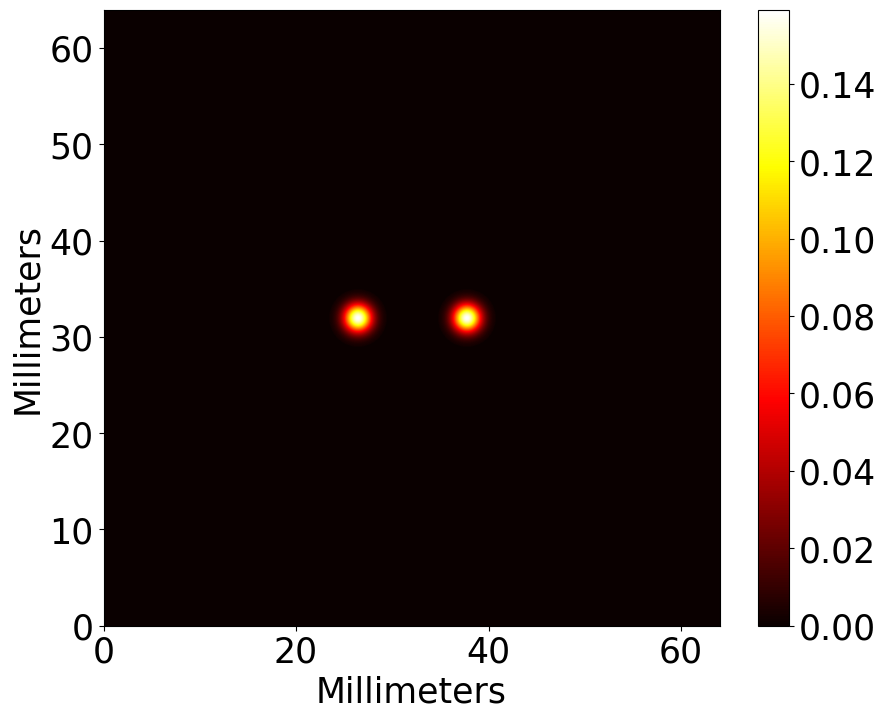

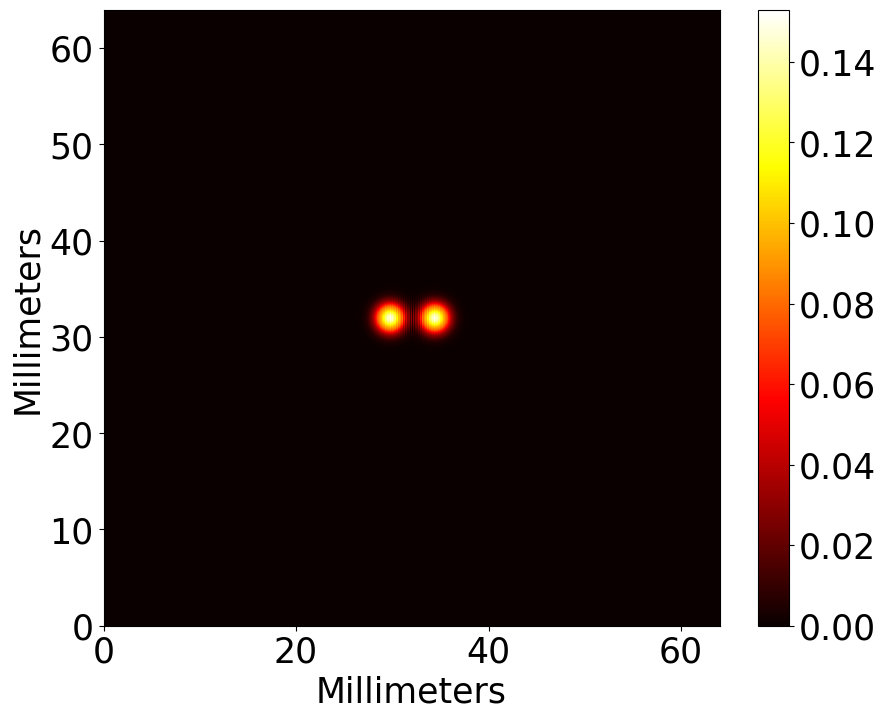

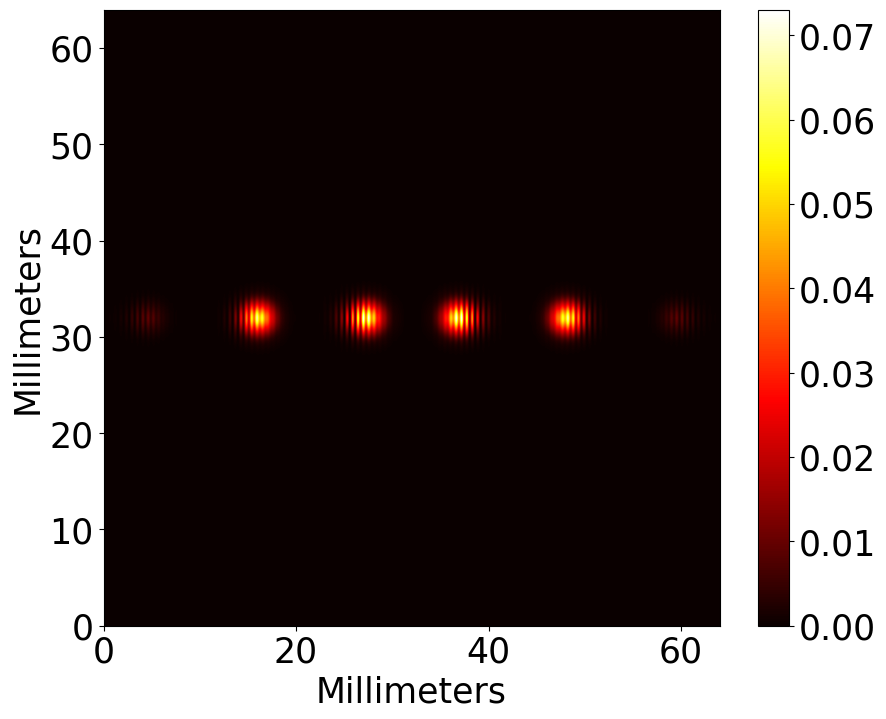

In [7]:
#@title Profile Plotting
plt.rcParams.update({'font.size': 25})
# print("Eff=",eff)
# print(np.max(iout1cpu))
plt.figure(figsize=(10,8))
plt.imshow(icpu, extent=[0,64,0,64], cmap= 'hot')
plt.xlabel("Millimeters")
plt.ylabel("Millimeters")
#plt.xlim(30,70)
#plt.ylim(30,70)
plt.colorbar()
plt.show()
plt.figure(figsize=(10,8))
plt.imshow(iout1cpu, extent=[0,64,0,64], cmap= 'hot')
plt.xlabel("Millimeters")
plt.ylabel("Millimeters")
# plt.xlim(27,37)
# plt.ylim(27,37)
plt.colorbar()
plt.show()
plt.figure(figsize=(10,8))
plt.imshow(ioutcpu, extent=[0,64,0,64], cmap= 'hot')
plt.xlabel("Millimeters")
plt.ylabel("Millimeters")
# plt.xlim(27,37)
# plt.ylim(27,37)
plt.colorbar()
plt.show()
# plt.figure(figsize=(10,8))
# plt.imshow(Tphcpu, extent=[0,100,0,100], cmap= 'hsv')
# plt.ylabel("Millimeters")
# #plt.xlim(20,80)
# #plt.ylim(20,80)
# plt.colorbar()


# plt.figure(figsize=(10,8))
# plt.imshow(Tphcpu, cmap = 'gist_heat')
# plt.xlim(1500,4500)
# plt.ylim(1500,4500)
# plt.colorbar()
# plt.show()
# plt.figure(figsize=(10,8))
# plt.contourf(ioutcpu,100,cmap= 'hot')
# #plt.xlim(1000,4000)
# #plt.ylim(1000,4000)
# plt.colorbar()
#plt.savefig('k'+str(1)+'.png')

In [ ]:
# plt.plot(ioutcpu[3000])
imax = np.max(ioutcpu)
print(imax)
maxp = np.where(ioutcpu == imax)

print("imax=",imax, "maximum point=", maxp)
#print (Pout/Pin, PIBc0/Pout)

0.04641548751654183
imax= 0.04641548751654183 maximum point= (array([3000]), array([3635]))


In [ ]:
plt.plot(ioutcpu[3000])
plt.xlim(1000,5000)

In [ ]:
#plt.plot(effct[0])

ef0 = 1
theta = 0.0065
#pertheta = (sig/0.0065)*100
sig = np.linspace(0, 0.005, 30)
psig = (sig/0.0065)*100
ef = ef0*(1-2*np.log(2)*(sig/theta)**2)

plt.plot(psig,ef,label= 'Analytical')
plt.plot(psig, np.divide(effct[0],82.69), label='Simulation')
plt.legend()

In [ ]:
plt.plot(effm)
l1 = np.max(effm)*0.95
plt.axhline(y=l1)
plt.show()
plt.plot(im)
l2 = np.max(im)*0.95
plt.axhline(y=l2)
print(effct)
print(im)

In [ ]:
#@title pixel dependence
pix4096 = [83.33115619905603, 82.66706807299859, 80.73787633936905, 77.7232188571957, 73.89148624028842, 69.56065899061088, 65.05507920148365, 60.66644265026723, 56.62528712563668, 53.08618581394023, 50.126567507804424, 47.75644698368618, 45.93533553195965, 44.59059407451215, 43.63528667960562, 42.98179922919327, 42.55099843502796, 42.277187613728934, 42.10927236213741, 42.0098214366459]
pix5000 = [81.05260126303168, 80.41698587498949, 78.570662985714, 75.68574991870692, 72.01950162393369, 67.87657508171621, 63.56758446179962, 59.371742893403834, 55.50953804624075, 52.128586270524856, 49.30256337632212, 47.040759804026344, 45.30385409845496, 44.02219659453528, 43.11236795963729, 42.490444566294805, 42.080771528500655, 41.82053179529272, 41.66093800518191, 41.56634543937711]
pix6000 = [80.89354872028771, 80.25547273998026, 78.40205164078137, 75.50610714536779, 71.82596214932532, 67.66748449457558, 63.34255708875792, 59.131368269865916, 55.255173838978614, 51.86203346146227, 49.02579107497523, 46.755674611716444, 45.01222840993245, 43.72550333082759, 42.811860530596626, 42.187162336346, 41.77555895458001, 41.514053407043725, 41.35377141165409, 41.258932180481686]

plt.plot(pix4096)
plt.plot(pix5000)
plt.plot(pix6000)
plt.show()
ratio = []

# get last index for the lists for iteration
end_index = len(pix4096)

for i in range(end_index):
    ratio.append(pix4096[i]/pix5000[i])
plt.plot(ratio)

ratio2 = []
end_index = len(pix4096)

for i in range(end_index):
    ratio2.append(pix4096[i]/pix6000[i])
plt.plot(ratio2)


In [ ]:
#@title stat
import statistics
effctl = [[80.83079791994197, 80.85438918088369, 80.84520219032571, 80.84436057300758, 80.82299149131484, 80.81281745919694, 80.85582096083516, 80.73738819012878, 80.84631608108023, 80.7651685839014, 80.85110944897042, 80.82136272478321, 80.83609178548427, 80.8018380339155, 80.82133528832232, 80.85297913774156, 80.82519508014919, 80.85397354544433, 80.61877550062069, 80.75150082190238, 80.813252889332, 80.84971004653399, 80.85566284300121, 80.85232509161399, 80.66863724368775, 80.85074377081341, 80.8432173865337, 80.75579735439952, 80.81637668981057, 80.85241478346997, 80.77920455350244, 80.81206140203457, 80.85533681777463, 80.70973141026685, 80.84593798035799, 80.83487653690376, 80.85520614304168, 80.85556712728628, 80.81217402670245, 80.82649081129264, 80.84931636370244, 80.84754368017141, 80.83716990272116, 80.76723821060531, 80.85312715953333, 80.59437799194686, 80.8043245321289, 80.61820071888397, 80.85483167890283, 80.8544282248074],[80.48606325500577, 80.72601591525527, 80.46600224844632, 80.75168801856137, 80.71586006732218, 80.82479236508756, 80.85254412815637, 80.8527047482628, 80.57690700981681, 80.84876638989815, 80.85493211216554, 79.90223417824102, 80.84521018952412, 80.64203590721955, 80.85005762666633, 80.37659203481492, 80.80525125615189, 79.83886639179923, 80.51897470499232, 80.85590902588417, 80.84294380678341, 80.78239184781094, 80.54389200321457, 80.84558338287997, 80.01858822417263, 80.69283229883662, 80.66758044332418, 80.77907185376331, 80.6888015888058, 80.80205061815848, 80.7889521493265, 80.66079921846263, 80.7417606092761, 80.78004349569282, 80.85475010167241, 80.67714096857806, 80.84518037129989, 80.85064691902525, 80.36722870023054, 80.61812136277156, 80.82188711903126, 80.79043974761795, 80.71298456611495, 80.8558998427147, 80.62803388942757, 80.85453485050459, 80.83572541301, 80.74398673648068, 80.84148842663467, 80.83275244264557], [80.80076500626303, 80.68331347589283, 79.65694708211186, 80.82940739328677, 80.85291029957014, 80.59236324885076, 80.12906232162112, 80.79584431371345, 79.65478671523194, 80.63054149973277, 79.95037541054874, 80.63700054465781, 80.8476997324548, 78.46180124041938, 80.85335641412054, 80.64879081302004, 80.8535036035322, 80.74389321035285, 79.32394628405531, 80.28804140512287, 80.51898351389796, 80.597495195175, 80.48709563270938, 80.84358010455051, 79.10899517069431, 80.47388597774024, 80.82255026280455, 80.7623290293172, 80.84964235895501, 79.84597505379303, 80.79058587392184, 80.53568270431646, 79.93830109022636, 80.2247299354383, 80.77422256148081, 79.94989513113447, 80.85496210238186, 80.67983748225245, 80.72410934461699, 80.69255513280805, 79.73480051769751, 79.42360586881722, 79.26496697506235, 80.6663185750863, 78.16345195756661, 80.49568001034314, 80.82681657883957, 79.52969155477443, 80.48298872616722, 80.64968651068556], [79.77050174651511, 80.8298025153635, 76.16570283109021, 80.85517681402618, 80.84980171968039, 80.81644008913975, 80.81949663726834, 80.85567443539574, 80.6279528460443, 80.48806578182926, 78.70931144409522, 80.32811748144222, 78.55414329467789, 80.56379683886496, 80.401831852685, 80.32373987611201, 80.83165379436326, 79.8102869997927, 80.55674837163443, 78.98192127485953, 80.75708081464502, 80.64142578858062, 80.5914471237974, 80.73020580219452, 79.98657830397138, 80.2595263270494, 77.93279153141657, 80.84715332241123, 80.75754133560523, 80.32304131451593, 77.98974024300229, 79.90840217973168, 79.49764028961779, 80.7366270052063, 80.7829594907243, 80.56696667848844, 79.92853218830427, 80.85552317328923, 80.02513607487094, 78.59796335106918, 80.73848359016198, 80.66321604550544, 80.56073447868172, 79.2664707417668, 76.75535957636387, 80.42062201798515, 80.83662235759435, 78.2430087741232, 80.6191200124488, 80.78595210973172]]
effctc = [[80.84435393394855, 80.85429668875659, 80.81770091089436, 80.8144913181217, 80.83953677019721, 80.83824978786002, 80.83899878984646, 80.7620043442977, 80.85545694431792, 80.81280921487178, 80.78135083299456, 80.79206567511157, 80.8553408900141, 80.85523422491322, 80.8458367535145, 80.78127855165918, 80.84891993198805, 80.82065039616545, 80.84042777579045, 80.81790082388626, 80.8417900114101, 80.84939157391521, 80.85579536343778, 80.85430284495617, 80.83417930015936, 80.85585113995062, 80.85211787655577, 80.83396049233106, 80.77204821911631, 80.85588919868403, 80.82317948956693, 80.77292743814273, 80.85287039071865, 80.83086538907159, 80.85227354526032, 80.85442895545991, 80.77561279910866, 80.79288803340636, 80.80724958998215, 80.85590829530427, 80.84330426295885, 80.80505603194048, 80.81731417227101, 80.7884918938851, 80.77111280768518, 80.83561125159903, 80.85245819829984, 80.85482941784853, 80.83324105281577, 80.84076556394207],[80.83056682381407, 80.83565545703972, 80.82097215218678, 80.61914015536426, 80.67103921294067, 80.84936485104936, 80.80881361265911, 80.72318336625537, 80.7700766065204, 80.84339504728132, 80.75037787015835, 80.8505886751535, 80.58712110655858, 80.85589790895713, 80.74874412683212, 80.84745724211135, 80.74536644253322, 80.85587643859726, 80.72456627823553, 80.8138699599201, 80.50591286828369, 80.85588811391703, 80.75566328989811, 80.82581795240127, 80.79351049733768, 80.35843168247875, 80.19004000718742, 80.62527898148208, 80.85120069515183, 80.78819601780845, 80.84289792543579, 80.32208786070085, 80.84025126006745, 80.84533082890513, 80.83256832024695, 80.827643878956, 80.8538867425162, 80.81239413678107, 80.84277249856915, 80.83192290961156, 80.8190340950399, 80.8533809781669, 80.73583844473116, 80.7430146089561, 80.8485870461184, 80.69922817764623, 80.58260323600179, 80.786970178914, 80.69002373595085, 80.85150710532476], [79.72519542635338, 80.71696159677023, 80.6867222405845, 80.85582932395987, 80.15569395956868, 79.51689147261014, 80.84796751886296, 80.70355868209546, 79.4653904556407, 80.26362124716034, 80.06565238232747, 79.98241281339999, 80.57204036097863, 80.02007575734055, 80.84336547822043, 80.55963531690634, 79.72241703055634, 80.78750249742257, 80.33331300487541, 80.51566382642677, 80.76896345252146, 80.38232405976915, 80.81162352811981, 80.66672926385417, 80.48484422886699, 80.85520948591089, 80.85398539350074, 80.61772594723126, 80.61159454826154, 80.83823860570284, 80.57452397072089, 80.81446801914667, 80.71318895971716, 80.58263567402167, 80.74522828965713, 80.8478738702961, 80.64983835192407, 80.57993783104216, 80.47422269128468, 79.82216339165466, 79.82503607495373, 80.66893140341584, 80.8471809870732, 80.67294425309647, 80.10941588164704, 80.83758075314907, 79.69227804433504, 80.79950265410197, 80.35496886318937, 80.8548827939075], [80.36889915020454, 80.84720315395282, 80.85383450808402, 79.65012409533526, 80.63060237793461, 80.82585491157381, 78.71049370241668, 79.05312125858043, 77.82547189481173, 80.82075867541963, 80.65162618104904, 80.83762321942925, 80.8548559133295, 80.76773532279921, 79.54874927631647, 80.7094101215304, 80.76777818839511, 80.83703299904457, 78.90509646630562, 80.58914707341128, 78.6965958518254, 80.59250142964038, 80.73136130845567, 79.91977919474932, 80.70721522573004, 77.75670900004638, 80.82579033139147, 80.84479482549301, 79.0204918249852, 79.89697431521911, 80.85569179506969, 79.1010948599742, 80.76594919865447, 80.77617633086194, 79.8949284212909, 80.85561780070977, 79.98437190310726, 80.84614833797391, 80.81426944962666, 80.6889870266246, 80.85313999790046, 80.577116359404, 80.60924346415702, 80.71302269535583, 79.36585817376972, 80.79989324875761, 80.07200828130871, 80.85540595018882, 80.74787293576831, 80.12581823534349]]
effct1 = [[80.85139088140131, 80.48075030227665, 80.16245570624436, 80.84411080285656, 80.85120150742529, 80.77409207349552, 78.54532180839189, 80.29122559235918, 80.83071748190959, 80.84561922078257, 80.42460600281808, 80.723249251564, 80.49734675621714, 80.81321553534806, 79.3711483430028, 79.74202170181594, 80.85380921609068, 80.85545048300709, 80.62536928254487, 79.73993751505837, 80.07205795388577, 80.47208673277986, 80.7815008296348, 79.07423379401374, 80.00041210100068, 80.23454722604801, 80.25528517020753, 78.9247593149273, 80.84732732580659, 80.81339190647152, 80.26928017029431, 80.08355545924404, 79.31548325724962, 78.288612936954, 78.7399469491884, 80.07608605207776, 78.90333235544077, 78.81655881988992, 80.65685963732935, 80.85509141233273, 80.60800517759027, 80.71589834588436, 80.32134113434026, 80.85589456742483, 80.63412177675396, 80.42370878058112, 80.64389925173514, 80.80239647747895, 80.28260602499104, 79.9809065852948], [80.85313989657715, 80.85339256917547, 80.84403850062816, 80.6442572358403, 80.82752700435373, 80.52534882438287, 80.85254595003644, 80.85135164946733, 80.80822751340014, 80.60643645881274, 80.82914650979906, 80.35167361212707, 80.85051353158178, 80.59912806074779, 80.46494625161313, 80.34687173593625, 80.69232095561203, 80.39142740762713, 80.81437055802253, 80.69766626146256, 80.74800612019865, 80.29251396996399, 80.71481169071842, 80.68614170123578, 80.8455104318164, 80.58994828749529, 80.60873761801331, 80.71740562683398, 80.66307415419244, 80.8438624035347, 80.78336654809836, 80.65588945407902, 80.8510716002209, 80.78655326128617, 80.8386410025867, 80.84968692089858, 80.51895832115231, 79.8444599228873, 80.84203017375249, 80.85521266045714, 79.72901410220237, 80.27097108947099, 80.75190687099801, 80.78263122045536, 80.80723139547113, 80.85590703289243, 80.14742797661502, 80.72384080609176, 80.68411838740104, 80.83277321274994], [80.85499643851671, 80.60638395267972, 80.80891126778118, 80.65127201688902, 80.53362736541295, 80.59557220964514, 80.85415336081819, 80.84910133672574, 80.85433097427841, 80.50192423938466, 80.63246444582049, 80.84711610035798, 80.81681904281677, 80.83097062917503, 80.53019525566751, 80.79651488506599, 80.79275506570366, 80.7957160734267, 80.84723493960549, 80.82866836366486, 80.8431358432968, 80.85511177926217, 80.85380049909784, 80.69389937760123, 80.45114930981002, 80.44905792703604, 80.83410249443483, 80.75465967119604, 80.65762689298354, 80.8293723351358, 80.67527320291744, 80.83535481608092, 80.73435869259924, 80.74868071108044, 80.65915132416966, 80.80292879437528, 80.85551388787933, 80.68120611660855, 80.31611607447489, 80.84972881261272, 80.5990493020418, 80.80443302406508, 80.65290629819964, 80.76047771613506, 80.72606000734986, 80.7331343796897, 80.84257573194876, 80.81048401880382, 80.57315530595595, 80.58925749245924], [80.7596754745565, 80.85278735033307, 80.85011270074433, 80.59858301727341, 80.85374411846163, 80.61184742860381, 80.79712348528258, 80.83728603938316, 80.64001806270183, 80.85567667615902, 80.85329560560689, 80.62578242611859, 80.77535640615542, 80.64743260418568, 80.85354490415413, 80.82126228453536, 80.84207405839537, 80.82516952266944, 80.84564923217751, 80.83463397504757, 80.5376379569355, 80.82253201089966, 80.85590300191883, 80.8557999007126, 80.82609777578843, 80.85458938179582, 80.60602586686633, 80.83005430361936, 80.74686327183099, 80.62310737657668, 80.37158195429751, 80.75847938929269, 80.62225590646517, 80.8504293424541, 80.78466481840957, 80.48782495192742, 80.65860918677646, 80.81587731756214, 80.82889873670648, 80.39129761141656, 80.83916773443597, 80.04647632795874, 80.85556267936241, 80.83153376552555, 80.83397766920514, 80.54571445088612, 80.84983793642328, 80.81205248266834, 80.8349762205654, 80.50385147183314], [80.73530175674276, 80.3779542117028, 80.84275386485945, 80.78633289304238, 80.83936401842745, 80.47475495409519, 80.76219167819067, 80.72958067897542, 80.85499074212417, 80.7538155028407, 80.60038354399198, 80.82657803867741, 80.62258264810308, 80.69541177698373, 80.74532330472164, 80.85573471539645, 80.84452555962368, 80.75006792371, 80.85348463886014, 80.84787439345583, 80.47573450006531, 80.85584073827256, 80.85431984386184, 80.7395963705916, 80.85471154476483, 80.69077742232392, 80.78713488035076, 80.85483291168632, 80.20897266799115, 80.85357101668207, 80.72126731100444, 80.83998192998484, 80.79566922382722, 80.72898051646473, 80.52065191350589, 80.55475068787139, 80.85107904972027, 80.85570850766503, 80.58253026928837, 80.7644454830238, 80.75108679880812, 80.84524206844344, 80.8547725891676, 80.82746186105861, 80.6163704162829, 80.85468900593843, 80.8270024526832, 80.79856011040941, 80.71962938736903, 80.82412944780188], [80.60197746017144, 80.80395256119081, 80.74406046765708, 80.48602603978895, 80.77641727679567, 80.7545002411878, 80.7397803648225, 80.24292426927629, 80.85199622508362, 80.77050609834544, 80.6530975903229, 80.28479191528099, 80.76530185594731, 80.78999654510424, 80.8412589367421, 80.8092132645164, 80.4874158125526, 80.83388620980723, 80.52730915431394, 80.78137402153975, 80.8221770840684, 80.74240916966589, 80.84618162548375, 80.82676054671931, 80.73547660099443, 80.45840155543654, 80.67544646111708, 80.68330460731144, 80.8403523467618, 80.83191775979232, 80.62639120331899, 80.84769994939367, 80.74222805342454, 80.8237457024909, 80.84511469254633, 80.85247742323673, 80.67739275186845, 80.84677386343749, 80.83525343803879, 80.84406672238653, 80.8435746998855, 80.81831186046088, 80.85370059667292, 80.84375721569592, 80.45036920048973, 80.32736146592737, 80.8084571174476, 80.83288724555204, 80.85413198468405, 80.842037988356], [80.85184444278491, 80.85574479411302, 80.45039092322315, 80.84617740617868, 80.84813789023347, 80.729238409511, 80.8426831246084, 80.5648480787752, 80.83601661717621, 80.83473673746646, 80.77908850009146, 80.71421174291908, 80.82378569059749, 80.80105317770354, 80.78136820022574, 80.85538972306352, 80.81748125380288, 80.8364759393089, 80.77520134543464, 80.7081595031853, 80.83740839237173, 80.75227560985518, 80.85333671553549, 80.85144012462638, 80.85546581470581, 80.80849258626294, 80.7448008708602, 80.84853174311012, 80.69448737840207, 80.44263330394153, 80.2198981809667, 80.7768427780013, 80.35421421398605, 80.80876129495753, 80.76058649973997, 80.69845457063758, 80.85152270139969, 80.84810097859089, 80.78945807396147, 80.84752075519519, 80.85515211406754, 80.72407999922736, 80.8534424459315, 80.63191659319422, 80.84932157100728, 80.84883750117856, 80.79816040410451, 80.3287556484882, 80.83821319270047, 80.80511087033561], [80.77126558113147, 80.72202136594187, 80.70926595750139, 80.77771732185678, 80.2942567627004, 80.8441507613131, 80.79369166582528, 80.46956893020334, 80.66915277880275, 80.81800426717916, 80.6654572797554, 80.80625427531616, 80.54692695860341, 80.54755014518085, 80.30692139881586, 80.75663875601239, 80.33970295451842, 80.8162428678706, 80.68211777160506, 79.8754474889398, 79.70892296932857, 80.84702619558972, 80.78304648494056, 80.77359478997109, 80.84341616075454, 80.81812050212338, 80.8433576223713, 80.83935041585897, 80.1216646476753, 80.85536698921615, 80.69565804963123, 80.74233139915266, 80.80382235787758, 79.61846533715122, 80.65115822135806, 80.01534782779217, 80.73428502365493, 80.58266952380916, 80.5566574800674, 80.7151547941532, 80.52795976471529, 80.37462900783557, 80.82802593922978, 80.25423549659153, 80.82408016563483, 80.16622695580908, 80.84560888180948, 80.84456842517977, 80.83629030327411, 80.09399358596706], [80.69228200234184, 80.13916271273179, 80.8305940093949, 80.82829973472673, 80.63852159225667, 80.5890317928483, 80.70609395133079, 80.01034698420891, 80.68326278851967, 80.84669030673737, 80.75012217410904, 80.65782408194798, 79.065401877262, 80.73216794764096, 80.68356272258893, 80.78990421390827, 80.73266651389332, 78.58182711131793, 80.329016737977, 80.11013620779366, 80.77211228112446, 80.20056529489855, 80.75678157617855, 78.1594121188846, 79.86818294460832, 80.77632377338666, 80.8149332367145, 77.3738151686052, 80.74916703741428, 80.13688567194531, 80.73757921926621, 80.85548269645098, 80.29228697480472, 80.52905591643912, 80.21989713866593, 80.83842704173884, 80.80965434054438, 80.48668212707017, 80.8159913750023, 80.84521717385728, 80.84492594368955, 80.62556423312633, 80.61182123384609, 80.15015033643289, 80.85017523570409, 80.76491395704754, 80.19337668821873, 80.43045701370075, 80.51219739647294, 78.80629090035272]]
#effct = [[80.0502893854884, 80.76686714267848, 80.66573774458152, 78.97881226266594, 78.9640507787838, 80.40496979453299, 80.02488222822292, 80.85512534734764, 80.72874891162883, 80.82746976515382, 80.0504761296318, 80.61871805103782, 80.84229331980907, 80.71122518886878, 80.26095221084681, 80.84103331447965, 80.83557214077072, 80.57752574183749, 80.41316183230757, 80.63361594319912, 80.79302676145218, 80.01216694412602, 79.57366705290619, 79.38619979527112, 80.46570957229474, 80.63994261159043, 79.47374562495828, 77.19761635530962, 80.81013122892567, 80.83906668126448, 80.54616109526296, 80.85092118817238, 80.852895919449, 80.68142584179168, 80.49349802379696, 80.24290361403904, 79.45799721832825, 80.85461880648907, 79.99978106174548, 80.6364121391643, 80.69010046305497, 73.63962698883867, 80.10398742534144, 79.41135425908895, 78.95221825121816, 80.84996718621167, 80.78037023900269, 80.2556407564702, 80.18002940507768, 79.33572003942731], [80.85540739792441, 80.52988053884062, 80.83814278197138, 80.58572165259086, 80.6361795505409, 80.4771903274904, 80.7468824402062, 80.84355769692647, 80.67753067921454, 80.2259151931031, 80.63646098257519, 79.96086678425708, 77.57888870121943, 79.29054757112087, 78.52563837288656, 80.56109637000083, 79.28903273405467, 80.8067231034475, 80.14657510582013, 80.62294916416143, 80.84730414930715, 79.80758396279411, 80.84003385377126, 79.25220136679104, 80.13559760034248, 80.75913629075247, 80.85530992030763, 80.53153910155385, 80.70452758884691, 80.12751107174509, 80.70752177865761, 80.78248498741893, 80.85338205381582, 80.45188027526937, 80.12699096942022, 80.44606216579231, 80.69889993402508, 80.00614624963954, 80.8461308413268, 80.72523915685612, 79.91978353092146, 80.06215069697397, 79.08006666214155, 78.69236244242613, 80.76698913234054, 80.730066730334, 78.98990571888024, 78.06737893681206, 79.88757196438168, 79.27199537193982], [80.69153450347787, 80.85559939950613, 80.20580255715554, 80.8543833412085, 80.478795655474, 79.84879765337598, 80.26455539100463, 79.72672380530132, 80.42765220589472, 80.38808622930058, 80.82431442008271, 80.35923665530666, 80.65698063446487, 80.70182916747423, 80.59794824871676, 79.24707331235041, 80.0709646749698, 80.3396564709846, 80.60111335961516, 78.6394650179674, 79.75770437425709, 79.63052821774569, 80.53112984070556, 80.23871998636639, 79.98886478014808, 79.08423797371348, 80.81000238606211, 80.68058885903217, 80.40786059659557, 80.35474202721946, 80.78541685519784, 78.14255503020227, 80.31283288239595, 80.82226368257689, 80.75340124517487, 80.6981232377732, 80.27953339575723, 77.8558651974924, 80.59461996531847, 80.81126316069029, 80.8549352507512, 79.96677782469601, 80.75202431241398, 80.82145953784884, 79.68266168586125, 80.8406812144619, 80.73839207167327, 79.11577183842779, 80.08618453577137, 80.85259991483223], [80.72907751604839, 80.76677467152071, 80.69993227973363, 80.75232982781836, 80.52787940075079, 79.75348343009992, 80.81688667471428, 79.35944701333351, 79.95193004335387, 80.84842464919272, 78.94053873697672, 78.31015403929212, 80.5055334517879, 80.14780926446834, 79.20832778893202, 80.84849392971074, 80.56879363287221, 80.64432530278613, 80.84549588389287, 80.63755355085533, 78.94751412745207, 80.42999208939746, 78.86099006190392, 80.6354561914411, 80.59478456445348, 80.8147923304451, 80.7199861928743, 80.7159762519411, 80.51227722016013, 80.40118099059671, 80.4481348762923, 79.8855348113215, 80.81218320153391, 80.71148956098733, 80.84727168798152, 80.42662326123748, 79.87328508667937, 80.1592825856505, 80.69332597038762, 80.33468033909624, 80.84273576296461, 80.14053784902595, 79.4212019304124, 80.85575478873304, 80.64126449133528, 80.54652791325502, 80.42676933149038, 80.70046805401326, 80.7376478024104, 80.65529073423437], [80.60426578065396, 80.6676528713698, 80.18170767166465, 79.43436597579984, 80.75247636030181, 80.79741349163201, 78.98774265190256, 79.66843637391901, 80.5172310937272, 80.46236277893439, 80.36541735476887, 80.53768157270828, 80.84222116345207, 80.22628036859619, 80.70479665864906, 80.62181103923041, 80.2379239376286, 80.85303326874944, 80.12481970152912, 80.83320078041885, 80.04217142937881, 80.07885673433954, 80.84937230226627, 79.31047924142253, 80.67309361916166, 80.72559124390347, 80.74044875458634, 80.85245281016941, 80.8383445647375, 80.82689127485713, 80.66325146130333, 80.69262132342418, 80.70504668406764, 80.16458241743304, 80.7428887607355, 80.72294065796378, 80.37077996761009, 78.94115103633249, 78.26056311203153, 80.58674247790927, 80.77732913223252, 80.01142718466609, 80.47458002599615, 80.64878761165676, 79.3978792387962, 78.97482201296178, 80.22733295267236, 80.31944151376675, 80.62232150136727, 79.30108982124572], [79.6908519394735, 80.02384898572734, 79.9905269140061, 80.02710172500186, 80.56110516896354, 80.84446311032842, 80.70469229979909, 80.80148874883666, 80.66352546912758, 79.89128244449347, 80.17061860690377, 80.83989112041345, 79.65978297422257, 80.45463756868139, 79.68847901165668, 80.77126175581853, 80.49356017869125, 80.6536566447305, 80.42149443600128, 80.06730259655713, 78.32274906107001, 80.82191638531879, 78.97951923857474, 80.17843281895152, 79.23964524718237, 80.51093540957005, 77.80336442960636, 77.52841253339294, 80.8518362781106, 77.83097372133057, 80.58684713954847, 79.72746416508777, 80.71946834477782, 80.68174235409772, 80.18188309781887, 80.69517023153001, 80.45197546910204, 80.73686519457812, 80.82828410199663, 80.84012329548335, 80.74871263430164, 79.24017505153054, 80.35568758461704, 80.82900411714539, 78.8353080343558, 80.06199835255703, 80.78641663251659, 80.82390136335333, 80.52297551174553, 79.82201226918907], [78.82762792479407, 79.7462558138038, 80.49710448072435, 80.43579190646156, 76.96053699247408, 80.6873306954388, 80.3101642800678, 77.08531936928466, 79.39106498319612, 78.51634549004572, 80.62247687834245, 80.65047630876695, 78.95041808873286, 78.29551800057381, 80.73206287165894, 80.18616631796095, 80.84165670091386, 80.84880978963758, 80.6071829369854, 80.58656448257963, 78.31451930924989, 80.84742487669637, 79.44130922705098, 80.8249776664274, 80.71689092258178, 79.02599805280916, 80.84027646375141, 80.83476763014073, 80.75643700306682, 80.74593722694587, 80.77137357223802, 80.70894681626163, 80.8279569308534, 79.17112994390443, 80.67693670152383, 80.53075562900726, 78.2069752299635, 80.01927355768377, 79.04640178684136, 80.71806066573455, 80.60129605388573, 74.13276198534142, 79.82226370727659, 80.1075999642836, 80.84673678824859, 78.75872125925194, 80.69532239804286, 79.80443094263205, 80.74519309671253, 79.53134516924744]]

#print(effct)
Mean = [statistics.mean(effct[0])]#,statistics.mean(effct[1]),statistics.mean(effct[2]),statistics.mean(effct[3]),statistics.mean(effct[4]),statistics.mean(effct[5]),statistics.mean(effct[6])]##,statistics.mean(effct[7]),statistics.mean(effct[8])]
stdev = [statistics.stdev(effct[0])]#,statistics.stdev(effct[1]),statistics.stdev(effct[2]),statistics.stdev(effct[3]),statistics.stdev(effct[4]),statistics.stdev(effct[5]),statistics.stdev(effct[6])]#,statistics.stdev(effct[7]),statistics.stdev(effct[8])]
plt.plot(effct[0])
# plt.plot(effct[1])
# plt.plot(effct[2])
# plt.plot(effct[3])
print(Mean,stdev)


In [ ]:
#@title Error Plotting
plt.rcParams.update({'font.size': 20})
phr = np.linspace(0.1,0.9,9)
Meanl = [80.80949394739426, 80.68715001143079, 80.31895541895628, 80.03492077375469]
stdevl = [0.06537463089680307, 0.2351665590961771, 0.6462468935717333, 1.1017405534491296]
Meanc = [80.82765238317867, 80.7512791481751, 80.47395903328268, 80.24700492526615]
stdevc = [0.028569207898504288, 0.1452900521633689, 0.40148225314368724, 0.830486918393359]
mean1 = [80.21744453982923, 80.65652068901947, 80.72600979605475, 80.73325472347324, 80.74217015542868, 80.72847894486225, 80.75458512855492, 80.58714781215194, 80.36450483019456]
stdev1 = [0.7125768872877065, 0.25424682414480154, 0.13273651974291234, 0.16580591885849866, 0.1412635332576328, 0.1596118281026172, 0.14958129524892727, 0.31605643008005724, 0.7364563735180615]
mean2 = [80.12116859567885, 80.17617883307875, 80.2406450916959, 80.33312302295697, 80.29928243529262, 80.1192674353575, 79.85701789780197]
stdev2 = [1.17815148845791, 0.7936210696799515, 0.7000910468650712, 0.6187758638456782, 0.618595007529086, 0.849285916790662, 1.3095995444947313]
fig = plt.figure(figsize=(10, 8))
plt.errorbar(phr, mean1, yerr = stdev1, ecolor = 'red', fmt='-o', capsize=2, linewidth = 3, elinewidth = 1.5)
plt.errorbar(phr, mean2, yerr = stdev2, ecolor = 'green', fmt='-o', capsize=2, linewidth = 3, elinewidth = 1.5)
plt.xlabel('Polarization Power Fraction')
plt.ylabel('Mean Efficiency (%)')
plt.ylim(75, 85)
plt.show()

[65.73942387194833, 65.38186433685543, 64.68490167508253, 63.067849833971714, 63.316723850751735, 60.866111049300656, 58.8191671644573, 57.69974347853116, 57.55134778569201, 55.8567533068697] [0.07096225320852637, 0.34834311861174194, 0.8991669551692155, 3.3078740471121, 2.4204723943198196, 4.343914600153759, 7.385219165042275, 7.033570577590628, 6.477300743490679, 8.277850474874274]


<Figure size 1000x800 with 0 Axes>

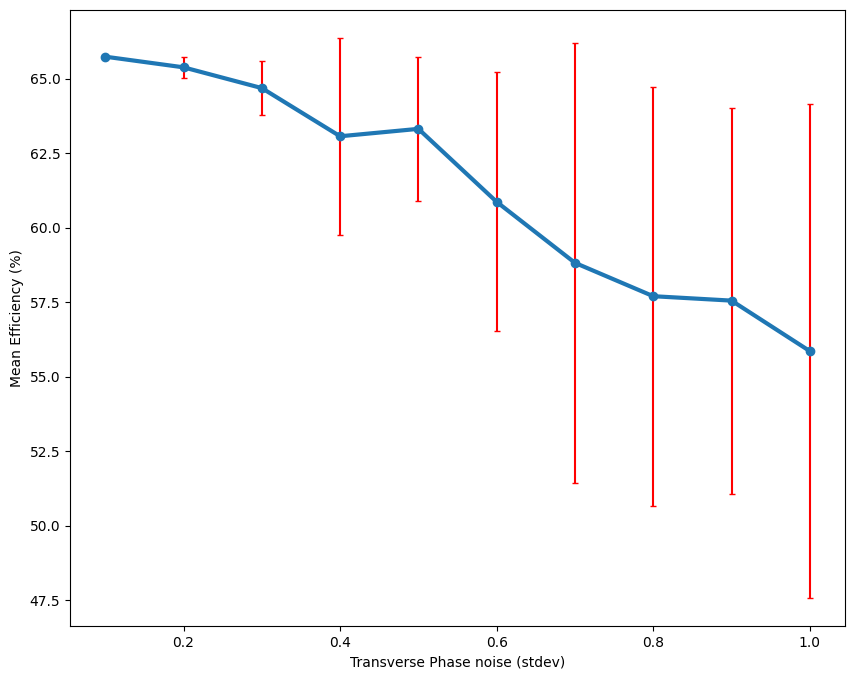

In [6]:
#@title Statistics
import statistics
#effct = [[80.15650491160456, 79.36055934442581, 80.98113585775228, 80.83508011759615, 80.9370046029103, 80.90446873416765, 81.03196511607155, 80.68230153514276, 80.97593316366807, 77.64251940144014, 79.39312587365215, 79.72578577638626, 80.58015403955501, 80.46560027006922, 80.9535985513932, 79.50969804005811, 78.8896063047176, 80.51047762469014, 79.47431179865832, 80.99755010541912, 79.36036913257941, 80.81393253765573, 80.96207501158176, 80.84022747539761, 80.74372476575311, 80.9019399072902, 80.52888057666277, 80.69700045882095, 80.72170004562997, 80.93851313126727, 81.0523358353614, 78.58075418581745, 80.48615791403762, 74.28386337648824, 79.93731203364656, 80.69568349687549, 79.47403809435446, 80.81964975245812, 79.49139630116585, 81.04910183288406, 80.49364338530222, 80.92080253705073, 80.14380399665906, 80.9846713659705, 78.16152513408451, 78.69958217502074, 80.88515817344063, 77.39638526035984, 80.98745569769109, 79.5304165724864, 78.5321813666286, 76.61089346869743, 79.12658641820815, 80.70296150364827, 80.87119983638166, 80.88989388874587, 80.80581433495534, 80.98247736872393, 80.01976404721742, 81.00804905927606, 80.67892795038196, 79.77756768653983, 80.47204289329282, 81.05056802877084, 80.36072641830977, 80.2256566755586, 80.81594286072986, 76.83926279948847, 79.64574502678614, 80.97993565835895, 78.07475495233308, 80.64350422810426, 78.52682959807962, 79.47175516614708, 80.44858691133511, 79.04137261427894, 80.47675988608034, 80.96865362949414, 80.1273848234918, 80.95391331584385, 75.02721718300977, 79.24373985556139, 80.36382374251086, 80.93981129955372, 81.02468098633477, 80.25399597004792, 80.15941707600376, 80.47458252077719, 80.22826768345875, 80.18150772130754, 77.27834780905984, 80.97158189183044, 80.6721118382408, 80.65161985153046, 80.27741442829817, 79.06278268178562, 80.48009736605744, 80.72716634653148, 80.74181533135277, 79.48681888941039], [80.93080171015555, 77.8396927145801, 79.40491635571644, 79.77748486830387, 77.6679585492974, 70.93833057051154, 80.76823880548704, 80.60987790031474, 80.47501284288649, 77.88987410626636, 78.16585172187277, 78.11252396260376, 77.41525820668956, 77.89036120027345, 80.08702537888017, 72.28340120215363, 75.49483497080523, 80.72921157623603, 64.54736703216513, 80.14334835375865, 78.14940776391023, 80.30589736902373, 80.01348474545904, 80.46500141102389, 80.19881995200868, 80.15627114688486, 71.64883051034612, 79.65051155663015, 75.2181511983312, 80.76996801052415, 66.20585908095256, 68.4538993682105, 80.98273164622954, 80.36581955932235, 75.96269749291939, 79.42286189711426, 81.05153908368258, 80.9104588870737, 76.46397241440681, 81.00503388135635, 66.12685590863401, 73.84814399593999, 80.8769681440897, 81.05252324335261, 79.25275632706673, 80.70782343202252, 80.8064452392773, 80.64202813419568, 80.19193168704409, 51.19751891029668, 80.91250043470536, 74.18493778776178, 70.89855183674445, 80.54186991588409, 72.89184135548041, 77.85309975430506, 79.62036612392768, 80.17488349226642, 78.66876261281874, 80.39194651742004, 68.55611381752989, 81.01963839735372, 59.5489220973985, 80.3864759913534, 81.05217915887181, 78.02925776943648, 80.85953017907697, 80.70717718895776, 77.33448881188608, 81.05130053921515, 68.80973490105244, 70.98394967275676, 79.69896596250787, 79.45871172713753, 80.93880108474848, 80.73983960190904, 74.58096670275228, 66.84921692180976, 80.09170617758605, 76.41580070646728, 80.16592476353162, 73.27152514583176, 75.53675693385702, 80.71761674533717, 77.61507506193091, 80.9752318435913, 70.87096373735488, 80.23434944245088, 77.01066484623705, 80.92736521213143, 76.37915285540372, 76.42958452733252, 80.23981163197291, 80.99441305969533, 81.05244628348657, 80.24801380782608, 81.04736383935584, 80.6980265166011, 75.477894542638, 77.89763053878889], [41.42348647373091, 67.45859270738859, 80.44615020020277, 78.29479420068346, 66.73100864194073, 80.98840430728528, 73.99635937647272, 75.95743965326618, 78.3706397546388, 77.78980521491039, 78.8358641826019, 80.24269173343404, 80.97729542508657, 65.49156953637026, 77.99653387864166, 76.35932365952017, 80.82327656253587, 81.04827713353147, 57.80779088083372, 77.25880689271291, 47.25631218199899, 80.36965578533415, 77.18813903735669, 77.20138583587347, 78.60013432809819, 80.26718920874758, 75.79889406998775, 80.80815493942958, 71.49786706753373, 73.19283610159665, 80.23737991990527, 57.357485559514856, 80.6041290543152, 79.98126396851161, 63.004369949965664, 75.94332152614646, 80.6247499389658, 80.97956016215032, 75.224609576053, 56.74138317704197, 58.22404690781264, 71.20694480391289, 77.43411282252146, 64.69191570600557, 66.06131556946198, 74.30332528558908, 67.60963971789884, 80.83538016651559, 67.07540458954563, 71.49491586466664, 80.73841349955948, 78.48264805309469, 78.73436755800716, 69.73320779747164, 68.91525179397871, 73.24332381556204, 72.0204026367379, 79.745496374218, 78.84094169935476, 79.34414241761594, 63.37412604750414, 77.27206451869009, 79.61601746616367, 72.55000008319209, 78.25508528940438, 80.44378231709376, 70.26922862490402, 77.8953681386255, 65.01856233927975, 80.45909587526323, 79.57227288397601, 78.91411303792478, 74.51988949631347, 74.61290628954961, 80.95631201360266, 80.89817767127155, 78.84922258371036, 55.501121852803415, 79.29293837922371, 78.78806684812577, 79.70212571274092, 80.11878809055544, 72.93049265568422, 80.52638008420425, 62.58193133003309, 80.98935774686473, 58.9116649333257, 69.91754055596333, 69.48163085331312, 74.59034855701222, 28.927035794598027, 78.68975846568897, 79.93528336372594, 79.20808500179837, 78.48498772076368, 81.05194584917578, 75.40244819777847, 80.61523790262073, 80.40186331144274, 80.98310412282807], [75.37443902342382, 64.75312551164608, 64.67297760481986, 74.08360333241447, 48.02207309828265, 79.1242232475912, 68.50998575174694, 79.62700505032004, 77.3721490347971, 76.32573900827411, 75.22821939646201, 78.37846762546819, 79.88420652639464, 79.92063262064524, 81.05178903085063, 74.77411398284254, 66.18148072615584, 61.27531306359063, 22.91631419444676, 65.95976723006292, 60.617810048826385, 81.03181120819335, 74.40426953225756, 80.98535542193275, 80.87433660692618, 79.60244676921204, 74.81279077649721, 77.85737438093459, 44.11985140132138, 60.339860609392524, 56.24667570256558, 79.16378887327193, 76.15342268307299, 35.70400841362573, 46.36831538076555, 78.96403763305526, 77.8336965111844, 70.88566951720284, 80.82008751746008, 58.135476106802976, 4.881807509539883, 45.33406939644912, 71.52547916342638, 80.5244614130757, 72.26582260481733, 80.99847991056647, 60.65966016735511, 31.756692665884646, 80.38949056076802, 80.06054078120309, 66.51542421622136, 9.986608482821365, 81.01911910195831, 65.98003901899487, 74.08060400246399, 67.60350239744571, 68.19775359744175, 80.80149916158244, 80.18011948655676, 67.47661274165773, 44.78534338359493, 68.31772138719572, 61.918819374688226, 38.16555651944315, 76.51175942388866, 65.42783535074634, 67.54541856956914, 79.93201379161664, 38.02178301804901, 80.99461065715337, 79.52551864601567, 76.91684690360793, 76.32230323868839, 81.05170691991378, 65.99546918883348, 77.67863462206132, 51.108867387446, 59.136064129576546, 22.256120807420345, 59.438099684793514, 77.43699332864882, 78.81283111495144, 74.97523559817621, 63.20530634390749, 40.64445828142972, 77.55201422125789, 64.34661006010877, 80.17742080137272, 74.92108178495765, 80.61670920249503, 80.7849778688253, 74.46237847890765, 80.91753157582413, 76.55911477262048, 79.30550212902001, 64.29501224054547, 81.0482133764859, 76.78612769102082, 60.387121889022886, 77.70229561658016]]
#phr = np.linspace(np.pi/20, np.pi/5,4)
#effct = [[80.18150491541238, 80.72440090277479, 80.96838289562469, 80.74646642965982, 80.71113878789322, 80.17042556286825, 80.75424221592871, 80.59842974888123, 80.51243756391776, 80.82040964006507, 80.25696558207011, 80.66896193866579, 80.96106447137416, 80.14896114528766, 80.73543802947076, 80.80648521031758, 79.94754825048537, 80.8684580838808, 80.68135378494344, 80.90684987875123, 80.8822439593427, 80.8343229999169, 80.73995423103531, 80.73521795627866, 80.89477623565467], [78.7111453365327, 80.05359365251843, 79.87660577388922, 80.00462744454012, 80.60221750666351, 80.71193454225286, 80.74503443197604, 80.3223271248428, 79.96917929524307, 79.56868596319335, 79.62063302200782, 80.87231270013137, 79.80203089121932, 79.94879388977387, 80.74872581066948, 80.77854580997533, 80.82195744933762, 80.57597662238447, 80.61554131263946, 78.92715846285817, 79.42482037173757, 78.25941725190843, 79.33806329906872, 80.56890504659209, 80.37493719901512], [79.06790281628757, 79.82032990938824, 80.82039220858351, 78.65975286786183, 77.95656068612114, 80.41960984147872, 79.87380199800673, 77.34714091142769, 79.410094588183, 77.94951692281386, 78.0860944620395, 80.43626308668136, 80.31446957516246, 76.85225721535942, 77.85024601637991, 78.51833479003979, 80.74048033177701, 79.56488928222211, 80.31270473727014, 80.05208722589308, 77.35311680552239, 80.1061922632349, 80.67728063800953, 76.93786306902088, 79.19827237393667], [80.03289896048528, 77.41538901710594, 76.37203389090656, 78.9557840476963, 76.40943511995748, 77.94864701157518, 78.86540262713073, 78.54966968740672, 80.46153933662356, 78.65966625212253, 72.02930119638798, 80.13101656276491, 79.54495386097338, 74.63917559350965, 77.12833071759452, 77.70588103495213, 79.10917605074673, 79.51750067074464, 75.17542363428751, 77.94154804044283, 73.49292678647433, 77.03099293584897, 78.03077837389544, 79.04308291786015, 76.36452488580379], [69.0691689181066, 73.15551844411964, 69.54311561063, 76.65279173892333, 79.32945297463267, 80.14858949512727, 73.09736180291388, 80.51170215914122, 69.52187880037182, 75.46431657963119, 73.68916488187593, 78.6789575783702, 76.98746228631734, 77.33660136428193, 80.26574866172463, 79.6589460546992, 61.515183128168594, 76.55323646073035, 70.22242008216948, 78.98127753387438, 69.80150311230014, 72.73406199731718, 73.44452390765412, 78.5165223274969, 76.05448384346882], [74.92365032682298, 77.75280451796237, 69.24860542425773, 77.20586066935282, 64.93186106782771, 76.24868411646197, 77.62543162944397, 72.94051320455193, 75.33992769638066, 66.66379852485895, 78.21454045571319, 67.15553994792938, 73.01464939956486, 75.72459909220275, 65.35414714611858, 72.35796509218328, 68.19429357486834, 73.31281483441249, 78.53186227876627, 70.1660307866061, 76.42419460181576, 74.91087024335245, 76.04455130037627, 74.53061733700046, 61.3385506374844], [75.8906489682419, 72.34755692640546, 80.58577651277675, 58.285836994861626, 76.85578699723376, 75.9854309776325, 70.10523194464534, 61.72430525169999, 70.14777573048451, 69.43479847219724, 61.4271606653611, 68.31509201345534, 74.18450435694153, 72.93174565683906, 74.05013880722377, 55.185777956824246, 79.35375179121019, 73.46949277306315, 79.1444112162256, 64.18175178883313, 76.32077626542834, 78.8581142070881, 80.03438310995996, 78.65269700602938, 79.3074694300537], [62.615626281083316, 49.47255161837792, 76.95655604373086, 60.805526399272466, 58.18156922767071, 73.8322789085524, 52.77937562069484, 70.43401115470886, 75.52742497248359, 54.815760556661616, 79.08523270456325, 68.65758824379404, 77.26798496540471, 75.77945533431954, 76.23448591831232, 70.17511861174626, 60.98391981926496, 77.87764941920567, 78.00086810692709, 79.2122186137756, 64.6017460852673, 74.65889307674549, 57.524791103336604, 73.86062520717958, 42.0306888995184]]
# effctlp = [[73.67456724004151, 59.527684864281284, 57.08528951612141, 79.51373716967571, 69.75369265800931, 70.16464681754154, 83.23773461827109, 83.2217503820987, 74.96415611545268, 79.41720723516116, 76.62203809435978, 79.96790830678654, 81.28195537823115, 29.793491409096056, 55.00716783456435, 81.3606600914696, 38.68634330950961, 83.19643122972134, 54.97330564687557, 81.95590114873428, 82.18667421930633, 77.02554824777205, 55.81090850991698, 42.0453049986074, 62.674831159249045, 0.7721820381921471, 56.96093077174118, 81.6066966228956, 76.93101459356481, 58.238931234123946, 76.2070378220538, 80.57287514760907, 66.01301084980838, 57.59529791419508, 74.00999318775946, 76.80260477899566, 59.376751685940434, 81.5645199825911, 77.90822750020548, 50.87548896228806, 12.352582587658256, 75.01363011905542, 32.73468350064196, 59.48465575648731, 45.737824660878815, 77.07687795974472, 78.9809608131586, 81.13866845836326, 76.08542850246745, 74.90066737045711], [70.08528715237797, 73.68631899985559, 57.16392823218449, 82.04856467261308, 51.06681536314298, 28.488627879369982, 80.00752408009073, 59.3499307946595, 80.54013306172459, 82.29559645246228, 80.89825371275303, 41.41244040566438, 66.11713814670512, 82.95333094659472, 16.531006541626034, 76.47831665269653, 2.8497181568698604, 21.23052029713105, 78.66985083286545, 82.8023419853691, 53.73070268218251, 82.70864578543777, 77.7412629552118, 70.55680620582838, 48.193102010688676, 29.972593662122588, 78.80460574957746, 65.84383798250258, 61.99609553052314, 79.74410894624855, 66.89124266543246, 75.78842143774786, 79.78847855305422, 82.10507430893153, 33.95670085288048, 25.988581556826208, 82.31867960082691, 2.8216072747341894, 72.94208354119085, 73.62965316033585, 80.5204047646235, 71.77388982246036, 6.347864097329088, 73.94688466627203, 77.09117186643472, 50.694350866124815, 83.17205466825737, 79.24696443196606, 65.10888784984488, 37.55858953297961]]
# effcttp = [[83.19531099305576, 83.17803668211931, 81.78048007666541, 83.5993540049213, 82.26462262751572, 81.73540751088157, 82.96791823864133, 82.28394252653585, 81.35939499027533, 83.5254857601982, 83.22969880920259, 83.21840778511365, 81.20918593300593, 82.83500453519575, 83.63252620170437, 83.60162274931344, 83.31623405999945, 83.49894145155845, 83.13111558846164, 82.80118161440079, 82.4081692306551, 81.90684842249493, 83.52446139992811, 83.36270578267532, 83.38031852753281, 80.9743397127967, 83.32249727630786, 83.54112274630049, 81.64306532299939, 81.6354822282912, 83.1205544606597, 83.20409275754785, 81.9641230721751, 83.00858591426575, 82.5288961894776, 82.24963499175864, 82.80617806771372, 82.64133486754642, 83.43894808795565, 83.40555755314438, 81.57619837306139, 83.35537042871267, 81.50162082954341, 82.6331145413181, 81.35467852706932, 79.48320995874384, 83.33854570686421, 82.47365581086142, 82.21347671184107, 83.18825074178247], [82.22219043002175, 77.92551763808866, 82.7181355388626, 79.99882231330392, 74.05034879639808, 77.765315862106, 82.19596068203761, 79.4896345214775, 77.54774170555292, 78.11280947461339, 82.4997745135541, 82.30431366915514, 80.99097007067239, 78.50135451422173, 81.72384818215754, 79.25642858048077, 77.96704977861837, 82.7745697731988, 83.23852847803501, 75.59907525674957, 78.76994153222068, 72.6445171809612, 80.93040352006072, 82.04279334912879, 82.3314609002548, 82.56446701274646, 81.36927487136636, 80.96396133292743, 75.63516513202747, 81.3975277315235, 81.74277313556081, 77.63905683200791, 83.52678999045095, 63.470684787198905, 81.53580324579809, 76.40283913451793, 83.2393650101899, 82.69884000102958, 78.44579874043815, 82.7448021013813, 80.67892066782534, 82.30797884008916, 79.50951276490417, 75.49723477899418, 82.07911526396208, 74.63454294300806, 83.06367942282745, 82.48546345156834, 78.76656788011307, 71.27758100876089], [78.66020033250139, 73.00031345016649, 55.528250508274226, 75.28559590593508, 76.5201701151964, 82.15386575637115, 74.3660599314834, 82.43568357268862, 80.62989343355672, 80.57037034244875, 70.61493097106485, 82.24005801904256, 74.10577818785592, 72.47737317002148, 77.54808221441655, 75.44191689859665, 71.3140978592263, 78.07522792016623, 77.69268218526234, 74.64803718006216, 43.97376340587716, 81.37567950312875, 82.8119932701426, 70.61024559027418, 77.94995972483227, 74.28412455076516, 70.89067255713452, 81.54074861652644, 61.84506428835495, 82.87982204805758, 66.09609227399939, 80.20379336548841, 80.33153029386835, 81.71168537266983, 78.26998545948726, 77.80182119450139, 64.99472321753363, 82.51053408935654, 73.0947827584258, 75.05648306144063, 81.51253532676083, 71.77185105580772, 74.44376278153273, 79.02014163823966, 82.87780737273596, 80.63342292547135, 80.44932225949334, 68.45494333884922, 74.04934945999122, 72.17699882283213], [78.04458172414363, 82.53549029928324, 80.65718774481469, 70.86778947419492, 76.32786407994321, 77.61844293736429, 69.42814772590388, 77.33557144506003, 67.35084765105388, 71.37382583486472, 56.411237198891214, 58.1394959683442, 60.210856658037194, 77.33762829002838, 56.74441907395242, 82.67725377811152, 76.77486920418445, 53.32867299265131, 78.40045055372143, 54.697902721387656, 78.04707770326853, 56.963096075760035, 81.7898723921728, 78.8509765926267, 66.60166578618025, 82.44378005011632, 72.33351374038878, 53.024493327909525, 80.38282460926325, 72.52655100872323, 72.03647590393719, 70.58381624947671, 55.452150199760695, 76.40726545938082, 71.73009822993095, 70.07561261171587, 72.10381953725835, 59.86091690940628, 70.5669522004787, 75.02311934535223, 73.98365260449629, 77.92596621493082, 75.86365606676047, 62.433987835004324, 56.80262672506665, 60.90157626717312, 49.70105909636131, 78.94249840841067, 74.5920867933831, 75.58222394513066], [73.16619363359305, 25.96757949040188, 67.03666268377323, 77.28068207408764, 59.59921957685006, 70.72777097595655, 64.76000630664419, 49.95069526715946, 61.4620918030663, 76.1685293867695, 69.29719228736386, 43.267510971941434, 78.56189247115253, 63.148918532164814, 72.4595871218659, 80.47885906836918, 73.19738784644181, 69.0334720073052, 20.385460438863234, 74.39992768052109, 37.44927049808173, 70.42600194913456, 61.96370211809226, 67.6388597846676, 26.788217949120096, 79.60359302633051, 62.53488678491876, 19.93380541000628, 77.14027063356798, 69.00938678815756, 21.778652687769828, 80.31605438900549, 55.66173253070187, 81.35165390649952, 75.60322781986297, 66.85542744538868, 80.70499907987664, 74.46618904261003, 66.03662270502598, 70.82801703263499, 67.8313795725391, 55.21566922705534, 71.7809106128252, 44.78950061206891, 81.11039123671203, 49.86415928654386, 57.18276771280032, 66.97035460046332, 75.19001880448954, 65.63684209458215], [10.144743558579396, 45.93864981532213, 60.26983212410649, 66.46194373191663, 82.09187086770842, 28.13741564472837, 81.18274067896645, 77.93573157932607, 53.31614905040094, 37.66312779937919, 61.00510359807196, 79.67459475341848, 81.76056850898371, 52.20333668419867, 49.20418362958861, 33.924901019783725, 79.02306419095359, 66.06847613727108, 28.049428835965657, 69.79225751921226, 69.97089588377567, 74.8462035341458, 53.457062869929175, 33.77943420773356, 67.6672824072428, 40.17501954106848, 49.61510720455498, 80.43306656346194, 55.09444101829376, 56.64313322950919, 79.31786409164295, 56.18270017198792, 50.063765174007315, 43.64348350292618, 40.412269151201016, 29.65893113184932, 74.02338165347865, 74.37325997715585, 56.629008109708735, 38.860850840931526, 53.94751247807081, 72.70420920630953, 63.03394808460374, 55.93807473253523, 75.95614692295646, 45.97022331922037, 77.82143803674484, 77.790198188284, 43.43585814248071, 79.9843857889698], [70.0161973814697, 27.643631080819354, 61.49318879633212, 77.19915123570837, 69.440573769702, 62.56862603945059, 45.537621357342665, 59.77396038006822, 57.31791200333607, 59.53126390810183, 75.80107628321257, 35.5523271761807, 61.437883284921114, 78.0079357372451, 77.21056165417482, 8.42096108744455, 70.31325059153632, 65.1586519027001, 50.9821732301077, 26.911525954607285, 34.88750385429839, 81.02326196030685, 56.61251417985801, 58.86226685957708, 55.71859079659042, 61.97826906004374, 36.89967948230726, 40.882347311612584, 77.21645886728398, 48.610676718481756, 79.42713091703624, 54.69601744549807, 55.194204459121586, 66.27166047032361, 66.73745076694416, 39.079005664997865, 74.01176934113724, 75.60818256220163, 53.250224192801724, 61.59649177690133, 43.97273072054199, 63.89284444628981, 56.02821547783747, 57.553858336073006, 74.66077314082925, 65.68668984934266, 61.971865465615416, 54.973534797269686, 48.29967539696079, 55.07432389489447], [69.33327195859724, 39.29647596241361, 55.04344364693322, 69.20492042361595, 57.00491474978765, 45.200176118374, 46.737914204279456, 48.59404410824159, 24.05761562983676, 33.41599375154928, 32.77549952409067, 55.469668458524744, 63.14509250862368, 56.010449444308705, 51.487583610328905, 58.42514760841966, 26.3048972625174, 68.82368399067467, 66.44078148295345, 49.30748624350412, 41.85903197447293, 61.632909052718446, 29.23986271701792, 49.407755409546894, 64.31881555810833, 65.31220892805403, 33.58323369866922, 65.95957599568555, 63.88460729723309, 27.361206923417104, 31.57239953387951, 70.73368406103121, 29.21190008541211, 21.697542997175976, 67.89359439454218, 64.84988504514556, 48.04302041213273, 27.921530497182772, 29.170187922980485, 74.24420176213366, 62.90199708381541, 24.678843778837617, 77.1612169939505, 46.17580684453349, 34.29394583833963, 21.495848395363037, 57.567736364325796, 48.25274409657099, 71.50629620742664, 56.326089153614134], [36.77312511598341, 54.321299775792845, 68.18730273815038, 27.475669111361896, 31.27227281712767, 20.79622735660969, 81.55103286864424, 63.399876362605866, 66.80572633785017, 39.81654049878602, 61.160771146632555, 66.7792373333594, 47.668323659080976, 33.60229786551189, 30.44778259492314, 27.12354303867781, 30.385127292730097, 40.2163073824024, 25.258397906265195, 24.391138212231006, 30.121770646728756, 40.21513445953372, 41.87081151983685, 80.8111201142254, 21.2596634357271, 75.19469584536633, 64.2419462723908, 39.70840286748378, 25.038540570907603, 37.56069791600451, 73.18880603969403, 34.6370284678154, 44.597523386581344, 53.628681699270544, 57.989198893315375, 27.60798769822556, 24.545122074372138, 78.2038158563844, 72.85924152384673, 40.41191324935193, 46.94663980399586, 21.096747680423572, 42.24932696555047, 61.661072433846996, 79.02582706081661, 30.799534936066124, 40.5002553410223, 42.65737557444972, 31.679264009007902, 56.9768048918732], [12.877411919943924, 36.93086069196439, 39.44538019769697, 58.160963225559335, 47.09912340502922, 45.90045335224913, 19.766020271328415, 54.53395337226552, 51.020781605823295, 32.82168062683637, 42.40782506384047, 61.552669630984916, 33.11894103705901, 48.36381771166494, 55.71621116146899, 53.13789210264348, 58.291292244512924, 61.94626941623977, 38.69275463979849, 64.830548572299, 72.038825360825, 15.572266600029543, 73.14953874920133, 32.36711933040387, 67.30965037322221, 46.186060057216395, 36.422565500492034, 29.705749337887934, 46.1502514567951, 18.944884998843946, 31.82085944620884, 40.7868182491538, 32.58704373487681, 53.14864178528948, 35.0698429241839, 74.89305845652453, 33.2121121341171, 68.173256549612, 64.06598387353196, 46.05574222180193, 37.417887034415855, 72.9177869862749, 21.876692466363185, 64.86876179915078, 38.516717341353655, 74.69028985548337, 40.817280474169735, 40.04271794484299, 21.44459255174657, 34.75802796959698]]
# effctpl2 = [[78.95591593910136, 79.98072923162812, 79.875713876837, 83.23438711864839, 80.83668041322191, 78.95591522043136, 78.95591522043136, 83.33115188088789, 83.33115058228108, 83.33115058228108, 80.88114340101657, 83.26198960991681, 83.33115188088789, 83.32632584147824, 83.33115188088789, 79.88746030648414, 82.61197633511546, 83.06201231437605, 78.95591593910136, 78.95591593910136, 81.68857710271915, 83.0116125500316, 80.7026429777777, 83.32189735313531, 80.83784447034338, 78.95591593910136, 83.10723555893358, 81.97730403551819, 82.49626270803904, 78.95591593910136, 83.20344687927869, 80.52556546857953, 83.27164929707513, 81.7366996147903, 81.20940403923619, 83.10271375067921, 83.2527777582067, 78.95591593910136, 78.95591593910136, 81.64447499435387, 82.48436417123818, 78.95591593910136, 78.95591522043136, 83.13294017701526, 82.65148242654098, 82.02049985256781, 82.13810995175965, 83.15427528811952, 83.0913036857548, 81.12694870250097], [83.31209714768559, 82.80942458190894, 83.3218151580362, 83.1200072982602, 83.23747480850481, 82.77632282575874, 83.28000280045438, 82.23308021674306, 83.32777574895692, 83.3311484747967, 83.19949604065012, 83.28589795176691, 83.3276921742202, 83.3311484747967, 82.35460884915395, 83.10729915053639, 83.16742675736506, 83.32711494343903, 81.50354283570609, 83.28766427111637, 83.3311484747967, 82.35693507697117, 83.33115017366377, 83.3311484747967, 82.14399571987424, 82.67693528682904, 83.32605320258116, 82.09660302818988, 83.0268887393842, 83.10067219687089, 81.50354292763356, 82.63339398384272, 83.19072158537307, 83.20718802886263, 83.23182799333533, 83.33115017366377, 83.21838995802219, 82.96776606077235, 82.64012365343442, 82.01496917334583, 82.72923314898858, 81.50354292763356, 83.31460119304663, 83.31785466060742, 81.50354283570609, 83.3309704141055, 83.3311484747967, 82.48585106062791, 83.33056011740841, 82.75256338925064], [81.96066003737245, 82.07333882201173, 81.96065963660745, 83.19016315163533, 83.33115448408229, 83.3311557544065, 81.96065963660745, 82.92138513726766, 81.96066003737245, 82.21768098580483, 82.90094802228705, 83.32687727657742, 83.3311557544065, 83.27195947306338, 81.96065963660745, 82.03361408116575, 83.3311557544065, 81.96066003737245, 83.32620449625603, 83.33115438655987, 82.74953782889084, 83.33073841652423, 83.3311557544065, 83.20327697850442, 83.33098079346584, 82.71300416834285, 81.96065963660745, 82.17996814467132, 83.33007063980557, 82.65182017664715, 81.96065963660745, 81.96066003737245, 83.3226775427392, 82.94272620840293, 82.12265689274203, 81.96066003737245, 83.3311557544065, 83.30611091325746, 82.59789823277964, 81.9636682459641, 81.96065963660745, 82.67933963624272, 83.12109145668425, 83.27466839870108, 83.31939077416858, 83.32129790295461, 83.3311557544065, 82.30879787548761, 81.96066003737245, 83.15730536859985], [83.17760285257879, 82.18866691128349, 83.09164366763073, 83.3311541202928, 82.46341400260769, 83.3311534122211, 82.97780814830732, 83.3311541202928, 82.27715149262038, 82.6610118903578, 82.7593095211781, 83.3311541202928, 83.3311541202928, 82.18866719502877, 83.3311062712983, 82.18866719502877, 82.18866719502877, 83.17918359285925, 82.76760812555895, 82.18866691128349, 82.87324686592068, 83.31890893804983, 83.32928812785707, 82.18866691128349, 83.3260338608766, 83.3311534122211, 83.15649202091706, 82.51479440258953, 82.3783562944534, 82.18866719502877, 83.0089970032704, 83.32984349311313, 82.18866691128349, 82.49391619441316, 82.18866719502877, 83.3311534122211, 83.28279321746992, 83.0108141907944, 82.18866719502877, 82.18866691128349, 82.37827366496428, 82.18866719502877, 83.3311534122211, 83.20649950254476, 83.29011476693304, 82.94479142474086, 82.18866691128349, 82.92962387260484, 83.29098449105335, 83.3244630871627], [82.32256010849613, 82.32255968953102, 83.29488862208046, 82.32256010849613, 82.84986817654575, 83.31215803720912, 82.80307327195958, 83.28906936620352, 82.32255968953102, 82.32256010849613, 83.3308372652772, 82.95688482976529, 82.90802856133331, 82.62299318086771, 82.98988061529506, 82.8393363683553, 82.6122144682421, 83.31612764290583, 82.32255968953102, 83.02897208397775, 83.30431315408059, 83.23270676100837, 82.53579126150521, 82.62226841985213, 82.8360490157064, 82.32256010849613, 83.30679395523505, 83.21142244900611, 82.32256010849613, 82.4941495270634, 82.75208727667375, 83.33115058228108, 83.33115058228108, 82.32256010849613, 82.89234013921312, 83.33115058228108, 83.12637330412707, 83.2266378933455, 83.25923813892724, 83.33115058228108, 83.32675233755292, 83.33115454096178, 83.33115454096178, 82.5393883773897, 82.32255968953102, 83.33115058228108, 82.79434315297596, 83.33115058228108, 82.86046053513721, 82.32255968953102], [83.31020130616898, 83.30524020872376, 82.5124739647242, 82.40580811693586, 82.82794251155843, 83.1056692625921, 83.31402728012584, 83.00346421184035, 82.51584353381924, 83.32634571436667, 83.33060290528707, 83.32018024540282, 82.40580782574504, 82.40580782574504, 83.33115017366377, 83.33115178773673, 83.33115017366377, 82.82260845778573, 83.33115017366377, 82.97466439588207, 82.40580782574504, 83.30925069788056, 83.0925078016391, 83.32955707772142, 82.78226060704017, 82.40580782574504, 83.1777987120226, 83.32037846255412, 83.27477639693979, 83.33115178773673, 83.33115178773673, 83.33115178773673, 83.13013056641758, 83.14088172718986, 83.33115017366377, 83.33115017366377, 83.33115017366377, 82.40580811693586, 82.40580811693586, 83.14229027373247, 82.40580782574504, 83.30050565548056, 83.27782022145573, 82.91572161984922, 82.40580811693586, 83.33115017366377, 83.22731512202931, 83.07279440126912, 82.64687610018622, 82.40580782574504], [83.33063573774298, 83.21432420157406, 83.33115438655987, 83.09000917042304, 83.33114938620689, 82.45697009918973, 83.31340878906212, 82.45696977010009, 83.33049002266866, 83.30827135719893, 83.33115438655987, 82.45696977010009, 83.33115438655987, 83.32233800024052, 82.83326962684264, 82.45697009918973, 83.29791488033979, 83.33114938620689, 83.33114938620689, 83.33114938620689, 82.69483126017357, 83.33115438655987, 82.99063599141648, 83.33114938620689, 83.27480479817716, 82.45697009918973, 83.25138050203405, 83.3072405972386, 83.33114938620689, 83.3041597106233, 83.28402683751838, 82.6757557927835, 82.566584818998, 82.9017929012214, 82.66656235560839, 83.02918483539, 83.33115438655987, 82.45696977010009, 83.19885254334358, 83.18585966377412, 83.31347300550955, 83.33115438655987, 83.33115438655987, 82.45696977010009, 83.27883086102881, 83.33114938620689, 82.45696977010009, 82.45697009918973, 83.33114938620689, 82.45697009918973], [82.48492808333388, 82.69411711456304, 82.83025945765672, 83.29132944900337, 83.33115178773673, 83.29300498649995, 82.48492807347844, 82.48492808333388, 83.11847676345306, 82.49919258705123, 82.48492808333388, 82.929635809198, 83.3311534122211, 83.26286557523159, 82.48492807347844, 83.29647712642156, 83.31530727327916, 82.74666368823455, 82.50936096690045, 82.96440580296121, 83.30884661698587, 83.33106262145564, 83.3311534122211, 83.3311534122211, 82.65332539660074, 83.27229581606154, 82.94472080579246, 82.48492807347844, 83.28423733508316, 82.86152952547853, 82.89231555178957, 82.72765887519604, 82.59376633929352, 82.48492807347844, 83.28285655319667, 83.03168680075396, 83.3311534122211, 82.48492808333388, 83.21598414309474, 83.23472432931737, 82.85947539554702, 83.29919987696891, 83.33029912942636, 82.68503469675895, 82.4940301467139, 83.28187024068214, 83.2189062314042, 83.26525434872545, 83.33115178773673, 83.31013199214429], [83.33115454096178, 83.30242398676654, 83.33115454096178, 83.33095428385981, 83.33115454096178, 83.24337455632379, 82.49383894071836, 83.02578237593714, 83.33115454096178, 82.49383894071836, 83.10216455690113, 82.83287715920878, 82.49383894071836, 83.31263720876056, 83.20296840557133, 83.15386242839423, 83.33114936074189, 82.79436963054056, 83.33115454096178, 82.49383894071836, 82.49383894071836, 83.28432449512323, 82.69078460203987, 83.29097143416186, 83.11103880156672, 83.32967664470094, 82.49383894071836, 83.30242395311342, 83.33036659000909, 82.49383894071836, 82.49383894071836, 82.49383894071836, 83.32899128249971, 82.67997979824212, 82.78603138204515, 83.26902883740168, 83.2581208824349, 83.1395956555032, 83.33115454096178, 83.30733863184761, 83.07092704216046, 82.49383894071836, 82.49383894071836, 83.31664399170639, 83.03844022094054, 83.27522567872002, 83.07929174941512, 83.09749546370733, 83.33071514827785, 82.81201708082631]]
# effctp16 = [[45.62818163449059, 45.67692297449818, 45.57765192159369, 45.596742291972824, 45.371051361754, 45.35669514774974, 45.60972075223965, 45.26385757480526, 45.64527460283118, 45.52470631584164, 45.81226147823727, 45.49385213906355, 45.678405616809655, 45.477241442570715, 45.333295595267316, 45.698184228558574, 45.437430925503044, 45.65199790726427, 45.664677671674056, 45.4902679240611, 45.3324190488178, 45.37273690712195, 45.673316963212926, 45.67112429762341, 45.503032047097115, 45.7356070002425, 45.800914500604925, 45.872533140588686, 45.67281087412264, 45.70896144447107, 45.66050144050917, 45.4516887835989, 45.53885608881084, 45.68448453742541, 45.58677747715808, 45.56435542527685, 45.62144072546368, 45.51922639927568, 45.42580140434693, 45.431606666965315, 45.57824580984568, 45.60933367648194, 45.197301095979455, 45.65310546076688, 45.5263546470643, 45.6621981671579, 45.6676217772458, 45.38248275030028, 45.583589660920744, 45.42849393046324], [45.18995234735786, 45.575102180639924, 45.595244102448255, 45.699741939982296, 45.58779636435559, 45.29318364303776, 45.70759953623935, 45.41186482184264, 45.41476064406054, 45.51211101528007, 45.010561870612484, 45.959835672208044, 45.897604872668985, 45.31430438259997, 45.41398258156184, 45.67829747565678, 45.64696150478408, 45.61548486444277, 44.930499168094535, 45.42521109976478, 44.95706004959034, 45.319336010927614, 45.2436335145173, 45.41303507157488, 44.94198099241186, 44.875868792096654, 45.47642240904039, 45.12790629765802, 45.141496523337636, 46.09483430944478, 44.70527260291474, 45.68922719853099, 45.31449257286942, 45.19897190023735, 45.39189433592314, 45.8331779932731, 44.95453153749429, 45.57093491178923, 45.61767954945109, 45.662612391741966, 45.87911849707374, 45.08809096025414, 45.2820583685934, 45.39297626658183, 45.561235420710894, 45.60958858614968, 45.53535982696004, 45.362022828752224, 45.729849897429105, 45.51558396489283], [44.96260001053676, 45.30750936914047, 44.521487369929034, 45.40598270647308, 44.67492685528061, 45.221860224001325, 44.40375234879847, 45.24658470202094, 45.90768771163374, 44.786837026678235, 44.63303258431008, 43.77092779700562, 44.697230880501756, 46.02846893684953, 45.29414388538916, 44.80905837222629, 44.90894339125485, 45.57232953411137, 45.781061784828836, 45.12972004666866, 44.09354523095124, 44.51698356088098, 45.939058233015686, 45.51437233912336, 45.0858012680905, 44.89105670907144, 45.17821582105076, 45.6137338764374, 44.87426034182047, 44.81604641191075, 44.909968910777636, 44.69202549162112, 44.94399240525258, 45.00891585275428, 44.631904524761524, 45.60134455156965, 45.12837044622634, 44.45319262631339, 45.07659775531993, 44.39717522083403, 44.90150383397952, 45.460450159008786, 44.59089870380844, 44.91356476441262, 44.89041723120486, 43.94898651327084, 44.9151895250842, 44.66706944524568, 45.20643850185082, 45.50612877537679], [44.89110970802813, 45.61063641514097, 43.649079443370915, 45.53922443890783, 43.342401312803844, 45.39908874345101, 45.17711492412397, 44.516716809476726, 45.43016324620351, 44.66568201689839, 44.793135025620856, 44.218144313965865, 44.3357936859143, 45.02516947462123, 44.692537390587326, 44.23914989590034, 44.26543773892413, 46.16401402064679, 42.966060949737894, 44.818412279429936, 44.11711774214764, 44.09126578611192, 44.541534734706204, 44.630828943743474, 44.77559577072384, 44.925055064704736, 45.359765120570025, 44.06611275197151, 45.17375299792203, 44.91867171042656, 45.11575821265236, 45.01310514436834, 45.08239969491589, 43.63332019836197, 45.539225407285876, 44.34646260861945, 43.89289791062525, 45.46565248576649, 44.57408857234733, 42.9810444367017, 44.07745544379254, 44.84447796585489, 43.312896973870174, 44.641349865246724, 45.47340226637697, 43.877111854410984, 44.211844287817556, 44.6961940175922, 45.69266796639491, 45.17395894687872], [43.783993136903035, 43.382581143307476, 42.5398654306573, 42.40789147257334, 43.594220823307225, 40.009287872630054, 42.79965252618299, 43.75921839554279, 45.786294488187245, 45.70140121371403, 44.51747919243638, 43.581900455809794, 42.50727349676915, 44.827847317849574, 44.73561556233206, 44.49799889739579, 43.441687836683926, 43.69082075435583, 43.39166434482601, 44.90854299026216, 45.133209739430576, 44.744700630195666, 43.27712392891864, 44.01843931601, 42.59250297529296, 44.53353180537442, 44.45191419291451, 44.258329393142816, 44.00977298462549, 43.41755954047546, 45.11473887104965, 44.50335203359536, 43.79640367568312, 39.05846676227346, 44.126788575360294, 44.39846640205927, 44.3022756049, 44.74703382460489, 44.19304769633667, 44.75968045174124, 45.78470745661918, 43.980227186681965, 43.29253545685796, 43.98314869568953, 45.02880468354112, 43.34373677936101, 40.18266013987749, 42.60702563408494, 45.28657233394816, 43.49792952444906], [42.45216012234693, 41.061089790029285, 43.66169664845265, 41.01173781879899, 43.2061825449512, 40.82240738293317, 43.58142960291436, 43.32020981793124, 41.47992970046778, 44.03783799962827, 44.28489116493706, 43.82031765517207, 43.76284332481132, 43.3436838342941, 43.709009969476334, 42.748913139990506, 40.66875955583724, 40.124466668171486, 43.88491144851049, 43.56138234638325, 41.6048004503053, 44.458795984752484, 43.1265369503252, 44.87091966484573, 41.72368442438055, 41.691503542256854, 42.86625596166358, 41.46756399234935, 38.56434202732883, 41.45345267334596, 41.303098596088525, 45.26914515477872, 41.237850741259074, 42.436693499081095, 44.6405289727694, 43.23326018526832, 43.174640659632516, 40.7978359874815, 41.46416168655852, 43.920111067376865, 44.1240721466279, 41.20047702773956, 42.748124239428805, 44.12890758901231, 42.14588480088198, 43.753356519336705, 42.40337862691394, 38.61954677415855, 42.57689044460711, 44.26960223983586], [41.13564377892852, 42.21810354818075, 38.19500448951184, 42.367861572232194, 42.52783577866354, 41.38656972183432, 41.09189596628686, 44.808987552668356, 42.02229153266542, 41.24917743641326, 43.06032915273194, 41.705715398520454, 42.073811665873976, 42.94518233060999, 44.44321807996655, 41.42888172691211, 41.868967379098834, 43.649201711850935, 44.46816645030422, 41.217843863642294, 42.50431655086276, 40.87092598814731, 43.56740162031105, 40.479970552619626, 39.386762171031506, 41.72431136309036, 42.11738569170424, 41.37188523047427, 42.477584994180866, 40.59028053441885, 42.51728865233302, 42.909025288411314, 41.94391404621002, 40.91274778090294, 39.271782563898036, 43.68842439755685, 41.437199721889826, 44.1753227491458, 42.03459249834782, 35.433835321924626, 42.445804305139504, 37.579202226634955, 37.41318885664568, 44.243913730227376, 44.37218286530059, 42.144771504809675, 42.22603126409338, 45.001556278302075, 41.88811919461527, 42.35651073994829], [43.31452839617079, 39.04043591397151, 38.29225844657584, 43.26202657400191, 43.305350677245414, 38.73328779643978, 40.31935434454667, 36.95173609784999, 41.98302987880719, 41.52759404872148, 38.30774964496125, 41.958617281798944, 41.81052186709591, 43.36636848784991, 38.28596671814889, 38.51110120418, 37.355326983349734, 40.425579231302244, 39.712024437783555, 41.171614680806535, 39.365747757580394, 40.844608819041085, 40.62312469220715, 40.51465564383548, 37.6039315642109, 35.294096983657994, 41.24903833583078, 41.7146621756355, 37.42108884648499, 43.01782919342773, 42.09937759666488, 42.74958543000452, 42.04113216014926, 44.5000638344208, 38.87135029194806, 38.01056779080763, 37.78376164798881, 41.80809302923601, 38.9001952229575, 41.913990532357104, 39.58797533478064, 40.45500225142764, 37.3770368196916, 41.222437655816044, 42.33406028103827, 42.426204813681025, 38.03705124392803, 42.561795077922014, 43.17326391531825, 40.88821369432302], [43.21642591325098, 42.008004960340024, 36.316625453474536, 43.82712055996451, 35.891593160112365, 39.35279964854514, 44.080114208196264, 33.83309995048857, 36.883126447776526, 39.19494919850694, 42.50630777295178, 40.025657498917106, 38.24841182376903, 44.420228517640794, 38.50714428190548, 44.345596932880056, 39.01260133545979, 38.47774006932107, 43.30453423545016, 34.13641117923075, 39.10128261936564, 43.64964192819366, 39.457387319101166, 41.23251608342811, 41.10585173046534, 41.68127556958055, 40.858283778823555, 42.8667683637111, 42.448709571997675, 42.95063731593894, 40.57629973369898, 41.15607037352465, 38.08006221968822, 34.837203385111785, 39.41806129009976, 43.755512638140814, 43.89410218398294, 41.80845914868389, 41.80381122011867, 42.53204400924502, 42.692577708576756, 42.769884657447115, 42.288836667547365, 38.712712631531076, 42.47839674509688, 43.09161765834011, 41.01865221688907, 42.60663343941255, 38.52048435055288, 40.77559460974487], [38.77405547515387, 35.99198945186816, 39.485112761864706, 38.57967828412553, 38.89857520098727, 40.43358745988538, 41.44465930692382, 41.832275270135334, 42.627709038071984, 37.375032181886816, 36.87157271045152, 41.606176395008596, 38.6885672991342, 41.71848041549024, 41.16155836259896, 43.62401199017492, 38.02025269556075, 37.95303363686333, 43.47907657213127, 39.57123993282236, 40.789216733295405, 37.360104215223835, 41.23258207798563, 42.42811920424619, 41.08470696108459, 40.41791826016596, 38.95618468379448, 42.74896735251846, 43.23946671012911, 41.2271277259134, 41.531904265398644, 36.23315175427845, 42.77960548538069, 44.28356605549045, 38.49083264160567, 39.96170051996602, 41.02237083958133, 36.83210368813968, 41.506659178419255, 39.40416711338667, 42.85944487047156, 41.97169905346595, 40.7233427908113, 37.888451232262085, 37.99117054618839, 36.48397933499794, 39.188161919956094, 41.86848667036765, 38.14313593212078, 37.93645402728229]]
# effctw16 = [[47.063515230691586, 47.087959271586506, 47.05155625981142, 46.91806912925248, 46.858563481720836, 47.083810398485156, 47.0768689285817, 46.86173417308494, 47.05873309896155, 46.90924155745249, 46.98076533555668, 47.07416121247668, 46.98911275107275, 47.006356625465024, 47.011978741821515, 47.06603796734441, 46.89918654238192, 47.11478233011855, 47.02658233111707, 47.031025482027864, 47.01412908456113, 47.06371864661625, 47.013404536359936, 46.87521618268843, 46.97174398740749, 46.96540785343158, 46.91588690797257, 46.95263723293392, 47.072333203228965, 47.02571533306889, 47.03389220873261, 47.019591186661664, 46.96595717038128, 46.97943601066715, 47.04177456716684, 47.02080085931355, 47.13822292577554, 47.01956437320815, 46.978020887029075, 46.654802187632555, 47.067810821635234, 47.07844527617463, 46.81036315405706, 46.94063136227906, 47.08682853632661, 47.0098632443835, 47.02658079563384, 47.09977848713025, 47.11945106444259, 47.01447647579757], [45.742178008073786, 45.832493632239434, 46.337798469915505, 45.95672846434659, 45.66137553155685, 45.860202819320754, 45.916010876042975, 46.258064158648104, 46.71491635029452, 46.53409565654412, 46.52719750983535, 45.43574970674304, 46.3123763310332, 46.72527581473431, 46.23313207662079, 46.40498380750333, 46.335287754486885, 45.72618250998681, 46.1009759441918, 46.16335878251724, 46.35858729643384, 46.23716323979861, 46.45603846048603, 46.64647578264788, 46.43840685318384, 46.06505389292515, 45.94483291831887, 46.303562414986615, 45.8434588753061, 45.74843606470607, 46.33288247968071, 46.43389371610252, 45.96169560248365, 46.25425216562936, 46.31693061703285, 46.49453866071029, 45.893497032474215, 46.64146798779453, 45.98341018372265, 46.29975925935886, 46.3761889158553, 46.233656905422144, 46.478099228731615, 46.42564287394397, 46.35923280720583, 45.57523092992992, 46.18142106256048, 46.1920887718993, 46.303016954491646, 46.64975742013932],[42.19007712642021, 44.69517404055181, 45.270725619188745, 43.34003461920404, 44.62373564988632, 43.74301229977278, 45.2493419419088, 45.543961340630204, 44.47629680208384, 45.91718422860246, 45.277212839297505, 44.2838906119742, 43.766560060413845, 45.59359544171661, 43.827426422038165, 45.16009943650223, 44.911301555819755, 44.803184533332605, 43.9263412841368, 45.06279371727199, 46.106038801885454, 45.290180186002885, 44.22983045187341, 45.21230030272896, 46.32367356541967, 44.27774877544875, 44.28486315051762, 46.07517824328209, 45.86577705310662, 44.728958332538824, 45.0125798360911, 45.0442447948902, 45.355514880246695, 44.809980298181785, 45.56471834222546, 44.181384239262265, 44.83165477548686, 44.08679529586807, 45.83776462722973, 45.65931205959431, 42.42452145213919, 45.337016737733045, 43.74084852921379, 44.46117949148136, 45.10372245604652, 46.007500981684075, 45.619293235980976, 45.12570494613602, 46.518234413182356, 42.96524349582464], [43.570241576198434, 42.61114881632696, 38.75103295593295, 41.971191373964025, 44.22624627402441, 43.000485877836425, 43.87113409234274, 44.904277419960124, 42.09338249099546, 42.143117597492676, 42.25117951197787, 44.33760794991346, 45.209829254704, 44.451491899960644, 42.457315847977675, 39.8786167921628, 43.602125966334235, 40.95139192734003, 42.63323196559504, 45.24912068904226, 44.57748260375535, 41.74878677065673, 42.12742035384359, 44.528845986948134, 43.3218847306667, 41.914562316280545, 45.105803431836996, 44.61095625593433, 44.937023608077865, 45.337489036292254, 40.324620783604296, 43.662423361308846, 42.89250446779147, 41.527251316626256, 42.4269109496601, 44.57405614703501, 46.413497691794355, 44.86831560748959, 43.10928511926587, 43.6246335563505, 44.00135354472128, 45.06379026583602, 43.335555001050835, 43.31031113109042, 43.47188270539954, 45.240379683152234, 43.680382505928556, 44.69216254269894, 43.06978434394642, 42.320150161694094], [39.40807976321158, 40.87529447923117, 40.062372961516324, 42.42997906533051, 40.311436936018524, 43.54814846535741, 42.062331338682135, 42.91538493132892, 43.55924765668623, 40.97324746792005, 42.907335633676055, 43.316787661081285, 44.80466142243854, 42.582154077249804, 44.42932334004471, 43.072957736014786, 38.35927026182448, 42.190418517664774, 41.8664985925493, 41.30235880318934, 40.13242193051725, 43.45274078780464, 35.348075308666225, 42.85092987965039, 38.70111075877826, 40.58841202546445, 41.443218980552274, 43.55912452252358, 43.53767682232877, 39.84151553823851, 41.37283444175278, 43.19505521253811, 40.43119931090458, 41.768303882562726, 42.60014399323802, 41.965232726526054, 39.80960764692358, 40.20411904069201, 43.19986149667503, 45.84745466629265, 40.63345545878429, 45.73260122109416, 40.11298277857486, 41.111495292501004, 39.68595121524536, 40.26628106740236, 40.762237348678156, 38.647192088375284, 40.11009483989994, 38.030801019932916], [36.1665695954013, 40.867775743668375, 40.03750790404026, 37.015163053962844, 38.33756886628502, 43.3333173843564, 43.034281991134335, 37.46033266006727, 38.25278654896726, 39.178682131326916, 40.06612376007455, 35.718256297610964, 41.90676258748775, 41.17972272486629, 35.38544384827006, 38.94752132591538, 43.213615023877274, 37.40041788656692, 39.563406277496746, 44.74502037011236, 41.47467352503601, 38.88003736861704, 41.87810915553925, 39.70424957017049, 39.78174862259915, 40.560150090286676, 34.20925165220232, 44.145902480276675, 43.67476110152552, 39.59032005065614, 40.47603664404062, 38.361074498050776, 39.3699701713111, 38.85871620013407, 43.593179587417836, 40.47164254430473, 38.47793386082803, 38.81254632576386, 41.52949883555544, 43.44795627797191, 37.459100481826184, 34.053108336032544, 44.26497063104711, 43.03585254814607, 41.39580794015807, 37.40846667148328, 42.177670832671026, 38.93805552202283, 39.7055452420898, 42.09985672520139], [39.913089128872066, 39.67049975599973, 41.815702713000206, 35.82185511125244, 42.48498055217675, 39.938050050433695, 39.78584621434219, 36.56492316027224, 36.218340453246505, 38.40806548589737, 37.38421782398936, 38.07162675662695, 37.80814952066129, 41.84796016823284, 40.753458050005534, 35.667740802909805, 34.04747710309925, 38.537957186411795, 40.81242506671954, 37.38207558705286, 32.523299268593334, 41.6448099216713, 42.34751992446481, 42.17317578851775, 33.50604838769492, 41.75481645701507, 41.18331625422206, 42.23180636594251, 35.128363191541524, 40.292584116762555, 40.46721857585464, 44.155539471181164, 36.54547362545025, 39.65500965605133, 34.984599925135605, 39.82680722575287, 37.91480802822937, 39.39587493178863, 44.13054576317727, 43.15714324541316, 38.52999087134182, 36.45375952611191, 37.991596804252936, 37.405171840095505, 38.776684991536634, 39.39085028108587, 36.46397161217302, 40.1064179520211, 38.12864834247945, 35.98741383478181], [31.33678280833895, 39.56362275626175, 35.93207279440709, 35.850478787681524, 33.954148846875164, 35.99960029557858, 41.81620729475452, 40.864681795165964, 31.871975775395544, 41.225119228631705, 43.169083864008975, 30.0566149469657, 27.01669232902261, 36.30861933813009, 42.532187372241566, 41.022890355180074, 34.632730110013036, 39.51377722226926, 42.43894951586784, 36.17221727700707, 26.973941626490223, 39.142054664024876, 38.555652558453765, 31.437809432871887, 35.415219643048886, 27.102527906803097, 36.4182634427838, 37.20713692572588, 40.59227325512486, 41.460292190701324, 32.077754778503184, 36.51412764920167, 32.93642108543529, 38.57988698975554, 39.12995074030544, 34.00372415381855, 37.46564653006342, 30.14055151034646, 31.17017990052031, 40.13212982786122, 35.53744609651971, 27.26497456017819, 39.424666730343645, 36.08751169488698, 36.16482043408901, 42.27863784230329, 40.69101471751938, 36.67187800000685, 35.41399076599574, 38.99152516178158], [43.01204941912161, 35.75816125932483, 40.063879146942114, 35.56305423877595, 34.41793319747749, 34.356766012956655, 35.380653358986265, 33.7230435495671, 41.26128833490714, 33.63337398645666, 39.895436179381214, 36.634959138715764, 38.37629960031787, 30.803970550080507, 28.477475576989036, 33.908873525225644, 34.96160404825282, 28.089926806934628, 32.55544015257575, 33.97825138344992, 39.36826927468034, 34.975796478576434, 37.83393035402282, 32.59311802131644, 31.200102095944228, 35.60081649892772, 29.61749834593008, 34.6915298960177, 32.99492326730341, 25.965262331701506, 43.431635187143655, 37.89500362795886, 33.61479887465612, 34.37251178160972, 33.035078983720986, 41.07192254683826, 37.26204271143189, 39.27363318835383, 35.76324946379912, 38.13559388271536, 35.78898745267802, 38.775023760265476, 34.75763548728421, 37.05261078743644, 34.64225158211963, 34.375903712169304, 38.04697382939469, 32.85940258772803, 33.839662384776794, 36.40658101989885], [42.4526447904077, 39.10442267367516, 21.15632499294463, 32.779245096900354, 37.19632593725836, 37.946031676301516, 37.09382251077347, 33.326548285728094, 29.73009306475355, 34.481876819262574, 37.95893129442851, 36.396741195342116, 27.253656402123845, 33.89085917183092, 34.385924727375304, 38.44611629454708, 33.387954884880024, 31.580956770052254, 30.939702755781823, 26.908987212609404, 33.304037817298365, 33.30943005275577, 30.44256992238537, 39.41317201713444, 34.763438510466266, 38.528656626428656, 34.53365208018872, 38.37280223601117, 34.71772631703193, 39.77218156653086, 37.05757798366182, 32.77388096408293, 35.23507992692526, 36.50157013758606, 37.31874199140417, 39.145131048918145, 32.67243910741594, 33.773698086489254, 35.00961230643322, 34.49502837948153, 30.81768098287747, 37.90750318482557, 36.75712028029485, 28.10004620160144, 29.315198653962053, 33.24734208705968, 36.77177929233117, 35.07893242546593, 35.24417550343807, 39.368634305095526]]
# effctlp16 = [[45.3607141853839, 44.99090703576573, 45.59145517527267, 45.66271655696119, 45.58018719064562, 45.18240519037129, 45.42616662967972, 44.86870147823847, 45.284357489404606, 45.662838569240435, 45.298999590535935, 45.51786595652379, 45.85287277479133, 45.35105400980463, 45.60052524822022, 45.55569297555449, 45.3873091375043, 45.447467895162816, 44.8510712258748, 45.28896450440904, 45.319705480741824, 45.532763275465264, 45.212139085943356, 45.28273885025343, 45.46276533217895, 45.30710329443042, 45.37649474552083, 45.48669207291096, 45.01005045821836, 45.343155344991224, 45.390937106677654, 45.157396851952186, 45.256825468113725, 45.380912530642085, 45.65665292854665, 45.57574827375176, 45.340740426375895, 45.206490678770415, 45.00641900269543, 45.06329638072846, 45.87837045117782, 45.098923094495454, 45.30369247797591, 45.28541749319538, 45.21406542172878, 45.203588293659315, 45.029327273471125, 45.18163605580413, 45.526837182406524, 45.6934207685776], [44.77482413444178, 44.551666859198505, 45.46390300787141, 44.99322342954731, 44.04867640433156, 44.96901253081239, 44.41233624129651, 44.186175264422786, 44.75900704590158, 44.22755185938026, 44.31847214115775, 44.58020135150766, 44.111049639319205, 44.00545545829527, 45.14264484915196, 44.40730271948721, 44.50580276319944, 44.79639590065993, 45.7658402934084, 44.00113507277793, 44.358957336065515, 44.971272026054535, 45.12560683601345, 44.11339964479993, 45.70522365492704, 44.64735195772644, 45.20675125851089, 45.11461644015443, 45.0518746974378, 44.84068743142171, 45.74823645458612, 43.10009691480664, 45.593019599180415, 44.61981269363054, 44.69125984717713, 44.74231969244274, 45.47537648794448, 44.12094428684031, 45.03409211260593, 44.54801881240242, 45.23675654996068, 44.71761693761404, 45.247488543065884, 45.35186843175097, 44.52050979778895, 44.73513550489974, 44.89286601657491, 44.903314464850176, 44.24091510279669, 44.56605211807667], [42.35871556216742, 43.23430978324198, 42.56235171451461, 42.52648326879026, 42.68338310420591, 43.038088424727206, 42.755978151039706, 41.888569976244646, 43.2347024532828, 44.16754915251585, 44.532760105333296, 42.37219939425517, 42.72456734936409, 44.34167174360394, 44.32380437364557, 42.69012199376446, 40.29533283462382, 43.47698704087742, 42.95838226840881, 43.84891335043678, 44.68701333071356, 44.07812226172027, 44.17538209908018, 43.80972563485164, 43.41070123727549, 42.61797642467944, 42.29866547120785, 42.08314594374612, 44.37035250682291, 44.86714572139452, 45.47266960617568, 41.99133800393432, 43.70024765860594, 43.153602954085244, 43.71204393659011, 42.59362026928703, 44.29256005576917, 42.60569017502451, 43.32153557526494, 43.563260303231985, 42.481022277879774, 42.2870955248093, 41.591038063399054, 44.62631483500399, 43.33453753697165, 42.96839667604244, 44.345339588521476, 43.351063344575884, 43.7228388760812, 42.5695286443998], [41.74681075793295, 38.93851822812026, 44.027801045713254, 39.19409706919921, 41.39878894049966, 42.22038457812837, 42.54637012563727, 41.04564180850888, 41.685531717157865, 43.837827785613136, 41.15146188428864, 39.464184632824136, 43.77311553821199, 42.03005410615495, 44.254628350709716, 44.525904760199694, 40.36944502961115, 44.00093106788764, 39.33246802326599, 42.481453869283996, 43.83883779805219, 42.7407233582118, 41.10047228258754, 41.24347803444928, 44.08769222383615, 42.29363686462058, 40.20523300393866, 44.01645819230468, 40.82907057496454, 43.37323667564106, 43.33195490918915, 42.16408409773779, 40.61260651670797, 44.684728110275756, 41.75585144388299, 41.15385759913301, 43.006607650524245, 40.62970519891208, 44.07225777819257, 42.87159050735427, 36.6448951487481, 42.81970235766739, 40.538927294697594, 42.97629980409876, 42.000115182568805, 40.86935213885845, 44.02155029321697, 44.298865376194065, 41.37642247497496, 40.725789891890635], [40.9882460012969, 37.045705213483544, 36.27240157057742, 38.55839671374463, 39.418897163545694, 43.56690557739879, 38.64807641753257, 40.50689277640409, 39.02923056461239, 39.30823814114651, 39.621535297371715, 39.01512654411425, 39.08461599269331, 39.92959719985097, 42.05936343320435, 42.13688184271729, 41.018308329067196, 38.47365576635511, 40.608768492511146, 40.578895222396895, 38.406268894241165, 42.582693560890014, 39.25503374240744, 41.100383114179614, 40.927054945139034, 40.459193450995116, 38.95804002175456, 39.598488761897684, 39.79803695457889, 38.81717606933715, 43.33227366399511, 41.82186780375275, 41.850786833821424, 36.81861843857437, 43.51591597385462, 41.250397334898686, 43.931469914113286, 37.871249202543936, 42.25296090492294, 39.42451958293309, 39.7987061004788, 42.01828621047295, 40.03732178822295, 39.928586858222936, 40.94989423202079, 36.54245750279953, 42.366911819200546, 37.76481828967918, 38.1860871611235, 41.46035221888492], [34.24457713153536, 30.96081610715312, 40.191115777569976, 40.6931896857251, 37.848059856794535, 33.6687526361697, 42.75239981027039, 37.36586652725202, 32.54700756383005, 37.483835984706566, 43.68329938034293, 39.120355145401355, 40.35499329334942, 33.739373520864426, 36.88154482526077, 33.68150081194777, 34.78593192098698, 35.98616613989948, 33.203131447300095, 38.24852235788726, 39.839821750841864, 38.08711401551548, 35.27595532809643, 39.10048997851821, 42.12324972670505, 32.83382158762287, 40.08916736998499, 37.19957964587703, 34.68016815752675, 37.86948080727279, 42.261710924012135, 37.29390792275715, 39.4720256614136, 33.70187201749684, 36.263155967681385, 31.39233510490192, 32.77992094929473, 37.300285785516536, 36.67602285854718, 36.85331634065424, 33.603334621022185, 42.50192002741488, 40.23451491049946, 37.36347987198775, 35.04020343453409, 30.823535641280547, 35.51562169428651, 40.412689618561885, 37.8188780796667, 32.24610959672503], [32.4206242870352, 29.020959857547524, 32.95666308320098, 29.576696223478887, 28.27179065530719, 27.791346073694083, 37.3427271010894, 32.21651178782, 36.768549093060514, 37.92762948743591, 28.42606473921276, 35.87863699865918, 35.56477719692651, 39.05572015529074, 38.67247490385771, 35.871120516733626, 29.597368259035147, 31.013642992045153, 34.47357376335596, 26.089892267974303, 34.502066204180856, 34.02835032236507, 34.8300366630112, 38.271986505670775, 29.375139220495424, 36.48289875532977, 38.119344221591156, 39.008871765171946, 34.50137318377615, 38.884511079078365, 32.3323868795687, 29.11875414885771, 36.724433023475676, 37.455671871676245, 35.49430369407723, 31.706537633531635, 35.921314601082685, 30.11286886841059, 31.334863985227702, 34.09806039216644, 31.08928096176029, 36.475653626954546, 37.36060632393471, 34.68371231894436, 40.098089807811505, 38.06088035318129, 39.372044696663785, 37.00144989958691, 35.67743614258767, 27.299738391028278], [29.83883499300487, 29.286057523036508, 38.36776688188092, 35.25709614111043, 29.17516734165898, 25.106202672990563, 34.32285755146683, 36.49795845029659, 34.19434994142654, 27.085687114227085, 26.53046509109726, 25.66693586592736, 18.785221803655798, 39.03178210679996, 35.713382074204354, 30.30852344896569, 32.706466655262325, 24.652488469820806, 32.47569417791028, 33.11334127009138, 30.222155616126916, 17.09726658646064, 35.50676411366497, 26.51768268424138, 40.67264849780097, 37.41638358683684, 27.178653530932873, 36.46701625232457, 30.400542008769182, 32.81809637363243, 24.992452328840486, 35.91474738263806, 31.18754258583455, 37.05142984689552, 29.604614155888154, 30.40251620702658, 32.20818481938538, 33.777203020113724, 34.96337322443018, 24.85069157840615, 28.91748493576729, 40.17476089917307, 33.59291935903019, 32.623578899592275, 35.90118819462235, 36.2058132777983, 38.01680029265954, 38.184352138303495, 22.68024020505727, 38.02138482248569], [21.497894965132673, 28.542785479574874, 28.401540765940563, 29.754981659050106, 26.95705877811933, 20.5925565372084, 37.321089836391415, 32.29464958826067, 35.18948685256696, 27.69517337732288, 30.298723265321126, 29.193311193733827, 28.518249841811596, 29.16175501469508, 37.746279197703316, 25.09818142089172, 32.986328128092055, 26.81554519630981, 28.008875382898722, 33.759287617215996, 29.094611572276293, 32.806036087258825, 36.64930270940119, 31.650837108082918, 25.568685145599552, 37.4286560076365, 23.599395532780576, 35.5064303993573, 28.79186590295872, 33.56086932521096, 27.26769178162314, 29.479980961095176, 33.27061971148998, 26.378396482374196, 25.777122416013036, 20.98107471657497, 35.85709212069641, 31.098149850639622, 26.78880614291103, 22.143111571292902, 37.86416591466205, 32.834680763163085, 26.858770382441442, 31.154692460560902, 30.328595229860422, 27.14310099409155, 27.321734630301098, 33.111034721282046, 25.4934060428919, 36.582601505865405], [31.36770253627693, 9.828901196855885, 28.624862887407737, 20.448849898232684, 21.807304825718788, 25.332484079721052, 21.963570695724403, 20.390276937476354, 18.540419797519846, 33.956301379358536, 31.784459857318453, 19.324225598462398, 34.299201538210426, 21.677269853972412, 30.546640009178066, 23.344578677890663, 30.14311694787185, 27.584955955534824, 25.415919795963088, 23.73498600011013, 23.92417947980664, 27.215760559460232, 29.329883943540946, 38.61362722777519, 25.560245275428485, 37.24571779676618, 20.67481805295103, 25.82825482897537, 29.177412944757485, 16.52404340718475, 25.445259663789304, 21.515344072045536, 17.158415402530913, 20.921556639214536, 28.13099807393667, 17.850665235583087, 25.23250261836263, 21.868834207744897, 22.406439335865496, 36.039318580341714, 28.926811276985532, 20.310110502718448, 24.67510348648359, 26.887283655200157, 25.30871476155772, 29.523741844601542, 17.907567810729617, 15.050141561160443, 10.185038641201789, 19.439052221546987]]
effcp2 = [[81.08404493983632, 81.09766948615396, 81.06662867183417, 81.08782601593053, 81.09117878669836, 80.73518851969062, 80.80797603240244, 81.08989499688096, 81.06879192224761, 81.0948054591458, 81.08109501651033, 81.08927348087514, 81.08078440267059, 80.93447316180983, 80.98973432862127, 80.98123450345561, 80.97398747934017, 81.0174890014848, 81.01761983944465, 81.05096652733003, 80.23182829218929, 80.93715373891261, 81.07914573562695, 81.02686401777255, 80.97758046681824, 80.85128919570059, 81.09797674029774, 81.07900237901138, 80.48453540566062, 81.07893240979006, 81.0930193416003, 81.0028481745583, 80.87780304253624, 81.04684101062335, 81.06226248750568, 80.96548719786458, 81.10046855785487, 80.5604215270679, 81.06730388172751, 81.1005355916122, 81.09697891895705, 81.10025458092697, 81.07426176896475, 81.10060405355033, 81.08508449286937, 81.06344013240846, 80.99487716115723, 81.05853490901713, 81.09652085822238, 81.04780916290835], [81.10124430793743, 81.08276079202834, 79.95220257925871, 81.05721808438167, 80.99107022116947, 81.00204722437886, 81.03353132050913, 81.09764851704612, 80.82256899480664, 74.9902597843088, 79.82252985844771, 81.06463057374519, 81.09327468668465, 80.26989469033691, 80.3194711460392, 80.93471921500232, 81.09858485065831, 80.99285889509929, 81.09939127498154, 80.45081480340835, 81.10067804893684, 80.87094110720669, 78.00616287304194, 81.00639543922361, 81.00386686655948, 80.48169980570623, 81.09866294687578, 81.036798104306, 81.04417841488126, 80.72190574794985, 81.07676704164693, 81.0949131856298, 80.91752797210489, 81.06893959844797, 80.70198289456859, 80.94319844024689, 79.64273880945485, 80.93326199649809, 79.97236835762462, 80.889184985142, 79.01342297937038, 80.53298087984687, 81.09397101545613, 81.10117503051767, 80.22355746611392, 80.81623830002637, 80.85716504311476, 80.93750100169727, 81.10001193460137, 81.08915685658114], [81.07530864604236, 80.36459061353382, 67.9136140913345, 80.42309368420952, 78.95191458361587, 81.08998980710437, 79.79345377332407, 81.09097797666425, 80.33505159778174, 79.6939517735088, 79.62291806475149, 81.10021895242602, 81.03365986833701, 80.8016429583819, 81.03933863256134, 80.69392175894781, 80.6294465486684, 81.10177930155996, 80.74501894058716, 80.28839554162388, 80.52355904759641, 80.2323746486007, 65.90002587417315, 80.77772681014375, 72.85709248381258, 78.48650779598854, 78.6400811632331, 72.84557517690254, 80.86441065044691, 79.2229917665026, 80.65326589597575, 81.04936949611769, 80.81818376384048, 80.69932335424332, 80.27154572355941, 80.93982287021136, 78.13658971140698, 80.87657725866241, 81.0959571164019, 79.07753018301904, 80.75580385801673, 80.25004390799911, 81.04604722504315, 81.09883126297761, 80.94441625618981, 74.20843138750219, 80.62904759084991, 80.37247178319663, 77.98361206638299, 81.10139634705324], [73.63161699437426, 80.35537277293933, 80.89545530892062, 80.12889804275707, 80.20149591983909, 79.11437374957727, 81.08153170233778, 79.26945164397281, 80.92146651058894, 80.66747975306573, 80.81375185178605, 73.27134389502942, 81.05684835754842, 78.11804143366558, 81.05885920208193, 79.77652142425349, 78.61276344523357, 80.73964786137286, 80.70502972017856, 80.54511018501663, 81.00329612724101, 79.49429632693526, 80.3488212511144, 80.99277358839008, 81.09621158063128, 80.49940978093957, 76.81320118229623, 79.58001796724966, 80.837655440491, 79.89809534955981, 79.88307127789218, 75.18753900391624, 77.60627226009349, 81.05121788750978, 80.6473521046205, 80.84220009917775, 79.64139661813515, 80.1028843527794, 79.01818626765603, 79.77922336908425, 74.99972879429501, 80.9418812027205, 81.09864971945949, 80.30855231385485, 80.77063690866991, 68.86004839483888, 80.56938256621098, 80.71224896181049, 79.98992989509846, 81.08366943693333], [48.425901214041005, 78.59879898116972, 63.69179899168434, 81.0424574346001, 65.37692757959584, 74.64484061410576, 81.08038285667823, 68.52384341984606, 81.09945663238308, 81.00638582103126, 79.39456697950995, 65.78178814155262, 78.18839310576489, 71.49405837947981, 80.56799566769052, 79.60042606655409, 80.46738639794756, 80.63594742178725, 74.38405672053588, 80.6279530615037, 79.83197313130144, 79.96087555621855, 80.71495545933239, 80.97344180599598, 50.20461720259301, 80.26666452817778, 80.96386685402068, 80.8374869781603, 81.10075434118882, 80.95564865100833, 46.64812835301439, 60.961384254804415, 76.46644850362662, 50.5272121266738, 79.76009889678302, 80.21329733108702, 78.08131213284044, 79.59483185398463, 79.36146452337508, 78.45218468858995, 80.97101084346104, 70.54877087352959, 80.27004367164326, 79.8367020441324, 80.95788807168127, 48.283254347760455, 76.49524340398982, 80.99791740860431, 78.39719838200391, 81.08541641638593], [73.64438487693603, 60.73781346938832, 80.96278222574323, 80.16501612904388, 56.354778633584814, 75.66664279967635, 65.79812562373183, 80.995439371305, 51.01684494080382, 78.04995503679042, 74.80213010398974, 81.07144037233593, 81.03856832172282, 75.55156259438068, 79.67165921736296, 80.82299128988919, 73.5686551406814, 79.01264652985365, 81.05731742688069, 78.34259810121563, 80.50552777544524, 80.83315082944786, 48.332433478363136, 81.02422115682587, 69.21716367705754, 80.92052762903187, 80.79675972919901, 67.5977159535052, 80.8774164988665, 80.08771155566463, 80.26724092679021, 81.02623213989239, 79.23808584983686, 51.092412546240205, 77.44613216775282, 80.56240487711904, 72.60809604861844, 67.16270483643896, 81.08609666639761, 46.58666606464994, 80.97536306163052, 79.76462555197526, 51.814880538553865, 80.06053501484986, 80.59222578388936, 81.09027872225512, 73.18466208573909, 81.01834504664363, 80.89485631622216, 75.96261123322455], [78.93115853994837, 77.79912772734966, 70.21028136774568, 80.73762755637269, 75.73243516636896, 80.60962525800045, 80.84204216472712, 48.92052466614577, 81.00523476401486, 46.25714833324531, 72.69026208693789, 46.61969050491039, 80.3267858769523, 79.9674359295432, 75.7571491830506, 70.0497151257035, 78.7034231657799, 69.37398627058981, 74.3740496695897, 71.51702331169302, 80.57201342431846, 80.84291020683324, 80.85123381965474, 72.50448831884995, 81.0827626511871, 80.43250027203885, 63.67911292099082, 80.62866363231885, 79.3064540916306, 76.66492150981182, 81.09145182662769, 80.72740780258749, 78.07443862601012, 81.10154855570005, 47.092409068293264, 74.54183171183087, 81.05264787987417, 78.92001510518624, 57.6760527589631, 80.02347544822145, 55.09979470705525, 81.02783307433363, 76.21035532371185, 80.54284187220763, 71.33995909467977, 63.798895328755265, 80.65391382229568, 50.892258980785535, 66.14685145251768, 48.23549211684835],[81.00753302140262, 50.04251965730998, 80.97025941862202, 80.28353065513775, 46.257163911365154, 80.11902860711224, 77.82806839744025, 46.663371354806436, 80.59291011804342, 80.90050019895256, 75.45972883019256, 79.65611539105689, 81.01248866917234, 46.78642473003534, 77.17363706657687, 46.331620664111234, 80.8484111785122, 77.46758887496831, 74.60083303462592, 79.6972253296927, 48.51247044421075, 80.60263572300454, 80.53028425851912, 75.65850553039319, 47.32663246700455, 76.16545481281116, 47.85844223749965, 77.59896402271542, 48.605403769987234, 78.75646661407514, 76.88228567654922, 80.67039093209144, 78.72326097415694, 49.07413271024966, 71.54326339155077, 79.31087902442492, 46.92149306275948, 81.10171450714962, 78.94939622316409, 50.33637385380182, 80.1654004934323, 55.3194318113999, 68.45498096790459, 80.48125314408712, 80.0693327370979, 80.88907167046021, 77.84195625382225, 80.58566874964893, 75.30291091810622, 73.26472664451164], [52.064397040033306, 60.677591586953426, 80.79410537156431, 78.9214536549799, 80.12050549769236, 80.48014390230226, 49.17096592820127, 63.20363767266354, 73.71970698606567, 79.9520882817019, 80.57051408637533, 46.257163911365154, 46.330142044015815, 49.52386598165257, 63.51823145906671, 80.81483266745855, 81.06468581797017, 55.07623708958561, 80.58157892311553, 81.09357938454598, 80.90626668112853, 74.50205000544071, 81.10170898241716, 79.78537349378637, 46.760779334997274, 80.7230200406856, 81.10170898241716, 46.25714833324531, 80.20942824432294, 77.01495422989272, 77.04244686805681, 79.64447254055584, 48.30018271869261, 79.90272736880817, 79.58979237015072, 81.09422751843357, 77.92602824499298, 47.659104938885896, 81.0986378418563, 77.2156690627523, 80.91471479855713, 81.08018394119163, 47.34763806585654, 81.10170898241716, 80.32654217559858, 52.22275348151108, 78.47040459755796, 81.07587043074996, 75.94266213029543, 80.74491698728782], [53.022206193755665, 63.41314184655903, 79.7028041758771, 80.84466285814781, 64.44671771855586, 76.67057576063108, 79.37447166418579, 80.74013940437615, 47.03527058536411, 80.49088301224975, 46.51736162500629, 75.1455541523623, 55.135906072866106, 80.18027559478719, 81.10171450714962, 80.90739587284956, 51.76427152725409, 80.95600309776846, 80.61565893485353, 79.79857460862385, 52.226067143420266, 79.48952512837937, 81.10170898241716, 49.208116653025805, 68.32428232802314, 81.10171450714962, 78.74163016509151, 46.37855987928029, 81.07228896466616, 81.09991352323922, 78.28356198667159, 58.58095325471774, 76.51612176709905, 81.00016955683301, 47.37683359445855, 46.25714833324531, 47.76210782249334, 69.69051939740548, 50.58911630533268, 80.48688079007103, 81.10170898241716, 47.001350744183725, 78.66992652935767, 81.09884207494538, 49.12417996689618, 72.55414669573219, 65.46547605995417, 71.42423981888325, 46.257163911365154, 80.64230701250872]]
effctp16 = [[45.939591291932935, 45.955381623460184, 46.028402967186146, 45.96019124131501, 45.699513974016064, 46.153074176531895, 45.90981651972435, 45.92789928054899, 46.02214441876916, 46.0112216291463, 45.951245460452014, 46.02944065814072, 45.88813793972173, 45.76640739645196, 45.80776693351009, 45.9407767112063, 46.03145494065074, 46.01165783690435, 45.762879393722336, 45.88549749222729, 45.97000873760948, 45.96040720963558, 46.12434363374521, 45.92693249669201, 45.767196915143366, 46.01110517044422, 45.815998248143494, 45.88512131721211, 46.06429226898516, 46.08635078370965, 45.85858965152789, 46.13977861899813, 45.92441655168974, 46.13650870163583, 45.74114001668817, 45.682695891273355, 45.670849801975145, 45.92165065296711, 45.818199272400065, 45.506790237516874, 46.02681347270793, 45.913948172907965, 46.07833483851355, 46.04474784819935, 46.07651641355785, 45.812774574272204, 45.762446516660695, 45.8130836529525, 45.965389243131824, 45.944244632795275], [45.76063961765032, 46.05948634248725, 46.38424002271253, 45.11895805662116, 45.05909959235968, 45.8020928333404, 45.81121865807024, 45.602381467343086, 45.496710575058906, 44.95222164765276, 45.55332041715729, 46.120342805985274, 46.2591358485339, 46.021789450804576, 46.05544083732929, 45.67162675326203, 45.80079936023055, 45.853301664936936, 45.86397008297099, 45.475453994382, 45.79739329663265, 45.96663597734143, 45.987496375044856, 44.97280466180553, 45.64024956084984, 45.96165273308376, 45.782619711021276, 45.73854855783189, 45.814512776705996, 45.736675863979826, 45.508576497742254, 45.67165747597003, 45.89982286956909, 45.86708333988617, 45.66975416337467, 45.647816801507226, 45.76352817039279, 45.28477506213983, 45.736070760698354, 45.491134152208865, 45.5249679939241, 45.22626435402776, 45.2910743743487, 45.82467475445848, 45.5338491074835, 45.97999005438018, 45.23806721753002, 45.718388710417074, 46.027030007232995, 44.97120290979294], [46.07286339961904, 45.2127314087327, 44.963949989123634, 45.40642990626406, 44.87355814730796, 44.57962752326838, 44.63687535636445, 45.300668136087424, 43.65995062866475, 45.61375411305468, 45.42265571210197, 45.63245795773117, 44.271185750776084, 45.200106393574444, 45.50453250184655, 44.756391401497666, 45.343616506255735, 44.7980584281592, 45.46038816709411, 45.20294274912581, 45.11926359960621, 44.866613845822684, 44.84014436006052, 44.864344200775385, 44.17936810091058, 45.37540654093862, 45.156306087678125, 45.22842514352308, 44.6728883925642, 45.16621797054876, 45.60794800444069, 43.9867526133575, 44.94661835973953, 43.807300151270965, 45.080857028365166, 44.334869023984815, 45.03698475831807, 43.47100623579648, 46.109438305990594, 45.2246095513064, 44.86243993493074, 43.61978698255451, 45.31447593058759, 45.31015999554133, 44.94235372482946, 44.212404197329654, 45.16772016357086, 44.56154131723375, 44.96291933277029, 44.39394519007621], [44.740532879148404, 43.10453887499045, 43.84246736105012, 43.55719435584297, 44.555718675605334, 44.52112726467642, 44.96507277455576, 43.16603673198872, 44.51472649497123, 44.72364264862808, 45.08987976316801, 44.01014030269232, 45.193718663532934, 44.1341818878694, 42.40143617191677, 43.770208336985256, 44.52421190599339, 46.14384559901877, 44.216764670855504, 44.549256363066114, 44.259092914188706, 43.59092039034226, 42.494318252634386, 44.692309145390915, 43.31480932162308, 44.33467757523451, 43.73061142532507, 44.02973415194933, 44.36301519846587, 44.85222804454235, 44.432727104182526, 42.47794199055654, 43.5913485025224, 42.17730614348078, 45.04763163957881, 45.537442637315934, 43.997500178744566, 43.17502044878603, 44.17719927094444, 43.41137072126182, 44.85888250433919, 43.70947540631607, 45.025898806084555, 45.2115922993076, 45.45572568690208, 45.72617169580501, 42.42130444949172, 43.62550684206508, 43.81480941158606, 44.70370705378849], [44.797274084026355, 41.406872728302716, 40.03913309607107, 43.275450516651375, 40.579193443010254, 43.66591927724482, 43.301740444922096, 40.78909193947246, 42.16266791408057, 44.5847145132787, 43.96746356172693, 43.96611437679367, 41.08158608135971, 39.72123670717637, 43.114449563911414, 43.38157014240509, 42.27490209067842, 42.04882880289397, 42.98331228612239, 38.719090195416875, 44.570587914210364, 42.11050463425388, 41.634855245631904, 39.64663680933698, 42.479372004933026, 37.143575659476035, 42.6098891569536, 42.43777947150513, 42.39021973552675, 39.30840296868699, 44.27574648070998, 41.82434750052698, 44.31663831933946, 45.48118994295155, 44.24985306833817, 44.14646650201056, 43.416705317596666, 39.920151492029994, 41.7582603624123, 39.84544336698683, 42.157486256019325, 38.889803188487434, 42.30147257662581, 45.62241487830029, 43.19949150351872, 40.47936333598129, 36.22443120564098, 41.529914897729356, 41.875562501585875, 44.578673325675], [40.65549369079766, 42.64287812245279, 39.786838481370964, 39.89276549828033, 39.76258439456674, 41.49695074172905, 42.84687603657725, 42.90263089496064, 42.68529578657109, 44.23046123563633, 36.93861788118862, 43.6726215891482, 42.260499295404145, 43.250807528335976, 42.127132331707706, 41.036114150882504, 41.70629347762585, 41.86372739322168, 42.52203831205429, 41.53496873460349, 44.260670823959146, 36.16758259410189, 42.41303747162082, 43.409094581351724, 37.867648671461815, 40.99773305162867, 42.35576010455603, 40.377432601578555, 42.30132321925377, 44.40557400500333, 41.98514787270862, 38.73924057236982, 43.150553479418406, 42.75800986133387, 42.97221107069403, 41.92445628971372, 36.018339932316856, 45.67673172635441, 37.06114042694563, 43.152401966340506, 41.975557579519176, 44.07416702702639, 38.277435763560845, 40.70567936233175, 43.262588733908764, 41.90215323034186, 43.100493064514886, 43.94301883560295, 38.14617566942381, 40.598268250751154], [40.94500735600955, 40.60143294262366, 42.171594187410335, 41.37227166330197, 38.99412617162, 42.78867436019757, 38.88444128236908, 36.424710507161166, 39.46283668956807, 38.054082349987766, 41.53721830334604, 38.598012536213474, 33.25983343807971, 39.07963958209648, 43.16701177906862, 38.57163863489196, 38.0995641734073, 42.93439240857852, 39.222794031243964, 41.6044976320904, 40.38232910490302, 40.720779054245995, 43.77197197557587, 40.72675727645843, 35.91565595882887, 39.75138617490014, 43.47242614050145, 41.02155881641239, 37.56181676518918, 39.24256394198869, 43.08713763222903, 41.91986503382943, 41.3243004739031, 40.958283248603756, 38.58906572814915, 34.318070621517, 35.99646447855109, 36.314858620563534, 42.538439651123525, 41.843765383693274, 37.96861221388191, 37.70492917352703, 36.12413331181093, 38.96277356776105, 40.64062531364246, 41.77595188813718, 41.27794637495361, 41.41114674615313, 42.96731164319669, 39.20066073819083], [42.68725173707111, 40.09005400984913, 39.769004651445805, 39.75686909196992, 38.96659660883526, 42.925990217001356, 42.27374499145571, 41.88563088202942, 40.86170696978517, 41.149068028513305, 41.2658653123703, 40.51959925070119, 39.32378979875269, 31.83855954032417, 36.456503928248075, 40.69467056960871, 36.349664738053235, 37.81983839675341, 36.57673833530774, 42.45780029668932, 41.28833688923103, 41.74621569505798, 42.80167187528769, 43.6771532834656, 40.197602070442194, 31.16664510467188, 40.66320341247112, 42.94011607402239, 39.266210241138936, 39.48369082533053, 39.684057070344686, 41.73458853906867, 38.1487503794534, 37.43378531840793, 38.26733002632846, 34.075569838977735, 36.72777501056042, 42.85455167937332, 43.868631496962045, 38.37080866942981, 37.032041368309464, 38.123790127627124, 33.967944333148836, 39.79993976656446, 41.7913324005473, 39.45394073801632, 37.227658726372646, 41.172374823771015, 40.157393011145615, 34.73584919337392], [39.13815670465651, 36.44462753481069, 34.26603170551419, 30.523821052843935, 36.08569985469377, 35.5640539552035, 40.75394190894361, 43.37938848809239, 38.71663798264169, 35.418446683385454, 34.9429307014925, 42.41030177864654, 37.7046757981195, 39.4809508558726, 38.42544196182459, 41.44284993599696, 37.36678567184338, 37.00742013915248, 28.50416610947913, 36.39380759137119, 32.66631888019395, 34.792559738974546, 39.96198945696436, 35.68777150794174, 37.92025503910491, 37.4539859777842, 35.271884358934344, 36.154910140888305, 32.2500573030644, 41.72102521614738, 36.957045678197154, 39.16136332901654, 35.05302381567036, 39.1607482704055, 41.51107409852868, 41.64149288197611, 40.38069341305286, 33.11129265406036, 35.525262395329385, 34.7466065881114, 36.695375071237365, 32.03975845629238, 38.40432548959656, 35.95868618185018, 41.1981700668055, 38.33276508928117, 42.806159310406485, 36.19110525801655, 32.85132110293463, 37.90974426156778], [39.28050481986627, 38.36928631276662, 34.61117273881136, 34.861925599355544, 37.56262021156749, 37.98763334849043, 30.739713852897214, 34.53069277170558, 36.75906013417961, 33.841211847615696, 39.356632542323766, 37.95172397078674, 39.92504215459289, 36.39196488050223, 41.01272728899644, 36.74305288801403, 34.63335330917329, 30.427381283499148, 40.04711569139587, 37.06761639434691, 34.08926403884498, 32.57442982116211, 35.11363304606739, 40.6161965701754, 37.35474809628044, 35.63246574428993, 36.267045378336285, 31.666968270144196, 35.01696962837158, 37.92875872753215, 37.90762779545079, 38.16469703724054, 38.97427053531962, 36.90937682369769, 39.4204869993837, 36.42826484809729, 33.714744925506025, 31.501056359452225, 35.56495490215363, 36.654244177271785, 33.149264949779244, 33.39193693574558, 36.26610479013773, 40.60587424001827, 40.3605624015442, 38.19005577777405, 36.682040031147224, 38.990106200912706, 40.233409059916575, 35.127117662731116]]
effct1p16 = [[48.63907965123092, 48.658879462473905, 48.713322844730534, 48.67455918123133, 48.474038505361804, 48.81007751651201, 48.62603872610905, 48.6447840729333, 48.70870962046068, 48.67809193482739, 48.65333786364365, 48.6978946405135, 48.61486204951315, 48.52531080452942, 48.534650354664066, 48.6391808426593, 48.72320859338422, 48.696199437434494, 48.51049727712725, 48.60056180654275, 48.67261046050363, 48.65555049390761, 48.77987453248595, 48.62908789560386, 48.51284884781573, 48.70291686080831, 48.536445942570204, 48.60527497417693, 48.75460626049101, 48.74906639452761, 48.59252171590113, 48.79235966361979, 48.625950658257786, 48.80321109001883, 48.508566305604305, 48.462369408444886, 48.440623260883136, 48.63765407570993, 48.544397626102416, 48.31131596761739, 48.70685118889809, 48.62705288723016, 48.73791249995928, 48.71951325625225, 48.73997706494245, 48.5407032350119, 48.52364237982691, 48.565740684884034, 48.66068918805811, 48.65648341627518], [48.54812568873815, 48.774221150728536, 49.009683986634585, 48.04134994485897, 47.99452396166662, 48.541390947190926, 48.56905396638182, 48.38707446120768, 48.3639228000939, 47.90752900806994, 48.39936772076106, 48.803427512406145, 48.882674162301434, 48.74218636462524, 48.729466501037365, 48.44845766478416, 48.61928718270731, 48.61324902901822, 48.60510313885579, 48.33160629006757, 48.55813508037172, 48.70034096169034, 48.72776717239154, 48.01589536640209, 48.42963788755431, 48.7524675274501, 48.60078673715487, 48.47622101223643, 48.578919964421964, 48.517136530173296, 48.3859089087083, 48.43390570154205, 48.66990392297134, 48.65276657468783, 48.49348280251296, 48.466500007621036, 48.51831511560884, 48.161996217087655, 48.50747007316816, 48.373652403094894, 48.3668039284952, 48.0919233039817, 48.1796056166539, 48.58146501028414, 48.34378663819881, 48.70038255884997, 48.20479333133919, 48.45489514551793, 48.7012201060828, 47.973572968012654], [48.76309585792935, 48.08041056525922, 48.0362268196125, 48.23649372461355, 47.968889428162186, 47.885842995606346, 47.79393921535107, 48.25301164525095, 46.891147626724496, 48.55902604809523, 48.32783684790507, 48.551933173726965, 47.503201773429666, 48.260193665265874, 48.51577387302882, 47.89671634858308, 48.27042939605949, 48.15435332323912, 48.33019719585169, 48.077220776354324, 48.097185068236406, 47.83221420437825, 47.966703984233796, 47.93377307045121, 47.314313980949116, 48.325084238769946, 48.1412973276645, 48.38710101388345, 48.04188015353907, 48.184760957684816, 48.40827867802741, 47.19043707574246, 48.18247964548614, 47.461931470272525, 48.07829930958113, 47.58883986211669, 48.12754319698888, 46.85999617157579, 48.80710236674489, 48.298174531707936, 47.91607466526463, 47.22148352883473, 48.268605709175624, 48.29963904344963, 48.10198585337136, 47.368801598996754, 48.08589960067038, 47.892043321520674, 47.901222779084975, 47.39793170779693], [47.85019279195038, 47.01812427189622, 46.97608261637225, 47.06628199892308, 47.71480520753197, 47.59320354910078, 48.043714461846974, 46.72331469591086, 47.96987312543098, 48.199501651695385, 47.978906269841374, 47.43196114591864, 48.15104100229243, 47.69015477744565, 45.939003910167884, 47.153059728166596, 47.89220332607502, 48.844293151468385, 47.37660095753441, 48.00889572573229, 47.361526109138325, 46.920055449932526, 45.920290927659956, 47.98784049196335, 46.84259360859056, 47.47181266920404, 46.922518054710864, 47.240955288425305, 47.61944505828371, 48.002701769260106, 47.58688051513342, 45.84957256057402, 47.162258696989504, 45.97945936906321, 48.00772336314512, 48.4044860890967, 47.24998539094237, 46.777113963581236, 47.75713672198876, 46.86006533654915, 48.07581980105029, 47.249894659811694, 48.12881047112752, 48.13181146497443, 48.37902241344468, 48.56568014290168, 46.358362514616886, 46.78217413074787, 47.211675497508345, 47.86518824915189], [47.83695434773257, 45.83527228133901, 44.739013184371196, 46.77281390322873, 45.99773140980184, 47.028210846646765, 46.86408895295174, 45.436402407229146, 46.021117710292856, 47.71449605055712, 47.253671890477, 47.50582152179001, 45.53679552853068, 45.07288929233039, 46.58856880728563, 46.811809449822746, 45.846901793834036, 46.04926792254665, 47.07807598510456, 42.79130340937255, 47.58644458479629, 46.07604879868112, 45.8168402036464, 44.72918409281322, 46.66844754608835, 42.011569830787046, 46.415796041003276, 45.991911039346036, 46.12231200754927, 44.15980270704977, 47.44532504520708, 45.87192963539577, 48.02267034186718, 48.40147704152612, 47.60895285523591, 47.65319022163057, 46.75380179555325, 43.61908353150369, 45.792560033000974, 43.995545189921806, 46.308055201701, 44.390798065545255, 46.75641888437798, 48.44977797766149, 46.87610304046916, 44.775589182940195, 41.62909061330252, 45.51154021300647, 46.20787683463837, 47.926123441885046], [45.394041339600626, 46.48261478673278, 44.46739284220385, 44.38872244055333, 45.494561979996675, 45.98998644965289, 46.48691749288675, 46.56118850384355, 46.48329862517541, 47.43828932750654, 43.10952252443133, 47.03221922625793, 46.31464676092468, 46.67876950379888, 45.8777424781802, 45.76760527632454, 45.705277520200454, 45.64922448473296, 46.4814387150078, 45.168588927857975, 47.537669603886435, 41.34861117123877, 46.765377933161325, 47.005414898500334, 42.28163239993405, 46.14553727904608, 46.094619048823986, 44.38707761330608, 45.93136966109768, 47.556363291253845, 46.318237754164954, 44.00398787931368, 47.0659699995403, 46.925528749367984, 46.7556515583841, 45.67815574922934, 42.226204484670646, 48.62026021329814, 43.21417733232422, 46.81055683016917, 45.78077398360543, 47.39144952107224, 43.50412836303638, 44.19113946737943, 46.687176122694915, 46.31558079161173, 46.8350366912287, 47.556896580554806, 43.755071057543915, 44.60218084657987], [45.842923063725635, 44.76848945318498, 46.23132833009351, 45.20147068744385, 44.40687153454491, 46.802268236419856, 43.41147151421765, 40.53112623202203, 44.24794971893769, 42.849976904233145, 46.04431467722873, 44.966810723355394, 39.30235245218069, 44.5805413608096, 47.01929986680063, 43.07586445117252, 43.32549174105132, 46.82898030991892, 44.05996554251303, 45.65431588013358, 45.039797035222406, 45.54803448825973, 47.288420405249866, 45.72507802597096, 41.71306544551299, 43.81357735272171, 47.34856974801762, 45.334422035335706, 43.17755050376865, 43.61456222758528, 46.4807116960548, 46.17547530262288, 45.64233975085172, 45.34485885937661, 43.16067465228306, 40.620093675640454, 42.29099944472298, 41.5343727460249, 46.5316895768664, 45.945341667558075, 43.914203192480585, 42.8368369685958, 41.75929938045114, 43.844506491844506, 45.05018404809055, 45.50658332629785, 45.18927696316678, 45.10132877845769, 47.29690343118374, 44.21906647163936], [46.24802057507957, 44.383893171061054, 44.16602607252852, 44.28982146164864, 44.05591093577168, 46.91922756922436, 46.559523835957606, 45.80640566389045, 45.05265897166745, 45.3609959711189, 45.885250473198106, 46.06456561524226, 43.69211090327426, 36.625496936324744, 42.36165795586114, 45.05321389429828, 41.014975316931434, 43.28632340421737, 43.008530234239515, 46.159689762643424, 44.75092607542899, 45.758438231653834, 46.79560821985028, 47.575076376184924, 44.878675434538586, 37.26376887740932, 44.89321519280154, 47.154627728322126, 44.23154826722989, 43.937317820912284, 44.954225495687346, 46.12459018233254, 43.50567991368638, 43.090011249221284, 43.81004039080818, 40.5141330373247, 42.34227835605515, 46.549940886011946, 47.232111645580524, 43.985538905256185, 42.527211439527626, 42.40071969711868, 39.51284961182627, 43.82999627225072, 46.163144801064675, 43.76492136534987, 41.735760218790986, 45.528513496969026, 44.7650031620203, 42.52108620720711], [44.45362587871459, 42.21380459499924, 40.51611208868484, 36.857364374218236, 41.41765626701858, 42.125516351929186, 45.042949671995316, 46.7693539885001, 43.18354722244069, 39.88662854008248, 40.408215177616036, 46.732634273219304, 43.41647419593004, 44.502558506290626, 43.75869753900638, 46.18472984761681, 41.62362773879356, 41.3846413384414, 35.48603297667435, 41.722162988956846, 38.30988547836652, 41.454536292040814, 44.804967703187465, 42.155345230187514, 43.23760367749775, 42.94771470086568, 40.07350584004753, 41.27558790423728, 37.753599739763914, 45.34938025670369, 42.1201714740715, 43.716757781343574, 41.36315287599479, 43.45223977466202, 45.88578807851269, 46.30051262729163, 44.77811661533236, 38.43112794388617, 40.276338305472805, 40.94636535437, 41.98646998569315, 38.52445285796379, 43.11548342965462, 42.28484969973195, 45.18771904551046, 42.97005087590649, 46.677829189389335, 42.47620112475439, 38.376411475087764, 42.73043960988191], [44.5767724642699, 43.70769890223845, 40.71444695061204, 41.441239661337725, 42.758107906787956, 43.40512502030002, 38.685959701024075, 40.44746072786802, 42.777081350120824, 40.18212649327554, 44.242925314160466, 43.098853947374174, 44.43198072145558, 41.173246622954196, 45.464068232472655, 41.69821412291639, 39.71866453700884, 37.191241048322546, 44.325653780230695, 42.5190689833869, 40.44236177807014, 38.310436838522676, 41.389428946195714, 45.05763517613294, 41.46806690325235, 43.235465995664626, 40.47994216150328, 36.99609246659827, 40.02576017285639, 42.899273834275505, 42.47716246207962, 44.00774113421509, 43.27265663582539, 42.152431040801055, 43.39909189894015, 41.74780913980094, 39.60066556173551, 37.203971705439, 42.02934967082508, 43.481095398041376, 38.058145421745095, 40.39446117162141, 42.022146555358795, 45.32781994978475, 45.31170919465774, 43.46558358603083, 42.93155809989903, 43.68176922891342, 44.41807680722341, 40.480265913063626]]
effct1p4 = [[65.78606630456154, 65.75678130851762, 65.77647788639392, 65.71282672546376, 65.78998199105858, 65.80773819633545, 65.8073995269545, 65.69726682870643, 65.61055782994808, 65.46260955415961, 65.79123727447302, 65.79881266036894, 65.78514268776965, 65.72235001352455, 65.67721106523986, 65.77229241230013, 65.80483971496952, 65.72298949305888, 65.79866577413921, 65.75369297991583, 65.69267042965676, 65.76727107690392, 65.76589084634666, 65.79094138946054, 65.66645449588829, 65.74247050596, 65.66089095983799, 65.6809316525199, 65.73787218939556, 65.76570031575115, 65.63794382910437, 65.72414119853282, 65.7308046836442, 65.78168307053687, 65.78207519293493, 65.7282423898018, 65.81226555893002, 65.7060474979735, 65.80211889504083, 65.72129966935373, 65.80403071800535, 65.76408031952403, 65.64619647958001, 65.78832465713049, 65.78439740840946, 65.72160799275558, 65.81476850011141, 65.79018486859246, 65.78138855655708, 65.54355802131778], [65.47523304441097, 65.35350026378207, 65.13819717950784, 65.72470345439918, 65.45073105667987, 65.28265553102352, 65.03482573200957, 65.26217209578853, 65.45788129738959, 65.11249538178882, 65.60875631208847, 65.05433035229903, 65.47739572485895, 65.63124477055781, 65.80913951616503, 65.7563925061012, 64.9417412684929, 65.15258308230084, 65.5209561776086, 65.4128360764804, 65.73177663820661, 65.72387562415017, 65.77588849603585, 65.29226947873043, 65.60515833239853, 65.39741336421517, 65.30300671554458, 64.32435111679958, 64.1757718733864, 65.47951379183309, 65.59472346967839, 65.38523829113888, 65.1996132343012, 65.59131710165299, 65.31523578149921, 65.70258308174543, 65.4676346173463, 65.14703902729639, 65.3411098360047, 65.68480475170792, 65.63863123704668, 65.71493007012302, 65.75267264400047, 65.57454188996614, 64.66031070901157, 64.9032490112016, 65.34136047771952, 65.30723469549605, 65.77568776395557, 65.52850289684568], [64.91554652359285, 65.24671445348443, 65.50649658174092, 64.54456716740626, 64.02541626678038, 65.03998758071442, 65.37742079702323, 65.41841750019398, 65.69553547884463, 65.29843618405667, 65.67187527010533, 64.70481893566802, 65.29466461317168, 65.11136570809904, 65.50309175126534, 64.40240945665835, 64.99344797903787, 63.86316718538523, 65.36360642147231, 64.98340425795968, 64.06901509776274, 64.14690604396218, 65.20175902717568, 65.62776729270455, 62.9853562643643, 64.12599715295791, 65.64622444239797, 65.17412392794601, 64.57799991053659, 64.02629522907787, 64.71964889922958, 65.47537780055977, 63.15301722185057, 62.54644469180266, 64.86644107692679, 64.78450627773583, 61.87301829664591, 65.24476057873815, 64.60255712277649, 64.88595319310532, 64.04713801214609, 65.75679764118362, 64.66324613631163, 64.69352609846317, 65.31555754424173, 65.65178525943483, 63.964989254525506, 62.273458799216286, 64.23939686280869, 64.94562848487759], [65.06203394034765, 65.18857738652119, 59.91220709123704, 65.48352686623919, 63.45492515918617, 64.07471746770634, 64.88497706618112, 62.18073024260432, 65.64512094784828, 57.51609399610569, 51.97794433767762, 65.25563403869258, 65.26563027124703, 62.7011283719, 65.21600774734195, 65.31048532130018, 64.67021285635869, 61.18120177859422, 54.45923344227409, 65.7943769742851, 65.41817743830627, 63.141521981351985, 54.54720432158668, 65.8003531275756, 57.59947211738887, 64.97405303356004, 64.41747267839685, 65.66395521284241, 62.767319208738435, 61.779117873572, 64.62628017582763, 65.42155245715905, 55.245698139419716, 64.53654731819385, 63.701378899068004, 63.23577573383224, 65.47892806866919, 61.220623666315596, 63.41970763729638, 65.13976186182148, 65.25214699158255, 65.68915504498402, 63.11385647753367, 63.376888366673015, 63.602929713628306, 61.69378948153474, 63.3063027060792, 63.32862755135861, 65.44010121009936, 65.2190279005413], [64.5101757954712, 65.25737378033011, 65.01292571445815, 63.44416210738214, 65.67542929730655, 65.12744624561776, 61.880675435706536, 62.630889248958866, 63.21826930641809, 65.53398669470322, 64.59024230248441, 64.42978571128872, 63.999309381966604, 65.66088839275726, 54.6142087657104, 54.32064848087196, 65.07120450955166, 63.01812694070619, 64.13607209883547, 61.78059797239865, 61.84405854996902, 60.08912891896484, 64.73921528538817, 64.93205073378279, 57.71390550190627, 64.20837105739791, 65.5119701609437, 65.13803539468722, 65.14792338604931, 64.24788200076269, 63.08924354184654, 62.63768214804436, 64.91173174791996, 63.78329451434821, 64.06747678229578, 64.41620500186954, 65.42047125310488, 61.6197790913718, 65.40805580632683, 61.89261525791358, 64.50587250315905, 64.2342819793013, 61.581985855693674, 62.655347150330954, 63.85892801544271, 62.138059565776985, 63.0490545744432, 64.08013949770236, 61.75262731659922, 63.24838176131994], [62.544335937675044, 61.84949339217351, 65.26137420013592, 62.34739848182351, 60.25469441564061, 65.04371594480561, 65.52856723585762, 60.34212433979097, 59.13205049114699, 64.21036187029631, 60.40770441610537, 53.814753800719785, 64.68410878326965, 53.70771563038775, 61.64003973856159, 62.98876158105937, 62.92669205214363, 62.689322585587824, 63.8483422797149, 61.00702273972172, 53.33531704487421, 54.267537147050774, 65.21704002396017, 63.73639553679402, 62.589350946078895, 65.0996111531629, 62.2071315663658, 64.94358330878572, 49.449520830851185, 58.03071898952443, 61.42207138793052, 62.268141401746966, 58.56150385513976, 61.063697600069524, 58.13371614097419, 62.43052514221192, 63.818565512753864, 51.71044173938921, 52.89774960511468, 54.48962581741807, 64.76773325641784, 65.24459155600204, 64.6128502643674, 64.04379916791686, 62.48110014682749, 65.01407766886373, 55.464740516467344, 53.25190907716076, 64.1337366179941, 64.39018952620086], [62.26379786484711, 50.37646298893193, 63.09346554570593, 53.16534519751139, 63.517409091904895, 53.79772593770469, 57.452544720943244, 52.2839059206478, 60.11660143301487, 53.98806134444513, 54.425234254974875, 60.46560504573433, 64.20470905264952, 63.46540867062787, 60.86322300108491, 39.812222667685425, 51.55287964576932, 60.14292619150503, 60.9409021348726, 52.27417266001414, 51.12676655906425, 65.27832349161883, 62.11195284479675, 64.92245697528921, 61.29909105782884, 65.4944603672868, 56.98735433340377, 55.91594175359822, 65.52080070046708, 65.37739779827298, 64.94254554482285, 50.887754423457885, 62.95524578555809, 62.26979388582674, 49.496999885354306, 65.08921659522655, 62.28753893554805, 55.810413927649705, 64.40209283545826, 53.85844216475753, 64.1758061871542, 64.88959295792095, 54.919160434791856, 62.47094706758345, 65.4620181221375, 63.93027931723406, 63.98097928471274, 63.7489995492323, 65.74376766430196, 27.39961440193399], [58.790205223874416, 65.67191011900388, 60.81648326415687, 53.59282634488838, 64.07322627490937, 63.94393595101653, 61.71322609321811, 53.101079657878216, 49.779094693406904, 62.161675594324485, 63.57671251975238, 54.31262877158246, 63.541209527206064, 40.326222645787816, 53.34451792144409, 39.66222183061161, 52.87878359527881, 54.162176175799516, 64.8264719740879, 52.091027884188435, 47.1272168034799, 62.93514066922751, 55.52528258772903, 53.03693092276948, 59.88602316460293, 62.312734013981, 64.75814206672771, 62.90851987466871, 65.42220294543614, 64.83027264841735, 41.69298588456526, 62.22184796916304, 54.86221508795638, 62.46325913377725, 53.769996566086, 60.52884596888646, 64.3619045931721, 55.60884351574866, 64.1698631017199, 56.554598722418824, 63.17955449631766, 53.3687180835979, 63.11954319747297, 52.767533896282885, 53.614403358705054, 65.03547910098952, 58.59816154723575, 63.85698953454065, 41.768329291047934, 62.33599911741787], [62.18035201648736, 65.6792452865516, 60.39272835153619, 48.17435343076736, 64.71542340839507, 61.309195414891626, 50.14112344381413, 52.981836325457685, 53.07680355825446, 63.85820532519501, 65.43499656366681, 53.02183164225562, 52.582892519308835, 52.609220991075766, 53.743698551090105, 52.144810696775714, 64.8053830339089, 45.47193610566879, 61.65551007608374, 43.783741733880724, 47.06975342709418, 52.684205591232626, 53.480677901226, 62.00959825044114, 63.77934898077975, 62.07801763153492, 57.13243658018747, 57.42341983428968, 52.42650278628675, 62.89140699156781, 63.018757922892874, 59.92290879467036, 58.961008184551154, 63.429277115159074, 62.519387596921575, 50.12484329520398, 41.64696445170016, 49.063951030279874, 62.71864335370276, 61.207829056716946, 62.85483511328329, 61.5113059382484, 64.9830839110504, 55.10023658659718, 64.6507702063034, 63.56242870767612, 53.3931129281775, 63.865666194980506, 62.630702118760574, 53.663020328018376], [54.02299148619583, 65.28943739629537, 54.12240065623758, 59.42406951005352, 52.99265571949555, 65.2528745383343, 54.41508706675696, 53.852871207703664, 65.23364248936878, 48.052690830109185, 59.43468869754297, 55.420294791467306, 64.35951299659139, 40.30738028575156, 52.954886281937505, 64.40382514512496, 64.61284230337222, 47.70121930484053, 44.33393805047714, 49.557186745852576, 63.1240606336979, 47.807769049241664, 63.37939931186018, 64.11556102346796, 33.980758266650845, 62.7597746829765, 57.63337232079754, 62.850948768069934, 52.63198264120062, 64.6936143527039, 46.85966968945257, 65.29100286200732, 64.06044365611761, 65.00398463545761, 46.47613884818041, 53.82427108599978, 62.887466707672615, 53.972381376408784, 51.608735793376624, 40.057967175629166, 63.133657096174666, 38.70928217978171, 62.538127084210615, 63.279907933600455, 52.3235880939589, 63.913234359958246, 54.39170202408169, 55.58536765073403, 54.484462960771396, 45.71453757573476]]
effctp4 = [[65.49192024793396, 65.45951669565225, 65.48254556710556, 65.41009997340281, 65.49975881355074, 65.52227161905168, 65.52210213697097, 65.39158102596552, 65.2892525500534, 65.10627467578928, 65.500248998842, 65.51170506463602, 65.49570810377338, 65.40169691823972, 65.34716143919194, 65.47843169403235, 65.51780338780841, 65.42011016170515, 65.51065370199125, 65.45739680911961, 65.38371918772395, 65.47363409511286, 65.472929881351, 65.49771980431332, 65.35302258262587, 65.44398661318283, 65.3453009001319, 65.3460419749217, 65.43674109385624, 65.46688843402644, 65.32138451185516, 65.42328187251252, 65.43131750737156, 65.49167808695874, 65.4911431121708, 65.41255924892994, 65.52785452474545, 65.38326075123146, 65.51440493733283, 65.41673324647707, 65.51810937291492, 65.46866662010102, 65.33045575671666, 65.49790029796168, 65.49044520537306, 65.41547166187863, 65.53080772190265, 65.49820011925945, 65.48591565215482, 65.20872145034438], [65.12253074432914, 64.98331127078988, 64.72519065382751, 65.42405407299236, 65.09793492783746, 64.88530537779613, 64.49170899665543, 64.82730583416213, 65.0915839885717, 64.70067358879886, 65.28626047616306, 64.63216560652806, 65.13133944669185, 65.28823567179846, 65.52355823221319, 65.458728164098, 64.48670374337591, 64.743442014847, 65.14588559256876, 64.98941018720784, 65.43088856161499, 65.4120827559849, 65.48487328483463, 64.8922595766083, 65.24522522491012, 64.96334606182475, 64.92571803501485, 63.73546208597064, 63.353880478683735, 65.13355233082817, 65.22431381091268, 64.97333985757335, 64.79187426017636, 65.26476755666424, 64.93682564001402, 65.38164169779994, 65.11953796457249, 64.74176873356642, 64.96955918264348, 65.36623278164842, 65.32150693823404, 65.41257836234678, 65.45214234526875, 65.24157746628576, 64.15471735561299, 64.4492020132261, 64.91455912067464, 64.91131231500347, 65.48441513499222, 65.189284848433], [64.46853598300703, 64.780773346124, 65.1516665516145, 63.78859643443594, 63.30549714890966, 64.45273938346425, 64.98875966471849, 64.99379642152577, 65.36617881307592, 64.91764667035301, 65.35307420634877, 64.21861034247614, 64.83840303149007, 64.5772910732903, 65.12795758233794, 63.85909156548585, 64.43672334271201, 63.228340162438215, 64.96942690631501, 64.37104704665335, 63.22218471488067, 63.47828812887959, 64.79327957355264, 65.30387280687438, 61.96738037825376, 63.37545514332308, 65.30630871036644, 64.77364075412393, 64.05601510125686, 63.0912523871429, 64.13250647563856, 65.12732964645264, 62.36569235318813, 61.51972864255575, 64.4084156608208, 64.23520762310318, 60.1995403958711, 64.84569316291028, 64.0422914734104, 64.39381210291005, 63.399832216114525, 65.45971629382854, 64.168581317542, 64.14096125011348, 64.92456742198152, 65.3034448929462, 63.347000813316924, 61.15912609080526, 63.55412316703164, 64.4969330581477], [64.64166981781753, 64.69115129226647, 57.93795447104275, 65.12263916423312, 62.51833265418802, 63.47596466105916, 64.41867564393662, 61.168317173634925, 65.29388114391874, 55.89900596341503, 48.02924048802418, 64.8206712325577, 64.80255892245339, 61.344015437270905, 64.82142126568424, 64.9330339582566, 64.16496274876577, 59.822795129174935, 51.441947630976834, 65.50388852861956, 65.0486165352444, 62.37137403625539, 52.02568805806794, 65.51170072161727, 54.83916999264737, 64.43935140692003, 63.88330104992438, 65.35159639741697, 61.646883412982376, 60.52129689340522, 64.12843777303178, 65.0657106898922, 52.66456976735735, 63.92172116305864, 62.76808848414063, 62.02602447523099, 65.12384595660917, 60.138768182531955, 62.436892084886985, 64.73308417300403, 64.81948260447216, 65.37995575245237, 62.31052010557351, 62.176787239297504, 62.92891322025762, 60.703647742039244, 62.56324012200584, 62.567879301335175, 65.06401361934178, 64.75085829161955], [63.82415953084423, 64.79747699208458, 64.5755693112791, 62.550915719467895, 65.36115533841854, 64.6200943755638, 60.90866039782855, 61.79186234318155, 62.36972516229598, 65.19554979765823, 64.06554193476735, 63.62632754288098, 63.36390793306086, 65.34589520393182, 52.18085062945551, 51.83248368603175, 64.65142916174642, 62.22878668103073, 63.39666922313355, 60.68085549546686, 60.86097401691851, 58.85724653764597, 64.25724902309662, 64.38536085916414, 55.724923072584076, 63.55333743439262, 65.1710610142801, 64.64968988486261, 64.62618190102908, 63.6093968218995, 61.79389768601794, 61.258046727509864, 64.44779140941878, 63.12437734701355, 63.47059001467257, 63.851689663276666, 64.9786833043615, 60.06295125558173, 65.04432908239805, 60.85536535529793, 63.96879767266462, 63.63356093549557, 60.18037611665156, 61.62503363427064, 62.98854447059615, 61.18999868633453, 61.945844253674466, 63.23971304004752, 60.74030511765446, 62.148441731559835], [61.38829123546225, 60.88892129562821, 64.86449497680707, 61.43619117356166, 58.87893191957282, 64.58856923545294, 65.16033371658557, 58.78602386916961, 57.70275479366296, 63.62514301821057, 58.69690448322591, 51.32777394648193, 64.19402395802433, 50.780650189923584, 60.28545903175612, 61.87385968331534, 61.675996952205026, 61.5075013287539, 63.055334902158144, 59.9151626412163, 49.83450126371671, 51.7637616811897, 64.74513692488419, 62.99704514866862, 61.18413542113904, 64.58609341564609, 61.182674064073964, 64.3574370881334, 46.27833108925747, 55.7278661475619, 59.83053077805589, 60.787855399418866, 56.93499725601304, 59.60055405567157, 56.54355539681178, 61.538563768817575, 63.080040168782325, 49.435176339681384, 50.41615268945817, 52.40806881074622, 64.21092689885188, 64.85634981460366, 63.98525517658339, 63.29533955412495, 61.39631790332242, 64.58138728266582, 53.1750710053734, 50.21357767620442, 63.5243193015484, 63.65960246287356], [61.31378472010026, 47.81934880055962, 62.32207017864262, 50.625266678685996, 62.81193741886747, 50.355262964246094, 55.092072999580246, 50.05826142294818, 58.864926464299714, 51.602387786508295, 51.41880161062181, 58.394233151444, 63.536511527144036, 62.74159001635924, 59.13507294508992, 36.658863663893804, 47.503594225525916, 58.82458638741541, 59.52767300092822, 49.28156394379595, 48.75844740181527, 64.81794200740715, 60.695487744321255, 64.42135314738715, 59.86774627015844, 65.14074427203016, 55.31931142525587, 52.79150862413786, 65.18259491251213, 65.00320871454713, 64.49029506004702, 46.58731766552744, 62.06205600630107, 61.37221076022723, 44.8459197463995, 64.66911083663368, 61.37705916579238, 52.3852483282139, 63.80832133646517, 51.57799867729407, 63.30112800872517, 64.25723401759153, 52.21536408519982, 61.45650485223704, 65.07389239394374, 63.099957311142184, 63.33516873131513, 63.05790864235845, 65.44469145412654, 23.742490921025176], [57.36212176986475, 65.33872806001438, 58.97574658456849, 51.12719189262499, 63.14970948786339, 63.09564699309102, 60.45541635350874, 49.76776274404601, 45.79013388335064, 61.21573540888478, 62.625057645736824, 51.37344520557664, 62.46548055148035, 37.35073912352681, 51.05600044051655, 36.56397712210664, 50.656599804891734, 51.696550016513, 64.36417943004425, 47.96950047236297, 44.486272120908225, 62.113851958450404, 52.26340845458033, 49.397165585554646, 58.10564754144227, 61.18103925925045, 64.26304843054032, 62.10556118102504, 64.99684880711715, 64.2508222044093, 38.774824974489256, 61.31803776523742, 52.56448033747327, 61.42095296749568, 50.74622354788024, 59.340765350753024, 63.52744609003938, 53.41179272538953, 63.59227262567416, 53.787611511578746, 62.411773248636514, 50.29741581342846, 62.34271868097537, 50.332955662084686, 51.47987773044107, 64.51942608240725, 56.4022503431311, 63.088152340897764, 37.00299366314946, 61.19792498445559], [61.09269357984684, 65.35805540549096, 58.98568321714027, 44.60835432394248, 64.19066899151322, 60.20462059228879, 47.24712099000945, 50.63194445088516, 50.638175484201895, 63.16189989510747, 65.07894893468381, 49.605855439653084, 50.32768649813939, 48.89858433414276, 51.419976296349915, 49.89216373027387, 64.32874715740068, 42.53359931087285, 60.59998629792791, 38.323576799465584, 44.41906770690615, 49.511665238450604, 51.160419528549085, 61.016642714217916, 63.13425866176886, 61.14329700194122, 54.09714180948044, 55.52647355387923, 48.581016262825955, 62.02595550034729, 62.05172164546215, 58.25711125771566, 57.38619542708879, 62.33733075613673, 61.540969912053136, 47.74262403119534, 36.37598372535705, 46.609324629438575, 61.522059537816446, 59.79219795569924, 62.05607963493538, 60.46571125323037, 64.42628563840958, 51.598298165100964, 63.95865342279923, 62.81453059599655, 50.44425525417623, 63.12702331488384, 61.31204345923295, 50.1320619935894], [51.100941437795576, 64.8755009651469, 51.73552688970182, 57.916201756607656, 49.41548876624642, 64.75051767654176, 52.04097406552919, 51.53405822246098, 64.82538080656111, 43.09825022260601, 57.22913770302724, 52.50012703056108, 63.8018025678256, 37.34239934994609, 49.31494449379149, 63.72499552373626, 64.11265773883065, 45.08052151674676, 38.90833257658026, 47.112198439188084, 62.353595992504886, 44.412362963058065, 62.66602021619826, 63.46899819966815, 30.114467662489997, 61.79882973345479, 55.58736250981564, 61.992709865615566, 50.47719225612832, 64.0162326068525, 41.73645808818497, 64.8600967251632, 63.29538754205376, 64.573196480709, 43.80048342362326, 51.394300727942756, 62.05543194076364, 51.531323299831456, 47.51975044985774, 37.04920735310134, 62.34256601729068, 35.52064413273743, 61.148397400649344, 62.53517084968981, 49.886843467746026, 63.24533943713615, 51.53650970591519, 53.70247187629137, 50.83519605258318, 41.41463529463017]]

effct = effct1p4
phr = np.linspace(0.1,1, 10)
Mean = [statistics.mean(effct[0]),statistics.mean(effct[1]),statistics.mean(effct[2]),statistics.mean(effct[3]),statistics.mean(effct[4]),statistics.mean(effct[5]),statistics.mean(effct[6]),statistics.mean(effct[7]), statistics.mean(effct[8]), statistics.mean(effct[9])]
stdev = [statistics.stdev(effct[0]),statistics.stdev(effct[1]),statistics.stdev(effct[2]),statistics.stdev(effct[3]),statistics.stdev(effct[4]),statistics.stdev(effct[5]),statistics.stdev(effct[6]),statistics.stdev(effct[7]), statistics.stdev(effct[8]), statistics.stdev(effct[9])]
# plt.rcParams.update({'font.size': 20})
# plt.rcParams["figure.figsize"] = [7.50, 3.50]
# plt.rcParams["figure.autolayout"] = True
fig = plt.figure(figsize=(10, 8))
# plt.plot(effct[0], label= 'stdev = 0.005')
# plt.plot(effct[1], label= 'stdev = 0.010')
# plt.plot(effct[2], label= 'stdev = 0.015')
# plt.plot(effct[3], label= 'stdev = 0.020')
# plt.plot(effct[4], label= 'stdev = 0.025')
# plt.plot(effct[5], label= 'stdev = 0.030')
# plt.plot(effct[6], label= 'stdev = 0.035')
# plt.plot(effct[7], label= 'stdev = 0.040')
# plt.legend(loc=3, ncol=2)
# plt.ylim(30, 90)
# plt.xlabel("Iterations")
# plt.ylabel("Efficiency/PIB (%)")
# plt.show()
print(Mean, stdev)
fig = plt.figure(figsize=(10, 8))
plt.errorbar(phr, Mean, yerr = stdev, ecolor = 'red', fmt='-o', capsize=2, linewidth = 3, elinewidth = 1.5)
plt.xlabel('Transverse Phase noise (stdev)')
plt.ylabel('Mean Efficiency (%)')
#plt.ylim(75, 85)
plt.show()

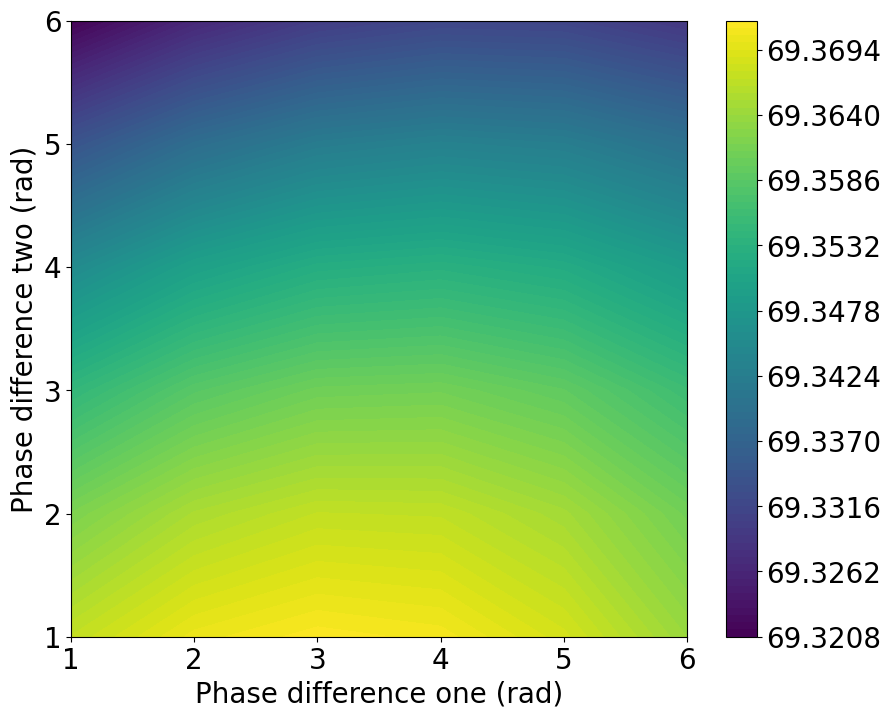

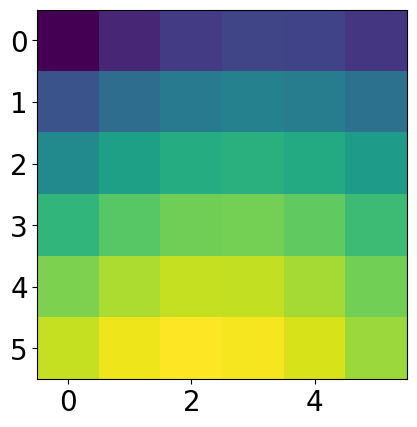

In [ ]:
#@title Contour Plotting
plt.rcParams.update({'font.size': 20})
#effct = [[82.69017730095347, 81.86467849206653, 80.3533724317815, 78.74748706862309, 77.21599012476084, 75.80437470968738, 74.51807789350856, 73.34900380935298, 72.28522187536032, 71.31460409009581, 70.4259342566765, 69.60937630304865, 68.85624783995404, 68.15915718960908, 67.51194417739448, 66.90901858936729, 66.34577038139179, 65.81813264642639, 65.32257726363386], [81.86443297693988, 82.69011164112864, 82.27106718035037, 81.39278547389569, 80.35339648212887, 79.27901375953087, 78.22515235671872, 77.21592932380078, 76.26077523607741, 75.36189634089918, 74.51809734720985, 73.72640621435677, 72.98331169454914, 72.28525188460185, 71.62853539787928, 71.00983291621942, 70.42598205626719, 69.87411342309959, 69.35164542918537], [80.35296375538606, 82.27089094114123, 82.69016991856208, 82.43719387936837, 81.86467745834473, 81.14127989114495, 80.35336796360475, 79.5470937505437, 78.74747850540942, 77.96811551856963, 77.21598618881028, 76.49430275299426, 75.8043735102896, 75.14589327911453, 74.51807686536841, 73.91960958483924, 73.34900539231406, 72.80473566632308, 72.28522112276414], [78.74696122931857, 81.39248003752093, 82.43705854249374, 82.69014409096293, 82.52100207247388, 82.11868984202614, 81.5873086878352, 80.98692262085045, 80.35342163175781, 79.70847122336485, 79.06549253795845, 78.43284192473405, 77.81535661803998, 77.21595929355054, 76.63614864695909, 76.07654740622071, 75.53723913488078, 75.01790220940055, 74.51806538725499], [77.21537756370104, 80.35299524524069, 81.86443195460915, 82.5208848704879, 82.6901112311181, 82.56907495927008, 82.27107303874502, 81.86468632607117, 81.39278295601434, 80.88292624617267, 80.35340294572896, 79.81607537183203, 79.27901094414337, 78.74753267037683, 78.22515087818392, 77.71414722415156, 77.2159288123901, 76.73135984379934, 76.26076591239969], [75.80369441503883, 79.27851850250147, 81.14094532301421, 82.11848566765906, 82.56898072622157, 82.69009586777095, 82.5992978820828, 82.3697545717365, 82.04893676289508, 81.6685664548182, 81.2500149936094, 80.8081734443135, 80.35340682164527, 79.8929836101475, 79.4320829998808, 78.97433766576786, 78.52236235780407, 78.07787079183439, 77.64223785921448], [74.51734277309968, 78.22459545826182, 80.3529605525499, 81.58702549518051, 82.27089790930494, 82.59921718874233, 82.69017730095347, 82.61939091997343, 82.43719267037393, 82.17764051578278, 81.86467849206653, 81.51517619335694, 81.14128342536998, 80.75185549796727, 80.3533724317815, 79.95063059756072, 79.54709063988737, 79.14551957742916, 78.74748706862309], [73.34822424824246, 77.21531694979014, 79.54662325197786, 80.98657328374253, 81.86445744434293, 82.36960194461645, 82.61931922358416, 82.69014716840472, 82.63352733480501, 82.48537682998305, 82.27112700895348, 82.00916814583553, 81.71302905116174, 81.39272527501691, 81.0558048214655, 80.70789961619805, 80.35346646675976, 79.99544122701391, 79.63668721168702], [72.28440487101086, 76.26011649085483, 78.74695410364201, 80.35299790551946, 81.39247609402538, 82.0487189515956, 82.43705737552219, 82.63346383010047, 82.69014003454309, 82.64382794334236, 82.5209939580934, 82.34112257768612, 82.11868677312047, 81.86466293587658, 81.58730962702501, 81.29319621408341, 80.986922881712, 80.67271158780355, 80.3534070539887], [71.3137479411546, 75.36119684400362, 77.96754381986233, 79.70801138290996, 80.88256481681894, 81.66829411557087, 82.1774467421223, 82.48525544348443, 82.64375833652198, 82.69014553558853, 82.65152431033238, 82.54803682955114, 82.39492310571165, 82.20371204347754, 81.98355668537845, 81.74104150731152, 81.48199347227812, 81.2106604847322, 80.93035661408624], [70.42505829674717, 74.51736243181935, 77.21537237883085, 79.06498825625302, 80.35299415258226, 81.24969257968432, 81.86443297693988, 82.27095212789291, 82.52088346420838, 82.6514709744888, 82.69011164112864, 82.65744075763712, 82.56907386385967, 82.43725943751821, 82.27106718035037, 82.07829475973156, 81.86468838254898, 81.63491575744702, 81.39278547389569], [69.60847872430347, 73.72564021196013, 76.4936543796829, 78.43229646064128, 79.81562429792265, 80.80781315437945, 81.51487303978932, 82.00894554042686, 82.34097386747354, 82.54793387225305, 82.65739242209429, 82.69009767863584, 82.6621928198063, 82.58576329489661, 82.47094404567859, 82.32539618433475, 82.15525230640365, 81.96557740466747, 81.76039567698672], [68.85532921496727, 72.98250707391585, 75.80369323215524, 77.8147641387791, 79.27852130843786, 80.35299863388697, 81.14094942119277, 81.71276310379356, 82.11848135626866, 82.39477575162879, 82.56898039262856, 82.66214799471433, 82.69009010393684, 82.66582075458284, 82.59929515876574, 82.49842748883856, 82.36975767671858, 82.21848199026101, 82.04892716001083], [68.15822616667158, 72.28443505683589, 75.14518343645537, 77.21534595915354, 78.7470072290521, 79.89253879240036, 80.75148190713935, 81.39241338906139, 81.86441770369791, 82.2035239690725, 82.43711514760965, 82.58567626290737, 82.66578690395748, 82.69013725281062, 82.66890838579955, 82.6103281528002, 82.52100709399355, 82.40641599247157, 82.27112107542473], [67.51099049056116, 71.62770978208016, 74.51734301919271, 76.63550710007829, 78.22459401094001, 79.43160461674535, 80.35296375538606, 81.05546247147201, 81.58702701164235, 81.98332868735409, 82.27089094114123, 82.47081771175, 82.59921485346436, 82.66887644086486, 82.69016991856208, 82.6714004957426, 82.61939029159281, 82.53981153857362, 82.43719387936837], [66.90805275912597, 71.00897019096747, 73.9188506544356, 76.07587946139675, 77.71356228029252, 78.97382651580014, 79.95019011701541, 80.70752313272315, 81.29287800392864, 81.74077845571439, 82.07808335372358, 82.32523257847497, 82.4983164631099, 82.61025079302107, 82.67136343382492, 82.69011056114277, 82.67348236039986, 82.62707469967026, 82.55563047765456], [66.34478988182732, 70.42510238700972, 73.34822666494844, 75.5365470076916, 77.21531635169234, 78.52182337530071, 79.54662880113365, 80.35305865747063, 80.9865717459424, 81.48169772995135, 81.86445922492612, 82.15505454557929, 82.36960577842277, 82.52089544173258, 82.61931909754524, 82.67344615393286, 82.69013964709548, 82.67521144024357, 82.63352306403698], [65.81713947087223, 69.87322278346451, 72.80393706373562, 75.01718834820277, 76.73072238501793, 78.07730506131944, 79.14502097129345, 79.99500303989133, 80.67233197501918, 81.21033371618262, 81.634640849467, 81.96534860531501, 82.21829643109626, 82.406271696462, 82.53970732520689, 82.62700746158154, 82.67517923436462, 82.69012985860165, 82.67670160292624], [65.32157957515162, 69.3507416145942, 72.28440458955558, 74.51733005713604, 76.26010755029392, 77.64164820721015, 78.74696122931857, 79.63622202296335, 80.35299143380358, 80.93000151890062, 81.39248003752093, 81.76013543725685, 82.04871101583389, 82.27094677316164, 82.43705854249374, 82.55553081198912, 82.6334588039649, 82.67667005793389, 82.69014409096293]]
effct2p = [[82.69017730095347, 81.86467849206653, 80.3533724317815, 78.74748706862309, 77.21599012476084, 75.80437470968738, 74.51807789350856, 73.34900380935298, 72.28522187536032, 71.31460409009581, 70.4259342566765, 69.60937630304865, 68.85624783995404, 68.15915718960908, 67.51194417739448, 66.90901858936729, 66.34577038139179, 65.81813264642639, 65.32257726363386], [81.86443297693988, 82.69011164112864, 82.27106718035037, 81.39278547389569, 80.35339648212887, 79.27901375953087, 78.22515235671872, 77.21592932380078, 76.26077523607741, 75.36189634089918, 74.51809734720985, 73.72640621435677, 72.98331169454914, 72.28525188460185, 71.62853539787928, 71.00983291621942, 70.42598205626719, 69.87411342309959, 69.35164542918537], [80.35296375538606, 82.27089094114123, 82.69016991856208, 82.43719387936837, 81.86467745834473, 81.14127989114495, 80.35336796360475, 79.5470937505437, 78.74747850540942, 77.96811551856963, 77.21598618881028, 76.49430275299426, 75.8043735102896, 75.14589327911453, 74.51807686536841, 73.91960958483924, 73.34900539231406, 72.80473566632308, 72.28522112276414], [78.74696122931857, 81.39248003752093, 82.43705854249374, 82.69014409096293, 82.52100207247388, 82.11868984202614, 81.5873086878352, 80.98692262085045, 80.35342163175781, 79.70847122336485, 79.06549253795845, 78.43284192473405, 77.81535661803998, 77.21595929355054, 76.63614864695909, 76.07654740622071, 75.53723913488078, 75.01790220940055, 74.51806538725499], [77.21537756370104, 80.35299524524069, 81.86443195460915, 82.5208848704879, 82.6901112311181, 82.56907495927008, 82.27107303874502, 81.86468632607117, 81.39278295601434, 80.88292624617267, 80.35340294572896, 79.81607537183203, 79.27901094414337, 78.74753267037683, 78.22515087818392, 77.71414722415156, 77.2159288123901, 76.73135984379934, 76.26076591239969], [75.80369441503883, 79.27851850250147, 81.14094532301421, 82.11848566765906, 82.56898072622157, 82.69009586777095, 82.5992978820828, 82.3697545717365, 82.04893676289508, 81.6685664548182, 81.2500149936094, 80.8081734443135, 80.35340682164527, 79.8929836101475, 79.4320829998808, 78.97433766576786, 78.52236235780407, 78.07787079183439, 77.64223785921448], [74.51734277309968, 78.22459545826182, 80.3529605525499, 81.58702549518051, 82.27089790930494, 82.59921718874233, 82.69017730095347, 82.61939091997343, 82.43719267037393, 82.17764051578278, 81.86467849206653, 81.51517619335694, 81.14128342536998, 80.75185549796727, 80.3533724317815, 79.95063059756072, 79.54709063988737, 79.14551957742916, 78.74748706862309], [73.34822424824246, 77.21531694979014, 79.54662325197786, 80.98657328374253, 81.86445744434293, 82.36960194461645, 82.61931922358416, 82.69014716840472, 82.63352733480501, 82.48537682998305, 82.27112700895348, 82.00916814583553, 81.71302905116174, 81.39272527501691, 81.0558048214655, 80.70789961619805, 80.35346646675976, 79.99544122701391, 79.63668721168702], [72.28440487101086, 76.26011649085483, 78.74695410364201, 80.35299790551946, 81.39247609402538, 82.0487189515956, 82.43705737552219, 82.63346383010047, 82.69014003454309, 82.64382794334236, 82.5209939580934, 82.34112257768612, 82.11868677312047, 81.86466293587658, 81.58730962702501, 81.29319621408341, 80.986922881712, 80.67271158780355, 80.3534070539887], [71.3137479411546, 75.36119684400362, 77.96754381986233, 79.70801138290996, 80.88256481681894, 81.66829411557087, 82.1774467421223, 82.48525544348443, 82.64375833652198, 82.69014553558853, 82.65152431033238, 82.54803682955114, 82.39492310571165, 82.20371204347754, 81.98355668537845, 81.74104150731152, 81.48199347227812, 81.2106604847322, 80.93035661408624], [70.42505829674717, 74.51736243181935, 77.21537237883085, 79.06498825625302, 80.35299415258226, 81.24969257968432, 81.86443297693988, 82.27095212789291, 82.52088346420838, 82.6514709744888, 82.69011164112864, 82.65744075763712, 82.56907386385967, 82.43725943751821, 82.27106718035037, 82.07829475973156, 81.86468838254898, 81.63491575744702, 81.39278547389569], [69.60847872430347, 73.72564021196013, 76.4936543796829, 78.43229646064128, 79.81562429792265, 80.80781315437945, 81.51487303978932, 82.00894554042686, 82.34097386747354, 82.54793387225305, 82.65739242209429, 82.69009767863584, 82.6621928198063, 82.58576329489661, 82.47094404567859, 82.32539618433475, 82.15525230640365, 81.96557740466747, 81.76039567698672], [68.85532921496727, 72.98250707391585, 75.80369323215524, 77.8147641387791, 79.27852130843786, 80.35299863388697, 81.14094942119277, 81.71276310379356, 82.11848135626866, 82.39477575162879, 82.56898039262856, 82.66214799471433, 82.69009010393684, 82.66582075458284, 82.59929515876574, 82.49842748883856, 82.36975767671858, 82.21848199026101, 82.04892716001083], [68.15822616667158, 72.28443505683589, 75.14518343645537, 77.21534595915354, 78.7470072290521, 79.89253879240036, 80.75148190713935, 81.39241338906139, 81.86441770369791, 82.2035239690725, 82.43711514760965, 82.58567626290737, 82.66578690395748, 82.69013725281062, 82.66890838579955, 82.6103281528002, 82.52100709399355, 82.40641599247157, 82.27112107542473], [67.51099049056116, 71.62770978208016, 74.51734301919271, 76.63550710007829, 78.22459401094001, 79.43160461674535, 80.35296375538606, 81.05546247147201, 81.58702701164235, 81.98332868735409, 82.27089094114123, 82.47081771175, 82.59921485346436, 82.66887644086486, 82.69016991856208, 82.6714004957426, 82.61939029159281, 82.53981153857362, 82.43719387936837], [66.90805275912597, 71.00897019096747, 73.9188506544356, 76.07587946139675, 77.71356228029252, 78.97382651580014, 79.95019011701541, 80.70752313272315, 81.29287800392864, 81.74077845571439, 82.07808335372358, 82.32523257847497, 82.4983164631099, 82.61025079302107, 82.67136343382492, 82.69011056114277, 82.67348236039986, 82.62707469967026, 82.55563047765456], [66.34478988182732, 70.42510238700972, 73.34822666494844, 75.5365470076916, 77.21531635169234, 78.52182337530071, 79.54662880113365, 80.35305865747063, 80.9865717459424, 81.48169772995135, 81.86445922492612, 82.15505454557929, 82.36960577842277, 82.52089544173258, 82.61931909754524, 82.67344615393286, 82.69013964709548, 82.67521144024357, 82.63352306403698], [65.81713947087223, 69.87322278346451, 72.80393706373562, 75.01718834820277, 76.73072238501793, 78.07730506131944, 79.14502097129345, 79.99500303989133, 80.67233197501918, 81.21033371618262, 81.634640849467, 81.96534860531501, 82.21829643109626, 82.406271696462, 82.53970732520689, 82.62700746158154, 82.67517923436462, 82.69012985860165, 82.67670160292624], [65.32157957515162, 69.3507416145942, 72.28440458955558, 74.51733005713604, 76.26010755029392, 77.64164820721015, 78.74696122931857, 79.63622202296335, 80.35299143380358, 80.93000151890062, 81.39248003752093, 81.76013543725685, 82.04871101583389, 82.27094677316164, 82.43705854249374, 82.55553081198912, 82.6334588039649, 82.67667005793389, 82.69014409096293]]
effct2b = [[83.66337455202645, 83.46399940340284, 82.95911776888923, 82.23855269803117, 81.37168020974747, 80.4110246536992, 79.39582999332295, 78.3547518935148, 77.30860803491304, 76.27225812008513, 75.2558499069474, 74.26640103198152, 73.3083665730675, 72.38457826597168, 71.49644634116203, 70.64459418317456, 69.82906542026053, 69.04947738274969, 68.30518423337682, 67.5954960931266, 66.91946530067278], [83.46399378473978, 83.64028635457656, 83.4712395881063, 83.04268505310304, 82.42429180682645, 81.67142553507549, 80.82709103630177, 79.9245299579975, 78.98884028676984, 78.039005253688, 77.0888857678108, 76.14878931758003, 75.22592233914452, 74.32559683525838, 73.45118697156249, 72.60516059518851, 71.78901110964416, 71.00356892692568, 70.24927512913057, 69.52635842330075, 68.83453947535662], [82.95911160949943, 83.47123946157015, 83.61493915611942, 83.46896344838497, 83.09998619877116, 82.56320196173563, 81.9031093054243, 81.155611233487, 80.34876391773022, 79.50454513295801, 78.63993795677881, 77.7678619796071, 76.89820720223523, 76.03832279132924, 75.19371702252555, 74.36846747779174, 73.56554903527167, 72.78705890144998, 72.03461705011995, 71.30929410509152, 70.61168920103444], [82.23854641738485, 83.0426848274483, 83.4689632957389, 83.58728693271125, 83.45925129590043, 83.13763945845352, 82.66678206396423, 82.08329643024072, 81.41699592168669, 80.69180365862096, 79.92703611738709, 79.13769776453842, 78.33586849265187, 77.530820274663, 76.7297300305039, 75.93834675606132, 75.16104927062361, 74.40120430008432, 73.6614483357775, 72.94384435036953, 72.24990420994513], [81.37168033189566, 82.42430346941248, 83.09998545931279, 83.4592507995167, 83.5574326338298, 83.44348991498234, 83.16008062263072, 82.74334795632781, 82.22350113293965, 81.62581798374188, 80.97072447471433, 80.27504587531217, 79.55235481290515, 78.81365693057616, 78.06756007694369, 77.32118601178374, 76.58024465219903, 75.84927546471121, 75.13198903804764, 74.43130198163614, 73.74954082520442], [80.41101820635846, 81.67142561581385, 82.56319548305302, 83.13763907021475, 83.44348979116296, 83.52526383396027, 83.42267296813294, 83.17043193656995, 82.79847914852253, 82.33218876611205, 81.79280387581672, 81.19817397672158, 80.56296731314384, 79.89941049135166, 79.21735992371902, 78.52519647412926, 77.82971727085167, 77.1364235838459, 76.4500954321297, 75.77447808901542, 75.11271162595006], [79.39583534008369, 80.82707900968043, 81.90310346846769, 82.66678178764084, 83.16006825729183, 83.42266730400738, 83.49092058862068, 83.39748672849773, 83.1709882849866, 82.8365121212442, 82.41546873852043, 81.92612393274217, 81.3839528413077, 80.80186878706859, 80.19080566098626, 79.56006559270332, 78.91733040677433, 78.26913552937172, 77.62100763162522, 76.97753320857719, 76.3426254310993], [78.3547515316158, 79.92452973225292, 81.15561146827199, 82.08329602882989, 82.74334825762445, 83.17043294340331, 83.3974888414455, 83.45435279477654, 83.36829900464197, 83.16328799191555, 82.86047938584284, 82.47802393863978, 82.03188433303362, 81.53545134114067, 81.00025133232232, 80.43634697320513, 79.85216368905608, 79.25496201826631, 78.6510495926329, 78.04571517800973, 77.44345336844928], [77.30860754376437, 78.9888341767897, 80.34876978020911, 81.41699611552873, 82.22350264485503, 82.79848269840485, 83.17099378109263, 83.36830415388499, 83.41558758897641, 83.33556111821908, 83.14863641757704, 82.87264155159168, 82.52346613188973, 82.11481692633969, 81.65854384862268, 81.16520730506498, 80.64376290901593, 80.10211475975547, 79.54713658279955, 78.98474039239358, 78.4201323820078], [76.27225657131756, 78.0390041364586, 79.50452674308184, 80.69180396951953, 81.62581949173318, 82.33219570641735, 82.83652340337213, 83.16330324531455, 83.335574343874, 83.37455609065722, 83.29950281591164, 83.12772067943021, 82.87481289880404, 82.55438725610898, 82.1784808128519, 81.75793155084804, 81.30212907821357, 80.81929086651216, 80.31683577497121, 79.80119368135213, 79.27800061811958], [75.2558411852713, 77.08888287777219, 78.63993466404266, 79.92703567413811, 80.97072785168957, 81.79280863454579, 82.41549103552569, 82.8605139769314, 83.14867642820218, 83.29953346080889, 83.33115188088789, 83.26009603943146, 83.10136773987044, 82.86820979560177, 82.57280645148983, 82.22592688905081, 81.83727159415449, 81.41531540164655, 80.96794835034473, 80.5018527820758, 80.02308543307574], [74.26639372475901, 76.14878265427754, 77.76786125061655, 79.13769307460632, 80.27504740040634, 81.19818363424314, 81.9261532768615, 82.47808912370434, 82.87271942890759, 83.12780418294437, 83.26015527789723, 83.28532412403564, 83.21746815914865, 83.06962824478443, 82.8536396518185, 82.58025811031663, 82.25921936345823, 81.89931144051752, 81.50834804615829, 81.09358706013376, 80.66141162510276], [73.30835111580322, 75.22590733826067, 76.89819245461706, 78.33585749012009, 79.552353134599, 80.56298586638552, 81.38400341972618, 82.03197634747443, 82.52359667276907, 82.87496332499393, 83.1015134385064, 83.21757160617238, 83.23665877649078, 83.1712150776233, 83.03271740080388, 82.83168974859605, 82.57777811417616, 82.27993449375437, 81.94609316134861, 81.58369096759793, 81.19929204213946], [72.38454154122343, 74.32556601316092, 76.03828681227249, 77.53079441164343, 78.81364481618499, 79.8994272665857, 80.80193299789136, 81.53557968803219, 82.11500192653301, 82.55463388867244, 82.86848663866856, 83.06989224765475, 83.1713695616981, 83.1847097062151, 83.1210436786518, 82.99043804060003, 82.80253367108057, 82.56609433740245, 82.28917375454898, 81.97936398570904, 81.64318882423849], [71.49638978403624, 73.45113123764541, 75.19366148852488, 76.72968043577376, 78.06752840185315, 79.21736807252351, 80.1908798522679, 81.00041710750783, 81.65881457760594, 82.17884827497862, 82.5732450568688, 82.85408432481147, 83.03309898998909, 83.12127987407126, 83.12915380061683, 83.0664871256897, 82.94271543313076, 82.76632493200633, 82.54552059415218, 82.2877401536495, 81.99990497263909], [70.64449864334138, 72.60506446023173, 74.36836212665224, 75.93826037533643, 77.32112197993905, 78.52518400174702, 79.5601355934858, 80.43654669725278, 81.16555496716236, 81.75843333337221, 82.22654100100273, 82.58092919026838, 82.83234126789742, 82.99097903347348, 83.06680881259106, 83.06926211321549, 83.00710920999308, 82.88899740177158, 82.7229585629236, 82.5163226940523, 82.2761273622301], [69.82891268133756, 71.78885902481906, 73.56538253010453, 75.16090781371877, 76.58013148230424, 77.8296746823695, 78.91739339738983, 79.85238894235232, 80.64418610764186, 81.30275997086565, 81.83808476371817, 82.2601592942233, 82.57875548163501, 82.8034411021635, 82.94343204249247, 83.0075265180412, 83.00444340855157, 82.942469487825, 82.82925153331682, 82.67233027428954, 82.47861577364883], [69.0492461393494, 71.00333844520148, 72.78682610006415, 74.40098677387495, 75.84909254701381, 77.13631932074654, 78.26917000735159, 79.25520057582642, 80.10260650304261, 80.82005653871038, 81.41634515350601, 81.90054155102965, 82.28126917606406, 82.56742181576814, 82.76751431787922, 82.88991562770563, 82.94298612941662, 82.93442260007316, 82.87200976268376, 82.7631050557607, 82.61450525791018], [68.30485274908044, 70.24894347034737, 72.03428714927813, 73.66113118616151, 75.13171314659304, 76.44991382943405, 77.62099836026375, 78.6512826350463, 79.54768362274788, 80.31773104216504, 80.96918524183508, 81.5098718577836, 81.94780923225657, 82.2909628249796, 82.54723565475983, 82.72444521866697, 82.83036967012801, 82.8726274626264, 82.85871629646775, 82.7957751304949, 82.69060817940593], [67.59504288511124, 69.52590076167155, 71.3088392479037, 72.94340467361089, 74.43090787146845, 75.77419458866075, 76.97744108803286, 78.04591142055705, 78.98532624282151, 79.80220738399582, 80.50329696514031, 81.09541223193155, 81.58580248904043, 81.98164166859982, 82.29001377597372, 82.51844159820202, 82.67411530202759, 82.76442029124277, 82.79649509159779, 82.77730191014895, 82.71357102579768], [66.91885518451018, 68.83392884702715, 70.61108194864295, 72.24930716142373, 73.74900422011696, 75.112305917884, 76.34244110341638, 77.44361130138813, 78.42073599239372, 79.27911551102864, 80.02473836717616, 80.66353534671158, 81.20180416072515, 81.64594955399625, 82.0027614499421, 82.2788930889956, 82.48111920112655, 82.61658292630308, 82.69211218513348, 82.7143755434076, 82.69014409096293]]
effct2pl = [[82.69014409096293, 81.65548765505213, 80.59323380336556, 79.5010341580182, 78.37621069471935, 77.21565151876067, 76.01572075136616, 74.77211065047133, 73.47967910667711, 72.13217335753745, 70.72189388138864, 69.23915645498326, 67.67148481596756, 66.00236607126841, 64.20911447175618, 62.25906525288975, 60.102099630974024, 57.65383519063296, 54.7497383982167, 50.965043695554456, 41.82856734952873], [81.65548817515514, 82.69013877594652, 82.50106494277563, 82.08589638399692, 81.5370017827178, 80.88814119753054, 80.15463721505924, 79.3435005142298, 78.45702054326595, 77.49417444102139, 76.45115534605324, 75.32130955180325, 74.0946441236313, 72.75678519755498, 71.2870193225683, 69.65465982078722, 67.81181788489253, 65.6770634490972, 63.09072248793638, 59.639386245173384, 50.96560706513442], [80.59323367888716, 82.50106492655553, 82.69014582028284, 82.57235112709364, 82.27945809804234, 81.86054853871822, 81.33885382642713, 80.72613776164148, 80.02785140502908, 79.24523564106065, 78.37621042286581, 77.41553095622717, 76.35442676564438, 75.17966439286542, 73.87169952639661, 72.4011729870359, 70.72189660284938, 68.75496826040062, 66.3452838783734, 63.09072276388118, 54.75028612934171], [79.50103510111461, 82.08589662757613, 82.57235076519335, 82.69014392476794, 82.60131639950966, 82.36672497311261, 82.01569340894459, 81.56366617502867, 81.01854894585443, 80.3833658144367, 79.65741525297479, 78.83659722459329, 77.91316258624512, 76.87486760338662, 75.70321823986589, 74.37009447823111, 72.83095289526914, 71.00940597050668, 68.75496865395682, 65.67706244956788, 57.654366952578954], [78.3762093328693, 81.53700175000726, 82.27945872412027, 82.60131782704669, 82.69014054241457, 82.61673056518812, 82.41556821128799, 82.10521612532301, 81.69568231826418, 81.19152001114568, 80.59323005345466, 79.89772482910192, 79.09817937428193, 78.1832682158152, 77.13549345071975, 75.92794283631392, 74.51771095903284, 72.8309530698302, 70.72189587034146, 67.81181725817147, 60.1026162949563], [77.21565183471564, 80.88814169148773, 81.86054800098805, 82.36672420207685, 82.61673060392131, 82.69014162712716, 82.62599357495128, 82.4456232917237, 82.16090329210878, 81.77776443949611, 81.2977960156851, 80.71884653599682, 80.03495636297922, 79.23567378277698, 78.30447655343585, 77.21565085377614, 75.92794291865049, 74.37009460696521, 72.4011732663313, 69.65465917524206, 62.259566098752074], [76.01571988550356, 80.15463671346349, 81.33885349483478, 82.0156936042717, 82.415567815307, 82.6259945742466, 82.69014497127473, 82.63187184417973, 82.46475956502232, 82.19600392670834, 81.82820965027126, 81.36010307516118, 80.78655492171836, 80.09796354199243, 79.27877430438403, 78.30447665753039, 77.13549313213113, 75.70321878245055, 73.8716997880578, 71.28701856876796, 64.20959763315062], [74.77211206542162, 79.34350095997299, 80.7261383957893, 81.56366587867409, 82.10521694136844, 82.44562290813235, 82.63187145067215, 82.69014445490271, 82.63561564433012, 82.47666806359975, 82.21686567054489, 81.8557757862072, 81.38907405796057, 80.8080007546041, 80.09796321425476, 79.23567347589903, 78.18326728875307, 76.87486808807522, 75.1796644588802, 72.75678547144621, 66.00283247822844], [73.47967921510288, 78.457019064265, 80.02785081447723, 81.01854903097595, 81.69568278111143, 82.1609040368047, 82.46475921671338, 82.63561603930334, 82.69014559034188, 82.63785352112959, 82.4832230104419, 82.22663689748705, 81.86456211426798, 81.38907403864566, 80.78655439128107, 80.0349570842856, 79.09817946050963, 77.91316218273248, 76.35442610619405, 74.09464395672502, 67.67193253193221], [72.1321723444381, 77.49417421220764, 79.24523544930344, 80.38336675374138, 81.19152085404936, 81.77776382664389, 82.19600412158844, 82.4766688884881, 82.63785411172745, 82.69014313837215, 82.63890301019325, 82.4853194039498, 82.22663707591852, 81.85577614103995, 81.36010364860597, 80.71884697394843, 79.89772445405113, 78.83659665094234, 77.41553112149467, 75.32130959064389, 69.23958468956857], [70.72189383681739, 76.45115616590238, 78.37621096610626, 79.65741620417064, 80.59322986079658, 81.29779649870014, 81.8282096585406, 82.21686575014479, 82.48322308731295, 82.63890324883839, 82.69014035395112, 82.63890324883839, 82.48322308731295, 82.21686575014479, 81.8282096585406, 81.29779649870014, 80.59322986079658, 79.65741620417064, 78.37621096610626, 76.45115616590238, 70.72230258827881], [69.23915596408861, 75.32130959064389, 77.41553112149467, 78.83659665094234, 79.89772445405113, 80.71884697394843, 81.36010364860597, 81.85577614103995, 82.22663707591852, 82.4853194039498, 82.63890301019325, 82.69014313837215, 82.63785411172745, 82.4766688884881, 82.19600412158844, 81.77776382664389, 81.19152085404936, 80.38336675374138, 79.24523544930344, 77.49417421220764, 72.13255984072478], [67.67148507643196, 74.09464395672502, 76.35442610619405, 77.91316218273248, 79.09817946050963, 80.0349570842856, 80.78655439128107, 81.38907403864566, 81.86456211426798, 82.22663689748705, 82.4832230104419, 82.63785352112959, 82.69014559034188, 82.63561603930334, 82.46475921671338, 82.1609040368047, 81.69568278111143, 81.01854903097595, 80.02785081447723, 78.457019064265, 73.48004477914373], [66.00236637505931, 72.75678547144621, 75.1796644588802, 76.87486808807522, 78.18326728875307, 79.23567347589903, 80.09796321425476, 80.8080007546041, 81.38907405796057, 81.8557757862072, 82.21686567054489, 82.47666806359975, 82.63561564433012, 82.69014445490271, 82.63187145067215, 82.44562290813235, 82.10521694136844, 81.56366587867409, 80.7261383957893, 79.34350095997299, 74.77245391866452], [64.2091142520439, 71.28701856876796, 73.8716997880578, 75.70321878245055, 77.13549313213113, 78.30447665753039, 79.27877430438403, 80.09796354199243, 80.78655492171836, 81.36010307516118, 81.82820965027126, 82.19600392670834, 82.46475956502232, 82.63187184417973, 82.69014497127473, 82.6259945742466, 82.415567815307, 82.0156936042717, 81.33885349483478, 80.15463671346349, 76.01603637841349], [62.25906537876372, 69.65465917524206, 72.4011732663313, 74.37009460696521, 75.92794291865049, 77.21565085377614, 78.30447655343585, 79.23567378277698, 80.03495636297922, 80.71884653599682, 81.2977960156851, 81.77776443949611, 82.16090329210878, 82.4456232917237, 82.62599357495128, 82.69014162712716, 82.61673060392131, 82.36672420207685, 81.86054800098805, 80.88814169148773, 77.21594069335485], [60.102099611187434, 67.81181725817147, 70.72189587034146, 72.8309530698302, 74.51771095903284, 75.92794283631392, 77.13549345071975, 78.1832682158152, 79.09817937428193, 79.89772482910192, 80.59323005345466, 81.19152001114568, 81.69568231826418, 82.10521612532301, 82.41556821128799, 82.61673056518812, 82.69014054241457, 82.60131782704669, 82.27945872412027, 81.53700175000726, 78.37646776957557], [57.65383417002168, 65.67706244956788, 68.75496865395682, 71.00940597050668, 72.83095289526914, 74.37009447823111, 75.70321823986589, 76.87486760338662, 77.91316258624512, 78.83659722459329, 79.65741525297479, 80.3833658144367, 81.01854894585443, 81.56366617502867, 82.01569340894459, 82.36672497311261, 82.60131639950966, 82.69014392476794, 82.57235076519335, 82.08589662757613, 79.50125885530463], [54.74973791744427, 63.09072276388118, 66.3452838783734, 68.75496826040062, 70.72189660284938, 72.4011729870359, 73.87169952639661, 75.17966439286542, 76.35442676564438, 77.41553095622717, 78.37621042286581, 79.24523564106065, 80.02785140502908, 80.72613776164148, 81.33885382642713, 81.86054853871822, 82.27945809804234, 82.57235112709364, 82.69014582028284, 82.50106492655553, 80.59341644023665], [50.96504393574245, 59.639386245173384, 63.09072248793638, 65.6770634490972, 67.81181788489253, 69.65465982078722, 71.2870193225683, 72.75678519755498, 74.0946441236313, 75.32130955180325, 76.45115534605324, 77.49417444102139, 78.45702054326595, 79.3435005142298, 80.15463721505924, 80.88814119753054, 81.5370017827178, 82.08589638399692, 82.50106494277563, 82.69013877594652, 81.6556173861009], [41.828567786925795, 50.96560673861944, 54.7502863420022, 57.6543677993058, 60.10261647770783, 62.25956571926285, 64.20959802991037, 66.00283196936776, 67.67193236046349, 69.23958484322297, 70.72230246010696, 72.13256098902832, 73.48004457042776, 74.77245249563488, 76.01603728118087, 77.21594043108918, 78.37646910467274, 79.50125795878583, 80.5934165281457, 81.65561688196877, 82.69014410750096]]
#effct4b = [[20.98426982171358, 24.653791242295604, 27.755690634994696, 30.012884960125746, 31.22374541937008, 31.280110067535773, 30.176943649510445, 28.012788873499723, 24.980963403150973, 21.352290260832994], [16.40683906552744, 19.922333920788244, 23.071706595976554, 25.57363303709142, 27.204623395649453, 27.818986935873834, 27.361843421821312, 25.8740288807801, 23.488445565260175, 20.418189219481576], [11.866357937044095, 15.040085278519136, 18.03543145612937, 20.58483090642084, 22.460553314534074, 23.495046739044152, 23.59590192130089, 22.754110684063136, 21.044867540951152, 18.620853266188053], [7.768414617002652, 10.443162857441612, 13.09674160965965, 15.492114663772224, 17.415310197826443, 18.694535687329875, 19.215520777240375, 18.931728137964093, 17.868508125527278, 16.120834266328494], [4.479065889258234, 6.542195466781002, 8.696794986606173, 10.750400592741757, 12.519569680987175, 13.846268168713186, 14.611985284366124, 14.748322433322675, 14.243101070579673, 13.141450370358504], [2.2921393921269506, 3.685644844366788, 5.228625715519625, 6.783252145904594, 8.210653891284267, 9.38332580753433, 10.196516128508577, 10.577585296641512, 10.492493896494135, 9.94884189331209], [1.4029871630921231, 2.1286786507774833, 3.002035457316698, 3.945043230194668, 4.873465842081877, 5.704370386830317, 6.363534184680077, 6.792076419058775, 6.951716933251132, 6.828194817652728], [1.8910341234073136, 2.010375646762957, 2.2159184187858654, 2.4893022329056786, 2.806106175011602, 3.1380315282135816, 3.45542795336427, 3.7299437510069477, 3.937057291424536, 4.058267254012484], [3.712684611526825, 3.3413034935222865, 2.9404961491084847, 2.5460659575497804, 2.1932458766069574, 1.913552509575046, 1.7319699036727052, 1.664718313430107, 1.7178053623343654, 1.886488511643449], [6.705216369928293, 6.002574801230639, 5.111044809646471, 4.110264573481345, 3.089630498275829, 2.1403130170814495, 1.3471117057722781, 0.7808809475056744, 0.49220046638452103, 0.5068570952373659]]
#effct4b = [[8.254194334821806, 12.47540472832272, 17.374541262724343, 22.178137846400485, 26.127812082799846, 28.59999797616694, 29.204390631995274, 27.845571032753856, 24.73806590999585, 20.372482101108247, 15.438049476469082], [8.473626381173197, 12.422607769693714, 17.524273997633962, 22.973183573681233, 27.909073682427675, 31.55267618434379, 33.32874571811295, 32.956880870438745, 30.495790258735433, 26.334025623382345, 21.128638690628875], [8.242594830297723, 11.487567954942952, 16.317005184729727, 21.96844442123724, 27.54964756319663, 32.179466006872175, 35.12695228177434, 35.92676419756582, 34.45262841386511, 30.93727814483453, 25.935710330686558], [7.5975743993271605, 9.817907018943947, 13.94333572484118, 19.32254602451649, 25.106278857218552, 30.381410258083623, 34.3151123791067, 36.28634113581812, 35.983881828029666, 33.45548643705699, 29.100333121696075], [6.640399433109671, 7.677227722341525, 10.778015982522609, 15.453217872193479, 20.964721681868046, 26.44238257270001, 31.021397783603522, 33.97884217669362, 34.8477997604916, 33.49108096190774, 30.122882374043808], [5.522187499506738, 5.403496783853761, 7.320780789023449, 10.971342287229916, 15.77883777986558, 20.98426982171358, 25.765814596561786, 29.36857193650877, 31.22374541937008, 31.038443489205886, 28.84192181432543], [4.419478811880409, 3.3556858107201792, 4.117450927429908, 6.5845081130633725, 10.367363223081014, 14.868786746844846, 19.37810266661644, 23.183389506483813, 25.683875825470164, 26.484789653865942, 25.459684799319664], [3.506367585081989, 1.8570994901023836, 1.6737622002369323, 2.985300511413906, 5.584651428168641, 9.061434522810668, 12.86674209647617, 16.39980008110409, 19.1028159837752, 20.549042952791574, 20.51015388117272], [2.9270135537206436, 1.1443314208453805, 0.37551908170178677, 0.7419550538732634, 2.1857870800376706, 4.479065889258234, 7.259733027296401, 10.088782673283792, 12.519569680987175, 14.168326284511332, 14.774750206259016], [2.7728839144942894, 1.3299119910191592, 0.427685696247786, 0.20864665143434905, 0.7073762994705896, 1.8451362291721567, 3.442299088575227, 5.246708148716608, 6.973486736744997, 8.350014408647183, 9.158967940816758], [3.06831271318856, 2.3845423642908763, 1.8220261825420212, 1.4695731160518775, 1.382827675868659, 1.5754852615340846, 2.01712922395474, 2.6380339686162313, 3.3401720729405775, 4.012691334012397, 4.54941595561986]]
effct4b = [[69.36705555193329, 69.37026417973992, 69.37156187710276, 69.370948329749, 69.36842341631608, 69.36398719631194], [69.36164997495463, 69.36530191552471, 69.36704294822034, 69.36687277592557, 69.3647913156888, 69.36079855046778], [69.35433448308301, 69.358429616143, 69.36061383735935, 69.36088709413589, 69.35924897450829, 69.35569963777576], [69.34510951274109, 69.34964771001113, 69.35227518155686, 69.35299159756538, 69.35179682490568, 69.34869087783207], [69.33397603022307, 69.3389570637758, 69.34202759720742, 69.34318719708715, 69.34243565539533, 69.33977305351789], [69.32093469772698, 69.32635855187546, 69.32987198208565, 69.33147466882362, 69.33116628474863, 69.32894692110304]]

H = effct4b
fig = plt.figure(figsize=(10, 8))
H1 = H[::-1]
ax = fig.add_subplot(111)
x = np.linspace(1,6,6)
X,Y = np.meshgrid(x,x)
#ax.set_title('Efficiency contour plot')
plt.contourf(X,Y, H, 100) #81*np.divide(H,82.69)
#plt.contourf(H)
# plt.xlim(0,1)
# plt.ylim(0,1)
plt.colorbar()
plt.xlabel("Phase difference one (rad)")
plt.ylabel("Phase difference two (rad)")
#plt.clim(34, 83.14)
ax.set_aspect('equal')
plt.show()
plt.imshow(H1)

In [ ]:
print(np.where(effct4b==(np.max(effct4b))))

(array([2]), array([3]))


In [ ]:
#@title Four Beam Combining
#Four beam combining

ax= 0.5

n = 50
m = 1

print ("Estimated simulation time =", 0.13*m*n,"minutes")
axr = ax*np.pi/180
ds1= np.tan(axr)*z
rh1=np.sqrt((X-(ds1))**2+(Y-(ds1))**2)
th1 = np.arctan2(Y-(ds1),X-(ds1))
rh2=np.sqrt((X+(ds1))**2+(Y-(ds1))**2)
th2 = np.arctan2(Y-(ds1),X+(ds1))
rh3=np.sqrt((X+(ds1))**2+(Y+(ds1))**2)
th3 = np.arctan2(Y+(ds1),X+(ds1))
rh4=np.sqrt((X-(ds1))**2+(Y+(ds1))**2)
th4 = np.arctan2(Y+(ds1),X-(ds1))
# w01, w02, w03, w04 = 1.5, 1.5, 1.5, 1.5 #6.2/3,5.8/3,6/3,5.6/3
w0 = 2
#dp1, dp2, dp3, dp4= 0.4, 0.4, 0.4, 0.4
Rc1, Rc2, Rc3, Rc4 = 1e25, 1e25, 1e25, 1e25
# dp11, dp12, dp13 = 1, 1, 1
# dp14 = 1
dthaz = 0
pvareff = []
dpi = 1
Tpstd = 0.0
#dr = 0
dpw = 0.0
dpd = 0.0
thp = 0.00
dpol = 0.2
# dp13, dp14 = 1, 1
# dp11 = 1
lp =0 #0.4 * np.pi
#lp = (np.pi)/q
for j in range(m):
    #lp = (np.pi)
    print("Updated variable =", dpi)
    #dp13 = 0
    abc = []
    dr = 0
    # dp12 = 1
#t = np.linspace(1,n,1)
    for i in tqdm(range(n),ncols=120):
        ab = np.random.normal(0, dpol, 4)
        abr = np.clip(ab,-dpol,dpol)
        dw = [0, 0, 0, 0]
        #abr = [0, 0, 0, 0]
        lpf = np.random.normal(0,lp, 4)
        #print(dp11,dp12)
        dp01, dp02, dp03, dp04 = dpi + abr[0], dpi + abr[1], dpi + abr[2], dpi + abr[3]

        thpa = np.random.normal(0, thp, 4)
        w01, w02, w03, w04 = 2, 2, 2, 2 #w0 + abr[0], w0 + abr[1], w0 + abr[2], w0 + abr[3],

        dp11, dp12, dp13, dp14 = dp01, dp02, dp03, dp04
        dp21, dp22, dp23, dp24 = 0, 0, 0, 0 #dp01/2, dp02/2, dp03/2, dp04/2
        #print(dp11+dp21)
        TPA1 = 1 #TPA(rh1,th1, Tpstd)
        TPA2 = 1 #TPA(rh2,th2, Tpstd)
        TPA3 = 1 #TPA(rh3,th3, Tpstd)
        TPA4 = 1 #TPA(rh4,th4, Tpstd)
        ux1 = beam_generation2D(Rc1,w01,dp11,0.5,225,thpa[0],dthaz,1,1)*np.exp(1j*lpf[0]) * TPA1
        ux2 = beam_generation2D(Rc2,w02,dp12,0.5,315,thpa[1],dthaz,-1,1)*np.exp(1j*lpf[1]) * TPA2
        ux3 = beam_generation2D(Rc3,w03,dp13,0.5,45,thpa[2],dthaz,-1,-1)*np.exp(1j*lpf[2]) * TPA3
        ux4 = beam_generation2D(Rc4,w04,dp14,0.5,135,thpa[3],dthaz,1,-1)*np.exp(1j*lpf[3]) * TPA4

        # Tph = T.angle(ux1 + ux2 + ux3 + ux4)
        # Tphcpu =Tph.cpu().detach().numpy()
        uy1 = beam_generation2D(Rc1,w01+dw[0],dp21,0.5,225+dr,0,dthaz,1,1) * TPA1
        uy2 = beam_generation2D(Rc2,w02+dw[1],dp22,0.5,315+dr,0,dthaz,-1,1) * TPA2
        uy3 = beam_generation2D(Rc3,w03+dw[2],dp23,0.5,45+dr,0,dthaz,-1,-1) * TPA3
        uy4 = beam_generation2D(Rc4,w04+dw[3],dp24,0.5,135+dr,0,dthaz,1,-1) * TPA4

        uinx = ux1 + (ux2 * np.exp(1j*np.pi)) + ux3  + (ux4 * np.exp(1j*np.pi))

        uiny = uy1  + (uy2 * np.exp(1j*np.pi)) + uy3  + (uy4 * np.exp(1j*np.pi))

        iin = T.abs(uinx)**2 + T.abs(uiny)**2
        iicpu = iin.cpu().detach().numpy()
        uoutx = rs_propagation(uinx,600)
        uouty = rs_propagation(uiny,600)

        iin2 =T.abs(uoutx)**2 + T.abs(uouty)**2
        #ii2cpu = iin2.cpu().detach().numpy()

        #iouty = np.abs(uouty)**2
        #phg =np.exp(1j*create_multi_level_grating()[0])
        #uin2x = uoutx* phg
        #uin2y = uouty* phg
        g2 = grating_2D(0.5)
        uin2x = uoutx* g2
        uin2y = uouty* g2

        uout2x = rs_propagation(uin2x,600)
        uout2y = rs_propagation(uin2y,600)



        iout2x = T.abs(uout2x)**2
        #ioxcpu = iout2x.cpu().detach().numpy()
        #iout2x = np.abs(uout2x1+uout2x2+uout2x3+uout2x4)**2
        iout2y = T.abs(uout2y)**2
        #ioycpu = iout2y.cpu().detach().numpy()
        iout = iout2x + iout2y
        iocpu = iout.cpu().detach().numpy()
        #intenr = np.max(iout2)/np.max(iin)
        #print (intenr)
        PIBc = PIB(iocpu,5)
        Pin = np.sum(iicpu)
        eff = 100*(PIBc/Pin)
        abc.append(eff)
        #dr = dr + 0.05
        #dp14 = dp14 + 0.019999999999
        #print("Iteration (n)=",i, "Eff=", eff)
        #dp12 = dp12-0.04999999999
        #dthaz = dthaz + 0.1
    #dpw = dpw + 0.1
    #dp14 = dp14 + 0.0499999999
    #print("Iteration (m)=",j)
    #dp12 = dp12 + 0.1
    pvareff.append(abc)
    #thp = thp + 0.00025
    #lp = lp + 0.1
    print(pvareff)
    #dpi = dpi + 0.05
    #Tpstd = Tpstd + 0.01
    #dp11 = dp11-0.04999999999

effwthpol = np.array(pvareff)
print(pvareff)
# plt.plot(effwthpol)
# plt.xlabel("Time/Iterations")
# plt.ylabel("Efficiency (%)")

Estimated simulation time = 6.5 minutes
Updated variable = 1


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [06:51<00:00,  8.23s/it]

[[69.30632165843983, 69.23560198938141, 69.25748244333063, 69.42940162864359, 69.2148690763457, 69.07867233599355, 69.10333450019672, 69.09051251581417, 69.05364525788623, 69.28668358055813, 69.4063433033904, 68.97592752499595, 69.08690543013968, 69.09814268392816, 69.40397832545708, 69.0686768321622, 69.2664657058544, 69.40871547535883, 69.11831966216361, 69.16206171190373, 68.97993190028353, 68.992338589414, 69.20038114415064, 69.42281691860553, 69.20560594216958, 68.9721830342441, 68.98060838603217, 69.32160268422032, 68.97986196006845, 69.48023628346905, 69.11132777124696, 69.14890120377845, 69.32788147017864, 69.25462065142865, 69.39220335070017, 69.20221178839633, 69.19051443757304, 69.26870510284584, 68.91987239506331, 69.19704595698617, 69.13323112129348, 69.33721823071058, 69.16534558254632, 69.0679352531223, 68.97879533246653, 69.28488756277143, 69.31167459583133, 69.02507420947221, 69.32922610843224, 69.22278112842311]]
[[69.30632165843983, 69.23560198938141, 69.257482443330

In [ ]:
effctpol4b55vv = [[59.356686142692375, 61.55990032428677, 62.14830675404821, 62.45804103635522, 62.61476248569312, 62.666087148123005, 62.63538499328071, 62.53544496046788, 62.37340511602583, 62.15285093320203, 61.87478339966573, 61.53797119523019, 61.13893550889982, 60.6715288727697, 60.12601538386736, 59.48722276864504, 58.73079365084571, 57.814649471729275, 56.65554461178905, 55.036970657354225, 50.67216244499989], [61.559900734827764, 64.20292410218671, 64.97691546085011, 65.43054558349127, 65.70967523762006, 65.86975570670845, 65.93818779995031, 65.93016552057921, 65.85440606207477, 65.71560784143898, 65.51559732554901, 65.25378805790115, 64.9272295397409, 64.53022910805953, 64.05346887632362, 63.482197926119134, 62.792532565773186, 61.943021346936014, 60.85145261744026, 59.303730693477874, 55.037263476741074], [62.14830694764384, 64.97691563041921, 65.83128032968428, 66.34811397443188, 66.68165389993334, 66.89060786394761, 67.00405761483054, 67.03820803151068, 67.00244678960101, 66.90195464445715, 66.73892463507448, 66.51307016815512, 66.22169983624589, 65.85936344172293, 65.41699278936808, 64.88011752174316, 64.22521616986444, 63.41137544311145, 62.35735265031106, 60.8514527085872, 56.6558345371982], [62.45804143368511, 65.43054581116175, 66.3481138866223, 66.91501955886096, 67.29193109521235, 67.54005997622026, 67.68978232753243, 67.75808474175035, 67.7548791329224, 67.68572178029792, 67.5531007557438, 67.35697245982945, 67.09486188533486, 66.76153082500178, 66.34813268199728, 65.84046067453245, 65.21534343601124, 64.43240171159468, 63.41137556656372, 61.94302194609428, 57.81493584989681], [62.6147634341238, 65.7096755028201, 66.6816540669351, 67.29193124925699, 67.70660106713278, 67.98898736826757, 68.17056279438559, 68.26897728962395, 68.29458796941091, 68.25327768488756, 68.14778956243497, 67.97829517988762, 67.74251618147754, 67.43540858373596, 67.04833858682387, 66.56735601784378, 65.96963765078041, 65.21534338887514, 64.22521608632088, 62.79253257712901, 58.73107676268721], [62.66608766640977, 65.86975599885913, 66.89060791857403, 67.54006004392912, 67.98898737682632, 68.30257885822478, 68.51327564886923, 68.63931592748587, 68.69145455311761, 68.67586664506734, 68.59552684067692, 68.45080498313793, 68.23960704103293, 67.95707541879872, 67.59478266662333, 67.13903370508707, 66.56735610514033, 65.84046072220949, 64.88011788783193, 63.4821978653685, 59.487502446493465], [62.63538542706709, 65.93818774652624, 67.00405772694387, 67.68978267426378, 68.17056315481129, 68.51327556002722, 68.75124089229992, 68.90323167477158, 68.98036612777787, 68.98908939444466, 68.9325911270333, 68.81142742250208, 68.62368174351137, 68.36467615822829, 68.0261900066097, 67.59478274295782, 67.04833857962362, 66.34813251908281, 65.41699283816578, 64.05346906952475, 60.12629136623422], [62.535445711949436, 65.93016548747444, 67.03820786660641, 67.7580852122524, 68.26897734536949, 68.63931617643183, 68.9032317686964, 69.0799930725607, 69.18105671265312, 69.21311828595991, 69.17957209226995, 69.08115389649626, 68.9161173288475, 68.67996343137513, 68.3646766614505, 67.95707538249063, 67.435408819418, 66.76153090079244, 65.8593637391108, 64.53022908778611, 60.67180117823611], [62.37340527948053, 65.85440622970137, 67.00244705055752, 67.75487896792016, 68.29458778411143, 68.69145477383195, 68.98036604994297, 69.18105656864623, 69.30529915857382, 69.36002895134135, 69.34883644175801, 69.27262943310616, 69.12983028558547, 68.91611746276034, 68.62368184087771, 68.23960719826894, 67.74251607383997, 67.09486250045794, 66.22169991434133, 64.9272295210766, 61.13920376968125], [62.15285166925996, 65.71560805023438, 66.90195467899134, 67.68572210800406, 68.25327792544816, 68.6758667191532, 68.98908952915285, 69.21311791415853, 69.36002934436807, 69.43698654786914, 69.44776849104684, 69.39345389105212, 69.2726295004888, 69.08115408131206, 68.81142764012291, 68.45080492823232, 67.97829498294344, 67.3569724407603, 66.51307075196605, 65.25378855167028, 61.538235063971044], [61.874784058658996, 65.51559775758662, 66.73892512149861, 67.5531012270825, 68.14778988296095, 68.59552692698479, 68.93259085569439, 69.17957206840455, 69.34883627721065, 69.44776887165278, 69.48032578252969, 69.44776887165278, 69.34883627721065, 69.17957206840455, 68.93259085569439, 68.59552692698479, 68.14778988296095, 67.5531012270825, 66.73892512149861, 65.51559775758662, 61.87504375043558], [61.53797113156375, 65.25378855167028, 66.51307075196605, 67.3569724407603, 67.97829498294344, 68.45080492823232, 68.81142764012291, 69.08115408131206, 69.2726295004888, 69.39345389105212, 69.44776849104684, 69.43698654786914, 69.36002934436807, 69.21311791415853, 68.98908952915285, 68.6758667191532, 68.25327792544816, 67.68572210800406, 66.90195467899134, 65.71560805023438, 62.15310693078183], [61.13893575693072, 64.9272295210766, 66.22169991434133, 67.09486250045794, 67.74251607383997, 68.23960719826894, 68.62368184087771, 68.91611746276034, 69.12983028558547, 69.27262943310616, 69.34883644175801, 69.36002895134135, 69.30529915857382, 69.18105656864623, 68.98036604994297, 68.69145477383195, 68.29458778411143, 67.75487896792016, 67.00244705055752, 65.85440622970137, 62.373655780865974], [60.67152940145106, 64.53022908778611, 65.8593637391108, 66.76153090079244, 67.435408819418, 67.95707538249063, 68.3646766614505, 68.67996343137513, 68.9161173288475, 69.08115389649626, 69.17957209226995, 69.21311828595991, 69.18105671265312, 69.0799930725607, 68.9032317686964, 68.63931617643183, 68.26897734536949, 67.7580852122524, 67.03820786660641, 65.93016548747444, 62.53569123476418], [60.12601571525244, 64.05346906952475, 65.41699283816578, 66.34813251908281, 67.04833857962362, 67.59478274295782, 68.0261900066097, 68.36467615822829, 68.62368174351137, 68.81142742250208, 68.9325911270333, 68.98908939444466, 68.98036612777787, 68.90323167477158, 68.75124089229992, 68.51327556002722, 68.17056315481129, 67.68978267426378, 67.00405772694387, 65.93818774652624, 62.635625554178034], [59.48722310297233, 63.4821978653685, 64.88011788783193, 65.84046072220949, 66.56735610514033, 67.13903370508707, 67.59478266662333, 67.95707541879872, 68.23960704103293, 68.45080498313793, 68.59552684067692, 68.67586664506734, 68.69145455311761, 68.63931592748587, 68.51327564886923, 68.30257885822478, 67.98898737682632, 67.54006004392912, 66.89060791857403, 65.86975599885913, 62.66632190573683], [58.73079406724961, 62.79253257712901, 64.22521608632088, 65.21534338887514, 65.96963765078041, 66.56735601784378, 67.04833858682387, 67.43540858373596, 67.74251618147754, 67.97829517988762, 68.14778956243497, 68.25327768488756, 68.29458796941091, 68.26897728962395, 68.17056279438559, 67.98898736826757, 67.70660106713278, 67.29193124925699, 66.6816540669351, 65.7096755028201, 62.61499123159064], [57.814649821206, 61.94302194609428, 63.41137556656372, 64.43240171159468, 65.21534343601124, 65.84046067453245, 66.34813268199728, 66.76153082500178, 67.09486188533486, 67.35697245982945, 67.5531007557438, 67.68572178029792, 67.7548791329224, 67.75808474175035, 67.68978232753243, 67.54005997622026, 67.29193109521235, 66.91501955886096, 66.3481138866223, 65.43054581116175, 62.45826185526935], [56.655545265112764, 60.8514527085872, 62.35735265031106, 63.41137544311145, 64.22521616986444, 64.88011752174316, 65.41699278936808, 65.85936344172293, 66.22169983624589, 66.51307016815512, 66.73892463507448, 66.90195464445715, 67.00244678960101, 67.03820803151068, 67.00405761483054, 66.89060786394761, 66.68165389993334, 66.34811397443188, 65.83128032968428, 64.97691563041921, 62.148518626089036], [55.036970689376965, 59.303730693477874, 60.85145261744026, 61.943021346936014, 62.792532565773186, 63.482197926119134, 64.05346887632362, 64.53022910805953, 64.9272295397409, 65.25378805790115, 65.51559732554901, 65.71560784143898, 65.85440606207477, 65.93016552057921, 65.93818779995031, 65.86975570670845, 65.70967523762006, 65.43054558349127, 64.97691546085011, 64.20292410218671, 61.56010096398125], [50.67216242999816, 55.03726320315254, 56.65583404077663, 57.81493567215011, 58.73107627351792, 59.487502072719145, 60.12629100987946, 60.671800561233226, 61.13920357805554, 61.53823515274253, 61.87504306001299, 62.1531061600726, 62.37365564356416, 62.53569035543629, 62.635625103455304, 62.666321426421725, 62.61499023674282, 62.45826149351949, 62.14851841490634, 61.56010062384806, 59.35703184455118]]
effctpol4b11vv = [[69.48032782245292, 68.82282767525024, 68.14778866210168, 67.45372194087794, 66.73892144838814, 66.00141430024894, 65.23888517976133, 64.44859885966308, 63.62728770473633, 62.77098013985061, 61.87478262568177, 60.93253472600587, 59.93631524806582, 58.87562822221827, 57.73605785423466, 56.49684835860236, 55.12614540173683, 53.570328624324105, 51.724842521020385, 49.31975730364741, 43.513736712946745], [68.82282789596735, 68.60513672187552, 68.1156829030751, 67.56551122166202, 66.97311924187652, 66.34436836244592, 65.68097306400075, 64.98260430818704, 64.24757325999161, 63.473021917849294, 62.654881179374556, 61.78763696506117, 60.86389460426804, 59.873613473878706, 58.80279688616287, 57.631108647703364, 56.32716922850515, 54.83798608794525, 53.060035327425744, 50.72580191037477, 45.01812308341949], [68.14778898484528, 68.11568331471179, 67.70660218342562, 67.2196343416153, 66.68165252952072, 66.10177509608077, 65.48339800939517, 64.82720127384421, 64.13216916973523, 63.39592323627038, 62.61476340994857, 61.783473494789746, 60.894919640754765, 59.93930294047078, 58.90287512716432, 57.765582980389674, 56.49640773320234, 55.04289432595605, 53.30249013574431, 51.010079062484884, 45.37324866472842], [67.45372151219638, 67.56551149531253, 67.21963429221023, 66.78273824005122, 66.28812820892041, 65.74742520208186, 65.16532102746923, 64.54327715716994, 63.88079945567178, 63.17588880687336, 62.42513812747067, 61.62357446290084, 60.76428055718406, 59.83766860863141, 58.83021341410486, 57.72212439483572, 56.48273356395811, 55.06011902062485, 53.352710969908, 51.09784621163841, 45.528548303282264], [66.73892128015495, 66.97311896333372, 66.68165254131017, 66.28812850364166, 65.83127640804514, 65.32483105517431, 64.77457989439993, 64.18264734616807, 63.54898699693939, 62.871922925653976, 62.14830489386887, 61.37337517335415, 60.54041261237227, 59.64002443510091, 58.65889770422248, 57.57749827560899, 56.365505527736914, 54.97153914129909, 53.295030536851776, 51.07583551002486, 45.57316757604984], [66.00141410350378, 66.34436789622785, 66.1017748422689, 65.74742568778392, 65.32483130329412, 64.84959101723398, 64.32846090104931, 63.764154489614974, 63.157022039331714, 62.505680377309695, 61.8072106461464, 61.057053310451415, 60.248672213311906, 59.37285950864669, 58.41651004117976, 57.36034420532723, 56.1743928647436, 54.807824798438, 53.16110065646132, 50.976669279772814, 45.540761546185564], [65.23888506244526, 65.68097287787786, 65.4833975018388, 65.16532072807723, 64.77457962344401, 64.32846079674071, 63.834598651696474, 63.2962434916125, 62.71410676611138, 62.0870761956699, 61.41244759232761, 60.685848628296654, 59.90091994365535, 59.04863382655685, 58.11609034334215, 57.084266391133085, 55.92354790711938, 54.583669642574826, 52.96614853749511, 50.816113071052186, 45.447723400059445], [64.44859856873254, 64.98260379937524, 64.82720109769589, 64.54327695020534, 64.18264784651248, 63.76415413264252, 63.29624301760062, 62.782657900597016, 62.22445033934451, 61.62075856043068, 60.969082006138265, 60.26522869242861, 59.50300868735332, 58.67357444622138, 57.76423009855637, 56.75621213899193, 55.620271232161336, 54.30672125285665, 52.71817231445879, 50.6025265062188, 45.3028865374082], [63.627287317199496, 64.24757317644051, 64.132169076234, 63.880799632241306, 63.548987227698895, 63.157021880768674, 62.71410650795851, 62.22445018686907, 61.68942190469502, 61.108398444960365, 60.479075077843916, 59.797433300414184, 59.05745032566549, 58.2504568970985, 57.363964109538536, 56.379472718822484, 55.268107718754244, 53.98078136512665, 52.42123756206042, 50.34025597410097, 45.11101796768216], [62.77097983604815, 63.4730213088177, 63.39592283101231, 63.17588877982128, 62.871922786039725, 62.505680208109624, 62.08707592538798, 61.620758487522444, 61.108398070407354, 60.54960190427347, 59.942253843778126, 59.28250346724937, 58.564495733661104, 57.77973978934663, 56.91595649557719, 55.9549170144377, 54.86813294139071, 53.6071382807915, 52.076854254599795, 50.031061012908886, 44.874295968437096], [61.87478216323079, 62.65488093798035, 62.61476318589384, 62.42513772807477, 62.14830501973398, 61.80721046503237, 61.41244746125908, 60.9690816641132, 60.47907507748047, 59.94225389730416, 59.35668159241978, 58.71868826591794, 58.02257267097154, 57.2600278588576, 56.418989595715715, 55.481508906062786, 54.41949765741483, 53.18513648520391, 51.68457873490711, 49.67474004201718, 44.592974200144674], [60.93253377099227, 61.787636346408924, 61.783473099269045, 61.62357355982388, 61.37337448142297, 61.057052890471, 60.68584836937897, 60.26522870690451, 59.797432777069716, 59.282503297821876, 58.71868858124966, 58.10247099679883, 57.4283302681535, 56.68813867262974, 55.870052830909955, 54.956412950170865, 53.91955005357434, 52.71232187198309, 51.24217321438211, 49.26931516152294, 44.265602016412885], [59.936314757142426, 60.86389400912462, 60.89491886845222, 60.76428008014989, 60.540412288977585, 60.2486719910901, 59.90091953327399, 59.50300838489449, 59.05745010280599, 58.564495596000235, 58.02257252588522, 57.42833010706988, 56.77641647316868, 56.05889353184571, 55.26414655573857, 54.37481755368619, 53.36367671990826, 52.1842956155855, 50.74548180932028, 48.81092961988592, 43.88896759607487], [58.87562771238013, 59.87361309057984, 59.93930250690291, 59.83766824010648, 59.640024212473755, 59.37285941257567, 59.04863366267084, 58.67357415026636, 58.250456773079115, 57.77973969502046, 57.260027658083025, 56.688138413988554, 56.058893393849374, 55.36454949172984, 54.59373082908524, 53.72939859165069, 52.74478572153607, 51.59422130286534, 50.18796236325134, 48.29340866021076, 43.45772224574153], [57.73605733928938, 58.80279611864252, 58.90287464190514, 58.830213042528456, 58.65889741254831, 58.41650987118603, 58.11608974681419, 57.764229760201324, 57.36396417382162, 56.91595641679964, 56.41898951127291, 55.87005275156718, 55.26414623586381, 54.5937308916172, 53.847683138117596, 53.00930110194629, 52.05231419117143, 50.931861379336006, 49.559755249405086, 47.7073740976546, 42.96359978067437], [56.49684763384709, 57.63110815618339, 57.76558243510074, 57.722124046383406, 57.57749786197065, 57.36034407472446, 57.08426558399376, 56.7562117284525, 56.37947279312713, 55.954916783068086, 55.481508327077, 54.95641276567525, 54.37481738621774, 53.72939857116994, 53.00930121019978, 52.198187540499866, 51.27032203845528, 50.18172196460752, 48.84588836990079, 47.038525048604704, 42.39387888505737], [55.12614444157449, 56.32716859553051, 56.49640689926901, 56.48273284212595, 56.36550505304607, 56.174391959451, 55.9235474974074, 55.62027093020681, 55.26810754184851, 54.86813263047308, 54.41949700866705, 53.91955001347738, 53.36367667739197, 52.74478554036619, 52.052314061460606, 51.27032164293662, 50.3736613125408, 49.31931921575484, 48.02266030762744, 46.26417017160511, 41.72827371725566], [53.57032752508361, 54.837984985143365, 55.042893295845786, 55.060118434178726, 54.97153853475716, 54.807824313166655, 54.58366918073126, 54.306720855921085, 53.980780981990684, 53.60713720336408, 53.185135957027796, 52.71232158238025, 52.18429530841758, 51.59422078545512, 50.93186127118605, 50.181721727717985, 49.319319137778095, 48.302734822662714, 47.04944756206308, 45.3453683063549, 40.931872321776005], [51.72484148546965, 53.060034636131626, 53.302489331811984, 53.35271017639204, 53.295029536394445, 53.161099398838765, 52.96614774251561, 52.71817206502851, 52.421236772917545, 52.076853745949336, 51.684578203113354, 51.24217256880822, 50.74548164163934, 50.18796196582513, 49.55975492134989, 48.845888085219165, 48.02265991570348, 47.04944753248833, 45.84623259659903, 44.205356602336906, 39.93574753436315], [49.319756119664696, 50.72580084738879, 51.010078080974466, 51.09784541910955, 51.07583451732947, 50.97666807290444, 50.81611220242831, 50.60252570589612, 50.34025515141701, 50.03106035547889, 49.674739392715075, 49.26931443230172, 48.81092913223358, 48.293408295967325, 47.70737368978472, 47.038524462795344, 46.26417001796577, 45.345367997953886, 44.20535627312933, 42.644853510798285, 38.560818535252665], [43.51373530425219, 45.018121547342346, 45.373247377722606, 45.5285469476913, 45.573166160774285, 45.540760153018546, 45.44772209522041, 45.30288541281918, 45.11101698093667, 44.874294945575826, 44.59297318284412, 44.26560098845903, 43.888966851266055, 43.45772133349951, 42.963598696135605, 42.39387831336677, 41.7282731739352, 40.93187171435663, 39.93574712166487, 38.56081822568808, 34.91653684342876]]


In [ ]:
plt.rcParams.update({'font.size': 25})
print("Eff=",eff)
#print(np.max(iout1cpu))
plt.figure(figsize=(10,8))
plt.imshow(iicpu, extent=[0,50,0,50], cmap= 'hot')
plt.xlabel("Millimeters")
plt.ylabel("Millimeters")
#plt.xlim(1000,4000)
#plt.ylim(1000,4000)
plt.colorbar()
plt.show()
plt.figure(figsize=(10,8))
plt.imshow(iocpu, extent=[0,50,0,50], cmap= 'hot')
plt.xlabel("Millimeters")
plt.ylabel("Millimeters")
#plt.xlim(1000,4000)
#plt.ylim(1000,4000)
plt.colorbar()
plt.show()
plt.figure(figsize=(10,8))
plt.imshow(Tphcpu, extent=[0,50,0,50], cmap= 'bone')
plt.xlabel("Millimeters")
plt.ylabel("Millimeters")
#plt.xlim(1000,4000)
#plt.ylim(1000,4000)
plt.colorbar()

In [ ]:
effctc = [[69.00500305157831, 69.4072006081155, 68.77844765828189, 69.40047358289333, 69.12083833755369, 69.41119726426965, 69.28606174656417, 69.04319655766677, 69.4107307941789, 69.0239012632406, 69.3748636565471, 69.42214479148265, 68.95799174485865, 69.33244805416324, 69.09915891979311, 69.43256613131854, 69.44466148537025, 68.97982901717295, 69.23457494945463, 69.21316872110653, 69.23503860975838, 69.45122177065033, 69.4305624570447, 69.42237218109518, 69.4279868942873, 68.94227530988456, 69.09819569416015, 68.9554144315866, 69.40623269810146, 69.16872835904773, 69.09060779588118, 69.4472821135496, 69.06056775452309, 69.3975817949025, 69.12815484748151, 69.01239638599492, 69.06025375773663, 69.3800860086628, 69.15476924642682, 69.37761860921977, 69.31446508816133, 69.38602770059813, 69.3339681388175, 69.45706246144728, 69.1327313348283, 69.35804078941817, 69.2985283178508, 69.09005755137757, 69.27682736692728, 69.02215901885745]]
effctl = [[69.30632165843983, 69.23560198938141, 69.25748244333063, 69.42940162864359, 69.2148690763457, 69.07867233599355, 69.10333450019672, 69.09051251581417, 69.05364525788623, 69.28668358055813, 69.4063433033904, 68.97592752499595, 69.08690543013968, 69.09814268392816, 69.40397832545708, 69.0686768321622, 69.2664657058544, 69.40871547535883, 69.11831966216361, 69.16206171190373, 68.97993190028353, 68.992338589414, 69.20038114415064, 69.42281691860553, 69.20560594216958, 68.9721830342441, 68.98060838603217, 69.32160268422032, 68.97986196006845, 69.48023628346905, 69.11132777124696, 69.14890120377845, 69.32788147017864, 69.25462065142865, 69.39220335070017, 69.20221178839633, 69.19051443757304, 69.26870510284584, 68.91987239506331, 69.19704595698617, 69.13323112129348, 69.33721823071058, 69.16534558254632, 69.0679352531223, 68.97879533246653, 69.28488756277143, 69.31167459583133, 69.02507420947221, 69.32922610843224, 69.22278112842311]]

Mean = [statistics.mean(effctl[0])]#,statistics.mean(effct[1]),statistics.mean(effct[2]),statistics.mean(effct[3]),statistics.mean(effct[4]),statistics.mean(effct[5])]#,statistics.mean(effct[3]),statistics.mean(effct[4]),statistics.mean(effct[5]),statistics.mean(effct[6]),statistics.mean(effct[7])]#,statistics.mean(effct[6]),statistics.mean(effct[7])]
stdev = [statistics.stdev(effctl[0])]#, statistics.stdev(effct[1]),statistics.stdev(effct[2]), statistics.stdev(effct[3]), statistics.stdev(effct[4]), statistics.stdev(effct[5])]
#plt.plot(effct[0])
print(Mean,stdev)

[69.18914163475738] [0.14639597297939455]


In [ ]:
plt.rcParams.update({'font.size':20})
dr = np.linspace(0.01,0.11,6)
plt.figure(figsize=(10,8))
plt.plot(pvareff[0])
plt.xlabel("DOE rotation (degrees)")
plt.ylabel("Efficiency/PIB (%)")

In [ ]:
#@title Statistics
import statistics
#effct = [[28.51004401663298, 64.16634012108445, 9.59483040578551, 35.58883186399201, 47.63673112265022, 45.625001329088676, 3.563018154014646, 47.69983818759776, 29.118396502512017, 21.016795330986753, 63.511570761464554, 37.71991605918939, 29.78544724565968, 17.629082688733853, 44.68446438644177, 37.27363199627366, 9.730182042261132, 16.44393562708008, 18.124226724963815, 25.354265127277625, 8.001702328707157, 12.963985601211423, 44.731020103282596, 37.24096477389859, 42.057703185854194, 9.35796133413417, 19.05201995241802, 43.60932367413064, 32.62758478936349, 15.85912014441897, 37.45471094270973, 44.98072188045025, 65.69992308488585, 22.7052800513908, 9.37029952613091, 61.74382275689999, 35.672890499000296, 29.4077490298992, 25.190217230156804, 20.696938898490885, 54.743803163594116, 9.669161147304127, 26.840317383788108, 44.66879089806237, 23.33338156399737, 18.485808836666727, 28.0645706101035, 15.66348123931775, 34.14138946323243, 36.68530576436196], [6.308505736026321, 14.811397864750717, 4.676781476756118, 65.74837459824181, 25.221686348862544, 61.612105460676645, 31.21277696935392, 6.964106956255272, 34.215265477688, 44.792322569806906, 7.020771936266057, 9.715460678016317, 46.303861016750695, 11.770970455191254, 30.010038639984266, 30.358189950127624, 28.6515674275172, 7.9504901940853525, 7.619273518517701, 9.076937685052128, 40.446202715611655, 67.80860276103967, 63.952063496258795, 12.912912173548083, 39.25017030943297, 50.91963855946151, 14.873285366379102, 47.31077938371639, 19.016337100583073, 13.082805661786137, 21.138274990109856, 5.015299041179708, 40.830175545233175, 63.86728501812463, 14.65066002030463, 42.79273428852541, 8.905203982337955, 10.653951461851015, 6.303508890959536, 20.348490532002202, 26.47581379951373, 4.206280323690861, 18.77462032204989, 41.39509017609239, 3.6066743570736186, 55.308375008185294, 42.12154313175479, 14.211327496686494, 30.638674805837873, 59.25437423804208], [18.423192558377433, 0.2465249130798388, 20.16111394912596, 7.3437024398395, 26.329538464747955, 2.0920783182372173, 39.45594009033375, 16.62424639639469, 46.19062648842812, 8.82042700031503, 2.2264310975604347, 16.380650243172116, 19.694458635955876, 54.43567494069538, 3.7565167017729273, 41.56532373917809, 54.1129937194904, 10.071431673121394, 29.147488065778138, 34.78770468349733, 36.99505414063516, 7.055187150342471, 20.806995140657193, 49.10085153162908, 7.521902649764995, 19.84307299598503, 42.63585935412605, 3.193996737867314, 8.778877828542697, 31.762957165369826, 11.832901223555757, 18.028087597990883, 8.648092994888236, 24.54090277969811, 10.998410734715144, 19.199691708713658, 22.63463078143248, 5.348936329502877, 5.7589306189635705, 2.25291642771565, 30.649169468803894, 33.17508344046107, 27.238481969537, 44.56146573872149, 31.74256915436151, 19.080707868491505, 28.742507708817573, 23.351314420257776, 25.225951016936023, 37.33257181074323], [23.149741755702287, 3.656947180414753, 11.994491180151753, 3.4595784766436837, 10.842382076194296, 48.4310049068594, 8.042845098023117, 17.248447297761317, 12.558834239043104, 53.098046415700296, 4.046833523577393, 40.17468241623199, 23.494214850905582, 20.558317640861663, 62.75057105055917, 25.766023609397543, 26.820472516623067, 5.191089755992773, 8.024993943614284, 7.781144834862403, 49.61465014663708, 9.395836261305293, 38.814461212445025, 55.76082542528865, 36.2869328110455, 48.115301574116124, 26.32098859940409, 37.512863170858004, 53.83146726194057, 50.37714978732151, 55.833138266607186, 12.365369694583173, 19.217795884059115, 18.881216414792693, 17.94457783836421, 30.102002561334395, 16.78438408932344, 2.9433419245476973, 8.80165320228894, 25.581993841897454, 10.588886979560298, 55.373380950176696, 13.046264684484504, 13.91824766695959, 8.94219066558458, 22.799889393841717, 26.84152291502972, 25.779985783746422, 15.171744605864543, 20.70205371424608], [37.1557587256137, 11.90006810455679, 41.588779207955476, 1.0968640574238373, 16.128056441361643, 12.206024305580693, 32.3932977300804, 5.478867148567367, 20.550816739952662, 5.755151675232734, 18.987167207750538, 11.932011302607087, 9.947508775738138, 43.986173510091376, 5.374906710481872, 33.726123859053345, 9.538776048241719, 20.255907071407332, 50.78549862530053, 5.7077788424925915, 33.94511731184133, 6.122072207636842, 33.17375706521128, 14.51003245636055, 16.40576233621424, 8.042042805781517, 6.14329169107101, 8.650053241316662, 18.182286580914756, 32.58242022809718, 48.08849192932326, 11.661377523958576, 20.318171963709922, 14.026485233531218, 38.31735812490294, 46.57882715053262, 36.842826354830564, 1.817577984431641, 10.132007299631173, 12.58533885250416, 23.065400452440304, 27.161819026225327, 25.084261648655765, 12.583056576036533, 4.819649979216356, 4.308922329449998, 13.685549139407666, 4.315433512831902, 9.281330119949589, 34.902455253480646]]
effcttrp = [[61.14745871236954, 67.49761731654975, 65.57873404901106, 61.60227549095064, 63.789604553607646, 58.82688082387264, 65.96246286137934, 67.63758472615945, 63.14722073317762, 67.48225052526105, 67.59142132207616, 58.34367358867334, 68.30342256514386, 64.7267695351972, 56.72629985222362, 61.46633312117476, 57.51674421652763, 60.84266566848855, 64.29362289034944, 65.80043276728648, 65.08504515527416, 66.00515575477783, 67.33487378329052, 62.755944680249506, 64.26994799905351, 65.58384408194013, 62.82423960486274, 66.04693523255024, 64.89300915381693, 63.15547648701423, 57.94308625318468, 62.558291613144135, 65.71413807185031, 60.666716338375146, 66.91314720537439, 64.2218968598759, 65.49326663711554, 66.60954796677798, 63.45106161846784, 57.48162131008437, 66.659849540584, 58.876487324576374, 66.72882730381653, 65.67998159467241, 61.070897711290804, 66.88378806317164, 63.5178460309882, 63.758920967313195, 65.16302928519323, 67.09671826904035], [39.252240411730085, 58.322215932282226, 64.07437117070283, 49.65921665169946, 57.23028914972432, 58.93898610265139, 45.86552147138287, 60.00769950511946, 59.49103682676502, 55.303798908889554, 61.898797650765914, 56.204123139079655, 58.876086279481044, 61.42816041419677, 59.09228483569879, 36.31713316182392, 53.77030081013478, 52.4948792501991, 55.013356773151266, 63.09934775833265, 38.46801299516779, 59.03213256164423, 44.95834506971871, 55.344329348356005, 59.532534371656844, 51.97959258837652, 41.55332031729895, 65.92325213354307, 64.9485163203673, 44.40578635985985, 54.5315950339456, 56.47000501655243, 57.92102482736207, 37.45164382921158, 27.75460337449432, 56.01219630380695, 60.356038159114, 51.717499222622706, 54.767109852940365, 42.26849964237391, 52.93572033588024, 42.88841502786992, 40.3457818320297, 58.897503369950286, 64.90943893333538, 50.784400258414564, 57.92678782557725, 43.997908784566434, 53.32323225717309, 57.64378505947373], [53.41985837947332, 42.41598324682033, 42.914787457044724, 15.151849693443989, 41.343825122801235, 44.04880129936757, 29.951122068085784, 33.07888120480069, 47.23699953047089, 52.56549019003995, 20.67615681888085, 27.71671907999478, 43.323752341225926, 29.03495090390137, 48.905426799644694, 39.43818885278259, 44.49419171769891, 29.249483837188972, 36.76739420480122, 52.899929405722034, 46.097567655434716, 47.60382655894883, 51.43837976767044, 52.52016239147339, 40.236349031114635, 43.47677722086026, 30.00906499251303, 35.103473945475514, 53.09353062768515, 59.906286552375306, 37.75802320266144, 24.0053594012191, 36.863762972511424, 23.864854796362096, 58.06944041457665, 24.2096431690366, 45.50114583103475, 37.76369399135538, 27.582464139387575, 38.802743130002966, 53.058531225044014, 32.70981248975945, 26.580258204288974, 18.02704853746527, 38.05636546645775, 35.5133135476777, 31.32818666725237, 29.392589185743752, 26.176892020669985, 43.66163244514779], [18.394039705549208, 30.669240007156784, 30.133863724761493, 31.512787342807396, 51.23453632500225, 29.09665489167673, 30.55258852120376, 34.83342055556325, 33.292524749072655, 11.03463373233679, 15.504546325439176, 21.734037223811956, 15.06202990873037, 29.1337660746289, 34.95706021599872, 43.92238866971641, 27.87337059223582, 44.36783571489188, 29.274354588374564, 33.49831340488688, 22.89066089424193, 13.009108311483212, 32.037035122815944, 13.294909426938156, 29.321521759826684, 45.66367849055299, 31.239246077091522, 31.863362964135767, 23.5835984541927, 23.80359358085607, 36.71618177859938, 19.009506177816228, 11.405397032449494, 23.85703376840867, 12.105522171192739, 19.297356794993764, 23.667662021455023, 39.08320205137343, 44.51593467102214, 21.4281130033781, 38.529116450808466, 38.506375923512245, 43.353588606652885, 28.841047303883766, 14.60220699094353, 32.584823914641575, 20.241971592445736, 22.50233344771026, 36.36624412355734, 17.816012106063646], [12.860240365732919, 33.60868414341107, 12.168261386911066, 27.642327648104786, 13.487303369544284, 20.008345071357756, 19.547788767316828, 11.178090124486419, 16.073004389031652, 10.666094453558184, 15.915799339530812, 35.095208170030986, 16.841945799727416, 30.54868763657943, 17.305725347558692, 17.32498111020036, 10.15852945513451, 14.157580486783997, 13.36993193303829, 19.157273750897524, 11.305714174706837, 17.010822118683656, 11.058660681754196, 28.43386594466256, 13.154364580766403, 26.701459199385834, 30.572055251449008, 27.450013629541946, 35.030196002348546, 13.359402851669582, 25.57957792357206, 26.28099896662453, 28.513699116093903, 22.738618303177415, 12.735559771804047, 30.387008468464206, 18.973310251170417, 15.330639716844916, 18.21440500350729, 26.232262901098036, 23.74194813001558, 24.980188127927114, 12.748582121400224, 35.030160325452684, 26.853270246144827, 5.979927610186133, 23.089299423868393, 23.097059565000173, 34.83055766355882, 8.973230024664732], [10.07465068073193, 29.936459713067876, 13.233326378368337, 7.499234838092121, 9.440233695197602, 16.214919446032297, 21.109367784481954, 24.03869582765034, 28.17527037460169, 26.065225531475434, 26.341970622801057, 14.941829293659255, 12.537746262241741, 16.30898559468893, 18.549461050575495, 16.883758450499112, 19.423014349921797, 9.946630341911847, 22.044458251421016, 12.705735732758807, 14.976479379233412, 13.533894302808807, 29.605220281086737, 10.299583165796959, 14.896641572659721, 22.81930665283558, 14.663604671213182, 41.28421094775318, 18.141767957493748, 33.20108404112376, 13.02114682954216, 12.779828585274302, 26.13617293572503, 22.147361796244567, 14.747238303416527, 21.5097190991872, 10.685797017164376, 17.07065702319892, 13.551670479098085, 20.88069244049351, 17.167115834392874, 23.888549215014457, 16.35950456219676, 31.433258936056685, 17.892438534568473, 22.464599156255805, 14.68018529849643, 20.26064547849335, 20.577142143758604, 15.336328598396046], [12.739197196130142, 15.870963243610788, 36.31478930700887, 14.032513057231451, 18.389460505694558, 23.275973023645207, 19.83738581991598, 10.831984696565664, 13.52267526234102, 20.518110522695814, 16.065445698953752, 16.693942255108052, 22.145950177473374, 18.112661955171795, 10.197338805815006, 14.859092069561433, 20.466583909778723, 36.488517039783105, 22.458676875732415, 11.685483033694238, 19.295129651631328, 12.458077718366402, 16.01330724574381, 17.270841945967366, 16.34006542535324, 9.68376780185082, 24.115370179208725, 15.992036781252905, 36.61498893912113, 9.567921719722555, 18.68535463821342, 21.58745490729697, 10.341458267622658, 14.561478617562202, 14.784049238412244, 7.3579549842728005, 13.464953373689834, 31.305377623001778, 13.169888708304326, 17.04952858492531, 24.941929400410086, 16.558007647506994, 15.191424218503977, 30.94559707009638, 16.461639142604014, 13.472539267111195, 16.424683113052275, 17.86405720874476, 23.761881400045773, 11.750496580682166], [12.420481166534406, 33.466523267838575, 23.56168688333022, 11.713458518420564, 12.757328731972159, 11.425606980028288, 18.05225701231186, 15.44186069152638, 19.760207618654285, 23.420703398379015, 17.002590209360093, 16.810149082900544, 16.35143703357045, 30.770101811815785, 12.40721529211409, 23.90485371758626, 21.199344319529658, 14.517330203500878, 19.776237540278974, 25.791879935156885, 17.236402683240325, 13.149635296221152, 14.840026089968289, 18.474413450387065, 9.873909313703681, 10.041024436454611, 13.52496623591988, 27.435032462947, 13.115797590365636, 25.538018156319207, 17.496088314010034, 17.66347544494447, 9.539993131736669, 18.138666510013405, 15.084663121678618, 10.1209401732165, 17.202919523280645, 24.2654186353217, 17.218224577468373, 19.636625264079495, 10.753416102880124, 19.753994408085745, 24.515222534147973, 16.466217714090664, 20.111137367876623, 16.54617230891786, 24.09414364703806, 16.091127416572196, 20.755795023910554, 19.640993931764985], [32.73645154016368, 9.75760440615057, 26.74678555072963, 19.00190134074016, 12.990259868896354, 15.095755801363284, 19.64173643688331, 21.61211622975782, 13.773767747645286, 11.546805762310502, 11.619545469657222, 15.346451906176394, 25.184642091000764, 10.96590316464319, 12.856615600620497, 14.757479326343567, 16.035863744151253, 24.956942172561043, 18.469131137141527, 21.767387008697646, 13.992861277294132, 12.556681179085874, 18.357986255629672, 19.424649884087795, 22.746702042924618, 19.04962052017377, 17.505600782805264, 14.868803889904058, 16.544303780783583, 9.947925990488871, 28.228027540431206, 18.633398686069512, 13.563763311707694, 19.023876962425895, 22.480964463878905, 13.396212472040608, 23.025745139956054, 19.333729406634358, 14.017292582124139, 27.41641348237538, 14.054369180974223, 27.00598774258345, 10.394952073206303, 18.864036890337825, 14.887995451680302, 13.226427939156887, 20.857155622789815, 15.758400238537712, 23.581157912643917, 18.688172703344392], [25.63549122148731, 17.14701248998084, 15.749922838868036, 14.965994549890555, 26.987239753079706, 15.7874867337149, 14.627733828887829, 20.29768951452707, 10.928845066456255, 19.783133768694697, 19.05434374093394, 12.70243270776843, 23.981655440933565, 8.720410301845167, 23.60680175893128, 18.107877335287174, 17.72082144553881, 17.612873633441847, 19.063897387608872, 15.07735484673626, 19.2377541336925, 23.24294441530375, 26.93752616052939, 23.554057846253663, 17.768818029143944, 17.10990311389897, 19.414040134238576, 10.643600676173982, 18.77658945126317, 22.712418246715043, 15.357752168970714, 18.834431921734833, 29.034385107299798, 18.668744222379903, 18.643313311825466, 14.85671281342401, 12.72318218460219, 7.1055395518254985, 11.89213552694088, 16.582073554713585, 19.865951007393683, 15.508746039872573, 13.294640659427332, 16.039081320468537, 17.415598934572436, 19.56211173283045, 23.35631035530591, 16.66071748058511, 13.565330447552975, 20.36837684218542]]
effctlp = [[69.26168097435985, 68.82334554016862, 68.4689180715051, 68.30106569548582, 69.34656741638716, 69.06501051850591, 68.93916048572008, 69.11424348769877, 68.24699119169829, 68.98285140334383, 69.13527360940886, 69.07018999961404, 69.33624792258175, 69.19185206645813, 68.7215091570001, 68.95600751236381, 68.9854554097254, 69.20786456443302, 68.6965481619984, 68.89181223623861, 68.94535199025701, 69.23721838062119, 68.91463455833903, 68.12309183003184, 69.11527049606381, 68.69955200217623, 69.29029290618983, 68.64483479159023, 69.372509786024, 69.28539998485029, 69.05434928783566, 69.33694250287066, 69.31479229816566, 69.46449820263135, 69.2019000585764, 69.38123911171445, 69.25343936009787, 67.98087117047758, 68.9380562255441, 68.59409677095533, 68.53145922462627, 69.28601649643258, 68.55137850784477, 69.30331599987812, 69.01383560047675, 69.06376391388194, 68.86154476217217, 68.66088051628914, 68.99956036947363, 69.21431942423084], [68.1166682954364, 67.55400894618776, 63.31835736039574, 67.82771053585128, 67.246029265078, 67.17645344495054, 67.15652487024958, 68.66042435685434, 66.3278690260248, 68.38930670222027, 67.03507266690056, 65.91951255987881, 65.78372020722794, 68.51699443718564, 65.85510268741078, 66.14040592709128, 68.97196271470543, 69.09473721035391, 64.98765991718058, 67.94483404379511, 66.50141841231022, 68.67666850136334, 67.96431036893463, 68.89142382212336, 69.34707834193262, 67.08620585267589, 67.65662278987786, 68.82224931450055, 66.46503086010796, 67.96257561797933, 68.7199858841517, 68.0059961729548, 68.33906187666348, 68.47749489069211, 67.85711188913595, 61.765377213427165, 68.96716377709068, 67.2072968673086, 68.22068171247221, 67.26532448625274, 65.37743907350746, 65.2468351065829, 67.49814925537628, 59.35592074775955, 69.303274034293, 67.29380020740233, 68.36389369963189, 66.44832066886673, 67.37201160318119, 68.30391846405848], [60.8570266153105, 64.24312863374546, 60.640295916422474, 65.9827972725311, 66.3097439230084, 66.74373423279349, 61.89760471266298, 67.87203762363552, 65.3605486259434, 59.45458644777787, 66.28714499167894, 57.57719742326981, 67.22653047174106, 63.48642354660284, 52.60435166584133, 64.12300516372608, 62.28132872787049, 66.98707908956563, 65.4458975316831, 68.38228864079558, 63.837297511062694, 68.81397043926226, 67.03166320830832, 66.19580639125795, 61.9086118082542, 67.75479149629288, 66.95667517877672, 58.93581749205067, 68.34452368081676, 69.0493375294766, 63.759338566201606, 63.621735411361215, 66.99234672009233, 56.677508871934826, 67.19576338999197, 67.6368270303542, 66.14238558711163, 67.38016559371687, 63.01647629106372, 55.50902515702501, 68.35210157781295, 67.76480469949485, 62.456790184193736, 66.97629748217756, 64.8001610637288, 62.82701066157589, 57.807672584213634, 68.97296523141956, 64.80898272522627, 66.15547418171687], [56.06994266242861, 63.49399877387199, 66.99486087687389, 66.67805411393172, 59.38997279200231, 63.324314259330095, 63.08253239485756, 63.511160975809354, 66.08517248531446, 57.107784450405404, 57.49901481388583, 65.57054718808962, 57.97278199664437, 64.24325553314921, 68.3471842679786, 49.02552525977132, 66.12186579363791, 66.12110995091739, 56.675054252494384, 61.90554056179188, 67.91397585040582, 64.68830090222923, 61.8930973223247, 65.87314978687851, 60.87895722051313, 60.23877186063802, 66.89694691395728, 66.0994916984161, 62.54622774768481, 62.61053833141552, 66.57053388508065, 63.890492474054284, 58.387040842824646, 60.52756585846007, 68.30530781501757, 63.0356072925016, 58.465768395002094, 67.74008213190136, 64.55269909161588, 66.45602931178864, 47.34913243932484, 53.79988074395372, 54.82350544906579, 65.53133155265827, 61.08470296152326, 55.46854138799442, 61.52057668486525, 65.35566908938092, 68.34714107330248, 52.03781613656279], [47.80497167950371, 64.81019165453912, 58.44969400025393, 57.804083287350764, 55.8393806798678, 45.904222826568656, 63.36328947402983, 51.46338516726034, 61.44855134844087, 61.385275059803455, 55.391318797779064, 62.80087738568607, 62.26892078482306, 62.82461513941473, 69.06621168831326, 63.21532750329184, 56.85910332237276, 46.83904176555864, 65.43229956919932, 63.11099645081596, 61.76322707245815, 44.40899342016856, 45.76454406635426, 64.5585731704266, 54.308190750096244, 48.21537220201231, 64.65882339813713, 63.341959803403356, 67.74770151646214, 57.876334049107804, 64.24637827028008, 67.64929462997993, 67.15624874842644, 55.569129302992714, 51.38886624352615, 67.08012267038508, 53.76256679621311, 64.27218134948967, 50.67894127133016, 58.34425504648929, 51.82680377467822, 52.93721973312982, 49.37443642577474, 50.63370372948619, 53.83481249145806, 39.21283659294152, 61.06876886493182, 58.71879353968208, 62.62746003421461, 66.26416286078668], [55.82331170616577, 43.38675408870662, 55.076108055875174, 64.23005018117843, 58.763824563556035, 40.11814339160358, 65.0472158105598, 51.6013207790047, 56.04401767282647, 56.78947914691393, 61.54427578630723, 51.92059745333623, 36.887061936229856, 63.046370191832516, 44.973470225972264, 48.0036904458435, 59.485784698391065, 44.66055886348906, 32.845311668463914, 19.991387245928163, 54.44682617638289, 37.33884269867071, 66.60259421147373, 33.85474579316113, 59.60860194479617, 27.091558956819732, 61.08961735336664, 57.949683525852066, 50.37292435754226, 55.74272827606689, 68.28490904880891, 42.56131259011633, 56.814264604239064, 61.0613777635634, 29.9173518638847, 51.7071140521245, 60.71572113410285, 54.03383618735713, 49.82122283982235, 53.32043428713761, 62.95556034702028, 47.68768211903468, 65.66066283693553, 56.390972286362405, 58.33566316611892, 57.51976413391894, 68.95778317131699, 40.156503937419366, 54.04254810066315, 65.74360879077653], [52.910650991939704, 34.85135191824394, 62.37215049820779, 68.34760880728138, 58.5312367688274, 50.49111438998225, 59.06430485484064, 48.41189778509584, 34.682367351514095, 54.418955239713675, 64.37640454026577, 54.52964177762863, 35.732797016255056, 57.71973575449499, 61.991841093557554, 58.51877810994141, 68.55382296602278, 51.59943250184356, 37.90416063477321, 59.454346144395956, 54.38873632920368, 31.87152624776653, 31.915679539149096, 33.65294651195363, 46.57151331698966, 66.23111122964313, 21.45521881281189, 35.98607640456778, 69.3959754218321, 59.30979383979379, 35.884759119804244, 22.82794485671945, 62.77382577170836, 65.00974428057457, 63.635854569577276, 36.2353340903342, 58.527942688484615, 59.487951199274946, 31.408152219247633, 52.4270204252746, 57.4813102784654, 43.493433395741796, 34.88975017089765, 43.37552881942938, 51.7340920274437, 44.475431683876856, 46.09488394977582, 68.58359192251093, 47.17753872477448, 22.371444644083816], [48.923506296856864, 62.65163762211117, 58.3508035499211, 57.1713815667091, 61.934600325486514, 65.86784506040397, 53.95046749987925, 35.43428151640049, 65.17292726134323, 11.208186489557209, 31.277952518050622, 31.493678923843955, 53.133779361040986, 44.79633429329872, 48.57340039073881, 15.015646511962565, 25.135945293940683, 51.2712901272819, 65.8362921316042, 57.13380387586417, 45.22801200141189, 38.933125788527946, 48.82387758554161, 32.14455611488871, 53.251012996737416, 32.725386512673424, 41.938909512396684, 38.08249176509615, 44.75652855566102, 30.60165138842, 0.19215999057752972, 66.17948153611297, 40.681443104930395, 44.0059367023667, 59.80392827708761, 47.816480852979694, 39.22221470327417, 46.98057972349171, 66.39026040344022, 36.39394045880687, 29.415616223988046, 45.71757978691614, 32.092029227642705, 24.24042135614143, 31.731543181697653, 40.86234744953573, 58.252834021193664, 36.08423803009846, 44.675352571604016, 45.32490254418783], [13.780165016050272, 46.1010851489711, 30.135895233561904, 41.047344836098496, 45.99670770248011, 56.44418976543506, 42.61586217937379, 41.17196596641763, 23.13072042394229, 33.27183539323332, 22.673350884044392, 3.3269622283755753, 33.88773305824046, 64.14120523825272, 57.658701894927034, 13.603006997441266, 31.299225404611242, 28.889309877025138, 58.02154958898662, 36.37028648093781, 46.96060105864015, 13.067358590811493, 50.56567899621872, 47.62902220954237, 13.409359220356878, 13.276121285505987, 18.771686734767755, 42.77612459660722, 30.10076455723098, 3.718027395154437, 43.10876925896675, 28.942344710814993, 8.023451683404193, 57.68500736312444, 42.092371786954814, 31.58101104772431, 27.255598470895904, 34.496548598086726, 64.47623315726634, 61.92192195434843, 47.180433308251594, 39.12130251971763, 51.35910329049307, 39.0332070555679, 36.08967702492663, 48.06282858073334, 63.277086879557864, 59.02493210013835, 60.740825496394315, 63.4665737760288], [33.47153503601651, 34.072731506341334, 32.04908827618229, 65.03228124568051, 31.285497434990777, 51.00029972752548, 20.50937724073427, 19.667233280964858, 55.83961690603129, 53.868984198731965, 26.002163132939426, 25.63371083274922, 15.245836742718163, 33.87407765572196, 44.91693283887893, 68.61770705219857, 8.757582654732126, 51.79652751053021, 42.46598099493654, 20.55976394242408, 40.13002311614941, 12.024652801769902, 12.840984042857507, 12.861067516504967, 58.35733353830219, 43.38214375758392, 52.581297237531885, 56.585761642462316, 58.862263227490594, 7.796523979683235, 15.085084378199676, 21.700372529654384, 37.49102128625743, 18.84704010217464, 24.299684527143317, 28.67241978795152, 40.89927026171949, 29.566864005379244, 41.724305115831875, 62.0144122941087, 24.45220727105733, 26.859822297082943, 55.17416697416788, 14.624002913346171, 34.319819080388314, 15.296802544710314, 29.411816703427068, 23.70188532045015, 15.265254866946238, 58.82465611962826]]
effctpl = [[68.13594881576917, 67.02293680720229, 69.18212276798008, 69.47995849863685, 67.05949955109529, 69.48032782245292, 66.78483773553445, 66.6746988520428, 69.28013921337286, 66.6870257956754, 69.47299709088725, 65.87765766669997, 69.08243199201392, 68.6867848683668, 66.73892295163058, 67.69247742257845, 68.96096172403082, 66.73892144838814, 66.7389225369458, 66.73593441654215, 66.99151224623064, 66.87837499431893, 68.58525816117644, 67.93370991962796, 67.38725337545188, 69.48032551231995, 67.56507907500897, 67.11201402129288, 67.01297110299137, 69.48032551231995, 66.7540213286714, 67.3365171251127, 68.96335348641985, 65.83127615186277, 67.5858821638017, 66.7389225369458, 67.38010708711624, 67.61983402345034, 68.82689883330465, 66.71652968962557, 69.0452545526924, 67.33904484129113, 67.56613824810202, 66.55372149310908, 68.79999242461592, 69.36356771747667, 66.73892148418264, 66.50530590823523, 65.83127615186277, 67.64602382813618], [68.64870265709028, 68.51018643611361, 68.46718705860417, 69.48032445028497, 68.69899072763704, 69.24165951378116, 68.33519755845619, 68.0649413333257, 68.75364464300543, 69.12208301617656, 68.61791886913741, 68.11699040375882, 68.5227252185881, 68.46158956214717, 69.32820701682152, 68.01000408363126, 68.27882448684686, 68.40660255135892, 68.61314349568396, 68.5740109945143, 67.94834447764254, 69.15803567030953, 69.3382680474089, 69.32277566917169, 67.94834427480446, 68.7904331022011, 68.3352004242607, 68.65669737961136, 68.55211370399553, 68.38115967136238, 69.31225682838422, 68.33520013500589, 67.9560614819575, 68.3942060574619, 69.01942856966382, 68.33561676438676, 69.3521565719306, 67.9560616828599, 67.94834427480446, 67.94834447764254, 68.68868347691087, 69.14018877831913, 69.21117005278465, 68.44137060373066, 68.08897862235673, 68.6796657878719, 68.86296188590889, 68.18287960630703, 68.1704864266743, 68.54812735670428], [69.48033091065378, 68.70530564108215, 68.9169161831305, 68.6938985731344, 69.19737161672549, 68.62161643813856, 68.71484919739927, 68.6216114605943, 68.60556775038451, 69.07480848871423, 68.64591202602159, 69.48032672574818, 69.32048834686428, 69.14650090323106, 69.38761473636262, 68.55146916229897, 68.58651161770095, 69.24565491640053, 68.53307297037287, 68.71570224251091, 68.82983864108748, 68.89317371171715, 68.68872394910358, 69.48033091065378, 69.3767697569509, 68.71020578843302, 68.64943706059393, 69.33401683996769, 68.58624678930396, 68.776074939894, 68.6216164193169, 68.89464635739554, 68.90087953773273, 69.15103993763785, 68.33730702204944, 68.72045327176254, 69.36624713076456, 68.6216114605943, 68.62161132055226, 69.37689174638115, 68.65141678354001, 68.96573154530702, 68.48949310047723, 69.21904548613007, 69.02344860968873, 68.83183663259179, 68.6714091455892, 69.46893705533301, 69.38791434109753, 68.62161643813856], [69.45681410722092, 68.94286215453276, 68.74731216244018, 68.6964192578221, 68.98517106062118, 68.79891484948278, 69.41056940991352, 69.1462395381248, 68.76447742550901, 68.60678863954757, 68.92149255056466, 68.92507234267575, 68.83589005166137, 68.85127299653195, 68.9501110055016, 68.76447776967566, 68.84397862734227, 69.48032665546843, 68.80097346133464, 68.92114386296775, 68.84223206302285, 68.64162867025246, 68.82919505313006, 68.7659129258592, 68.86210404666706, 68.94855215132574, 69.19813693149524, 68.76102788881128, 69.06211532472433, 68.81407906509945, 68.9702941032192, 68.66507498142393, 68.83902684910746, 68.84290455410624, 68.82648387703209, 68.96423673682023, 68.76447776967566, 68.89759421231464, 69.47820700678963, 69.48032665546843, 68.75486449680622, 68.94254013052138, 68.89524417532346, 68.56041694368267, 68.84737300535906, 68.77251382093331, 68.60138473444502, 69.13902140102174, 68.85149724572746, 68.76813938902824], [69.0428260258629, 69.2255550997345, 68.63487826622926, 68.83489379678306, 68.92743232064461, 69.08002125126987, 68.85282958242831, 69.11335720899757, 68.99058155593562, 69.04925473894899, 68.84836953038962, 68.98188853259043, 68.63913711599811, 68.87591749316162, 69.40287212305545, 68.63913758287843, 68.8956910263528, 68.99182467899604, 69.27286677162967, 69.00816313252429, 68.85335703550842, 68.91824121841323, 69.26641811738563, 69.04657134832834, 69.03774421984185, 68.66907482591297, 68.97197025798178, 69.11793259432945, 68.877593503537, 68.63487826622926, 69.04225641286496, 69.19200924293793, 68.81822765496366, 69.47517316124457, 68.92559726222031, 68.97998009254069, 68.92183027545585, 68.92279987913274, 69.22828975190538, 68.84837083730709, 68.91117237603083, 69.48032551231995, 68.68846880507147, 68.91621834237196, 69.20609808745422, 68.96123162491673, 69.03996953836767, 69.3474670641269, 69.46186588230395, 69.15135739356715], [68.95424474319421, 69.1447491989998, 68.92822903721509, 68.91399940378848, 69.01533910294891, 68.90053569342783, 69.09077000433831, 68.90053516165437, 68.97702962373762, 69.42721516831925, 68.70857256984625, 68.95524248716457, 68.92840076873405, 68.874687675416, 69.27145382518032, 68.94547004247397, 69.08922346844092, 69.42055007453865, 69.24699428487789, 69.13235211761733, 68.90053483731276, 69.40785323057503, 69.01691683726374, 68.98258280016243, 69.20703834016543, 69.02962508892332, 68.95137249476248, 68.96485366835662, 68.98494560450747, 69.39307683038338, 68.99583744800005, 68.9188496463985, 68.8534636316929, 69.3229441885736, 68.77608760440546, 69.22895549195846, 69.47366103669187, 69.4606981311739, 69.48033053127217, 68.95481910160024, 69.12585859106265, 69.47937938668194, 69.03164447093138, 68.99675827846457, 69.02865449726005, 68.7085724921188, 68.7046654125333, 69.16103705578051, 69.12689028773939, 68.90053537875691], [68.99095560874136, 68.9929887906091, 68.75124089229992, 68.97372248929533, 69.33985436406826, 69.13343510002547, 69.04578073989168, 69.00264352382379, 69.39991032716118, 68.75124068162668, 68.9325887333864, 69.33060431776397, 68.98463816516083, 69.33710197405567, 69.00721627715485, 68.83036930766038, 69.11934280228319, 68.97655875386207, 69.03351690547939, 68.93259085569439, 69.37627924203895, 68.80611559067744, 69.16806146426435, 68.98453283665427, 69.39545226090338, 68.93259080624841, 68.990973003846, 68.99305481824318, 68.8295740300142, 68.97866802590356, 69.24103312572075, 69.32421431470105, 69.2454876338683, 69.30552309881332, 69.21266141130118, 68.97314246860189, 68.74754947393184, 69.08499552492502, 69.05642449113088, 69.02745872696066, 69.37880034793025, 69.16850338792932, 68.9917894830359, 69.30739280408713, 69.1549012093015, 69.42780004261813, 69.45940708130614, 69.4012029761413, 68.9242282057015, 68.93259085569439], [69.0052904079678, 68.93615005999706, 68.79270534645443, 69.4395635420427, 69.34440837412929, 68.9092289676515, 69.25369651003135, 69.00313880702772, 69.4016583303472, 68.95010588414588, 69.43453385511923, 69.12362886392754, 69.48032665546843, 69.4538721134281, 68.83567348429447, 68.95412002031162, 69.0896292959984, 69.42918350160942, 68.77603880453532, 68.95271687826624, 69.10397053873048, 69.0082247686054, 69.03100158945996, 69.42135702124045, 69.34975669061679, 69.22549208795127, 69.00591323786337, 68.77455709376851, 68.84659358813289, 68.95010764948319, 69.00839270078126, 68.95010599698644, 68.77455736892684, 68.95010588414588, 68.9772237114759, 69.0505447971534, 68.95010748864648, 69.09278977334844, 69.45282269067926, 69.00761899912958, 69.30740025054777, 68.95010601290555, 68.79933431436042, 69.00786349035056, 68.9501074766739, 69.34495584259174, 69.40253607371933, 69.27025953400737, 69.48032665546843, 68.8315216503397], [69.15823331157239, 69.20278246147996, 69.0114747304689, 69.24443460869092, 68.92793769891186, 69.17965128333924, 69.11584900786434, 69.20453379697453, 68.95568969389127, 69.34376652877195, 68.78198858188152, 69.33615550306945, 69.01266455164607, 68.90072336333496, 69.2056392599384, 68.95568957427794, 69.11321112144792, 68.97662796136609, 69.08408246259222, 69.2426638770938, 69.1407699848769, 68.95568969389127, 69.11407119301084, 69.08524348627606, 69.08364081304454, 69.25302072033271, 69.27535532459771, 69.04418448630324, 69.27725844728076, 68.95568957427794, 69.09724024327377, 68.97863590982779, 69.4178943340801, 69.10303267620239, 68.92356534795864, 69.29358717637312, 69.2215545764032, 69.01709873517706, 68.95568927647165, 69.03557310072132, 69.36628236874928, 69.48008981495131, 69.33022527815223, 69.09668511539434, 69.03903110686052, 69.01405584126513, 69.06244383226267, 69.25436172180468, 69.46672920816582, 68.95813412387574]]
effcttrp2 = [[69.34672854699063, 68.71495704486713, 67.85672722834464, 68.2663273980322, 68.89870409594708, 67.77356551803973, 68.26475294827517, 68.94040724786808, 69.2040358373603, 68.74284008638558, 68.14841235512502, 67.91992402128118, 67.72088009770913, 68.36077896103285, 69.6082035152234, 68.35085503555594, 69.05767964560452, 66.97549384179302, 67.21179374512803, 67.85571334198673, 69.14850765569224, 68.52725980215013, 68.79453386655615, 68.77885766564971, 68.24779820271435, 68.66023737974372, 68.01228299631592, 68.30986438249732, 67.56803303237, 67.18215946453462, 65.24612872136724, 67.98675603417746, 68.28625880597912, 68.60705724570147, 68.7143064292097, 68.46110417805882, 69.45518831248837, 68.68427246180194, 69.03073391540386, 69.00043356976587, 66.72930517239118, 67.91287881118365, 68.46075370921162, 68.67843339196347, 68.6629505308099, 68.11697000062625, 68.20470066505715, 69.14464976266459, 67.24652170918033, 69.34946052526642], [68.55312557507774, 62.59692961819325, 66.7588029216298, 65.68964092273237, 61.18257046388611, 67.6182060747543, 67.79536140309801, 62.630033950789255, 64.62237261898352, 57.502362150064755, 62.81625737742195, 62.92743277595255, 65.99065037574847, 64.12698427269088, 62.274730164059534, 66.15904731350292, 62.67548483093752, 63.54884966681995, 61.6278305773828, 65.02398352414878, 59.89284976342426, 65.22435845136472, 66.08955789070568, 65.0661795980891, 64.32268829937243, 66.61475022654768, 67.74220411207938, 65.56249073691508, 67.36432896485256, 67.3653456931732, 60.80696410428955, 65.23591835084014, 67.78880212623913, 68.93212906747935, 60.97588208359584, 65.16714080499716, 66.91849226675258, 67.51016506625824, 67.18595025399304, 65.72770668095387, 64.75053305506565, 64.7095415699722, 64.5388198825806, 55.37485516250036, 57.10760897469947, 66.0033173315554, 64.21207025374216, 67.68661533603924, 63.79467252274396, 57.16435868107025], [53.15973358822625, 62.013647220267096, 61.91811272809248, 56.9817035342442, 53.59817070429844, 64.2477605438156, 56.07611791841166, 45.95704082004304, 62.12994737368705, 51.120592552114985, 52.30639473312825, 54.022468455984765, 54.22027551147347, 64.10413182873035, 63.60366005468179, 56.20796215162098, 59.86976678822461, 56.554383187528046, 55.380135484421245, 62.62135945131193, 58.01245108650635, 43.27051779412503, 59.73286236725368, 57.180080540106204, 50.4125289558965, 67.90329144326725, 61.57884289473151, 63.06057586623406, 42.801149848328755, 51.69916766752839, 58.02074685212868, 49.695617446177636, 55.47394545197283, 50.936778353160086, 64.34518821333434, 62.768630697843584, 59.21071943113725, 48.42613823197373, 56.94691177189232, 59.85918231041154, 59.686341694375635, 55.490791722726385, 62.811944222947304, 53.12178519933026, 52.957315618008984, 60.14990765072648, 68.14513466886102, 56.30652877964574, 63.26301145983941, 45.58809848727897], [37.14753285589172, 37.02146640959524, 55.92938941049573, 60.28384766052019, 47.708483388431354, 57.21082483099934, 48.63624320479416, 45.09263524442581, 55.70885847648957, 51.07406883864945, 63.88271192473012, 50.0878785106187, 59.935686218424564, 35.91719305985392, 45.717767877979995, 49.03188836937819, 58.36521728560615, 61.370862537091696, 61.104293039735346, 31.91136531518206, 56.313695225429086, 51.665712726560244, 51.38909618623647, 50.55194802521938, 43.906225604574836, 56.45360895058666, 46.07179131225396, 53.226475529418984, 35.616907602131114, 57.517025800284884, 59.29863847657103, 55.83508075771177, 52.11739820324255, 61.3161605503244, 54.789219087721506, 36.09376620105109, 60.35656028342679, 49.95696398500472, 57.11224020169006, 59.81337804950926, 60.45358826315634, 36.48686984577257, 42.186857892693055, 48.9600789704634, 57.359220053992324, 54.00903742255766, 49.233269612130506, 64.19289656703282, 38.68013216194803, 40.43304438218909], [33.64612425824157, 27.109398278507896, 31.311966753959812, 37.49196110454623, 30.88782275850095, 52.615562241127435, 37.86788573576991, 61.672179701354814, 24.034557522744272, 50.727307666013964, 40.78043854543324, 49.07431530274876, 54.498890398114256, 38.264856579632024, 34.296786963187806, 33.61467130638188, 38.46900024415266, 45.067578567117984, 58.05375407989999, 38.2480786854459, 37.45014983063354, 44.12781672943344, 51.99888696636835, 42.746712149263956, 50.08350857878363, 43.50100317493083, 52.82745080608956, 30.05328798701925, 56.7224425934862, 62.21896759531841, 49.17409480988311, 34.40085660837593, 50.67019134754987, 37.2106069174721, 48.85136122986308, 46.52225238652376, 38.335520847696245, 61.51349198494764, 56.915460520653504, 47.25659294307388, 54.35182411493387, 32.36035451252299, 26.357449281573725, 51.435938417867746, 26.686138817239296, 52.190957198339525, 59.54508523454081, 35.652333823409535, 54.33703106135274, 33.42138030313096], [49.015324593753, 20.62990977402866, 41.321757320061295, 43.36200881922234, 41.72899641928623, 35.69356455793758, 17.662860895119852, 57.64053987571972, 38.29340262335604, 42.73577087030346, 42.77109942363657, 20.36693051800595, 51.406300563882255, 34.065287143913494, 46.15250067061128, 26.165685806857198, 44.55436861957442, 19.286387741111337, 51.79696849370469, 24.23843349194162, 18.91677036693158, 33.93759413480502, 47.08079927685503, 38.10304966656853, 56.63038829387699, 61.05271096893685, 61.74805232652216, 22.877665759522177, 28.286051309784906, 36.521583185619654, 57.5399931349258, 39.39528394136811, 49.203913607136705, 49.49511307837859, 30.730937117782574, 21.1849336313637, 52.12505054516464, 24.306686754657978, 46.285641346467585, 26.66847612426242, 45.3008093500942, 56.92158967125266, 38.48323265372954, 36.86370901525484, 53.37270609179134, 30.32280017417019, 32.90917025172067, 47.795505015384265, 41.19562093872537, 48.4517591419358], [28.194240018698608, 16.4207499422237, 46.202196890353804, 25.32318042306113, 35.753905474236795, 42.28179051327405, 38.94876441090904, 25.228974655426313, 25.35230876426004, 40.98794702803246, 38.43883314137344, 32.35413455037451, 37.16232599450852, 23.736386441622976, 16.214975397647795, 23.67722404918355, 43.23688502515404, 23.84417624557136, 14.12373798844692, 23.828666465808944, 58.95220367488467, 41.0625729528365, 19.29777417472714, 49.35337963577749, 48.61338342367823, 28.868074803865284, 15.444194722343715, 22.135554339313135, 26.07056268883951, 29.929371180723933, 12.386711924952627, 36.83576525666623, 18.078235455446382, 39.59163183525068, 23.96638279507359, 8.39116409314409, 18.372766740759175, 16.82416829069378, 29.019255480649946, 31.54473954853495, 29.0561930839756, 21.83820334014075, 51.28592946902191, 10.145751784664522, 59.43427885870369, 54.458453063421985, 20.367074084525406, 25.048948195165217, 54.4316952175099, 45.58234037992108], [38.42403238835965, 40.082932328877035, 28.319842862718662, 14.993329594561084, 13.332387078935273, 30.75617120693056, 23.587885085541835, 37.33649670903254, 46.23660030421267, 33.01362229153906, 54.396142217606304, 17.831372369242924, 23.964352209964776, 15.647400514985296, 16.267734168262958, 31.122646716999203, 18.850042769271987, 18.63129280457905, 17.981349928239432, 18.36453433490069, 29.995149764150558, 37.86820699470492, 37.13752557874043, 24.02300896301903, 19.747240087278193, 30.954520193954394, 12.357618705712154, 27.62889002328312, 22.979049458707337, 37.786149855043284, 21.752719781890452, 32.56626728320457, 15.16176803229938, 17.427776477535055, 36.91520253877925, 17.774700764497318, 8.059259776744568, 26.517952165593982, 20.854212616669912, 27.70384825426214, 26.75389091704774, 20.557875202389496, 38.32920784880339, 24.710809822572262, 35.40438349651437, 21.594756828161078, 21.777590117644817, 10.6528762462673, 29.1080247639053, 38.189668997191056], [33.435382306771274, 22.84915860748856, 29.19002746934926, 12.61068893169929, 23.077180280118405, 23.000336165993467, 45.93671237327477, 31.607640549146637, 25.37370745407621, 45.53860937693944, 19.204043955060595, 19.259981386783068, 29.095555744724617, 37.5730764577719, 16.493337616243302, 25.658565064221744, 22.894161251704197, 19.90144349184792, 13.617034530795724, 15.904949425343151, 26.977299801727916, 22.22726140046481, 14.564509890627104, 11.867717274569754, 16.557768598411787, 27.782608446626067, 13.834227708086452, 24.7493443613484, 9.944916942063081, 28.953434476678236, 27.813252280376766, 32.202885277026226, 49.83482145097752, 28.926669790998684, 37.43057807911923, 20.74871805743503, 14.458896040153881, 16.158396578293278, 21.873338573155443, 11.991229134571526, 15.191671234159593, 18.899996101499077, 29.419055861503914, 20.365261228176514, 14.718469684710229, 7.7366215325542065, 25.947443293284067, 16.26405827947306, 15.901239657530184, 52.2739701035397], [15.307208851293, 32.743887309465265, 12.440184842392636, 15.346624591623675, 35.87362944331156, 20.856838444871723, 18.535658691233735, 18.05825615258409, 20.222023007219555, 6.959193324349233, 10.542819322876564, 19.065469904136414, 7.648169125750844, 21.966015056945228, 19.056156094935197, 19.474894177542517, 45.48304280010993, 9.033967201392727, 17.653891544390085, 49.082547624826, 24.365964765446304, 26.478742685842416, 10.920266362256255, 11.5284662609178, 19.103993239454677, 13.47751657189759, 18.179494209326496, 48.67314171124234, 18.422046673616187, 20.179258469181256, 15.459243131448156, 13.094662756743213, 6.141684167013198, 16.3823909265802, 14.003820425777674, 17.791585234005165, 33.40991385627797, 12.992536457641837, 15.929012290350238, 20.923933271015077, 28.820244872469047, 40.7155234567283, 22.737683013673024, 10.625475496796046, 13.009499534379277, 12.477816637168232, 12.727114924288314, 22.310766102739628, 11.602002073415568, 17.129269049126222]]

effct = effcttrp2
phr = np.linspace(0.01, 0.1, 10)
Mean = [statistics.mean(effct[0]),statistics.mean(effct[1]),statistics.mean(effct[2]),statistics.mean(effct[3]),statistics.mean(effct[4]),statistics.mean(effct[5]),statistics.mean(effct[6]),statistics.mean(effct[7]),statistics.mean(effct[8]),statistics.mean(effct[9])]
stdev = [statistics.stdev(effct[0]),statistics.stdev(effct[1]),statistics.stdev(effct[2]),statistics.stdev(effct[3]),statistics.stdev(effct[4]),statistics.stdev(effct[5]),statistics.stdev(effct[6]),statistics.stdev(effct[7]),statistics.stdev(effct[8]),statistics.stdev(effct[9])]#
plt.rcParams.update({'font.size': 20})
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
# fig = plt.figure(figsize=(10, 8))
# plt.plot(effct[0], label= 'Variance = 0.2')
# plt.plot(effct[1], label= 'Variance = 0.3')
# plt.plot(effct[2], label= 'Variance = 0.4')


plt.legend(loc=3, ncol=3)
plt.ylim(50, 70)
plt.xlabel("Iterations/Time")
plt.ylabel("Efficiency/PIB (%)")
plt.show()
fig = plt.figure(figsize=(5,4))
plt.errorbar(phr, Mean, yerr = stdev, ecolor = 'red', fmt='-o', capsize=2, linewidth = 3, elinewidth = 1.5)
# plt.xlabel('Trans.Phase Abr Variance (a.u)')
# plt.ylabel('Mean Efficiency (%)')
# plt.ylim(0, 70)
# plt.show()
print (Mean, stdev)

In [ ]:
plt.rcParams.update({'font.size': 15})
print("Eff=",eff)
#print(np.max(iocpu))
plt.figure(figsize=(10,8))
plt.imshow(iicpu)
plt.xlim(1000,5000)
plt.ylim(1000,5000)
plt.colorbar()
plt.show()
plt.figure(figsize=(10,8))
plt.imshow(iocpu)
plt.xlim(1000,5000)
plt.ylim(1000,5000)
plt.colorbar()
plt.figure(figsize=(10,8))
plt.imshow(Tphcpu, cmap = 'gray')
plt.xlim(1500,4500)
plt.ylim(1500,4500)
plt.colorbar()
plt.show()

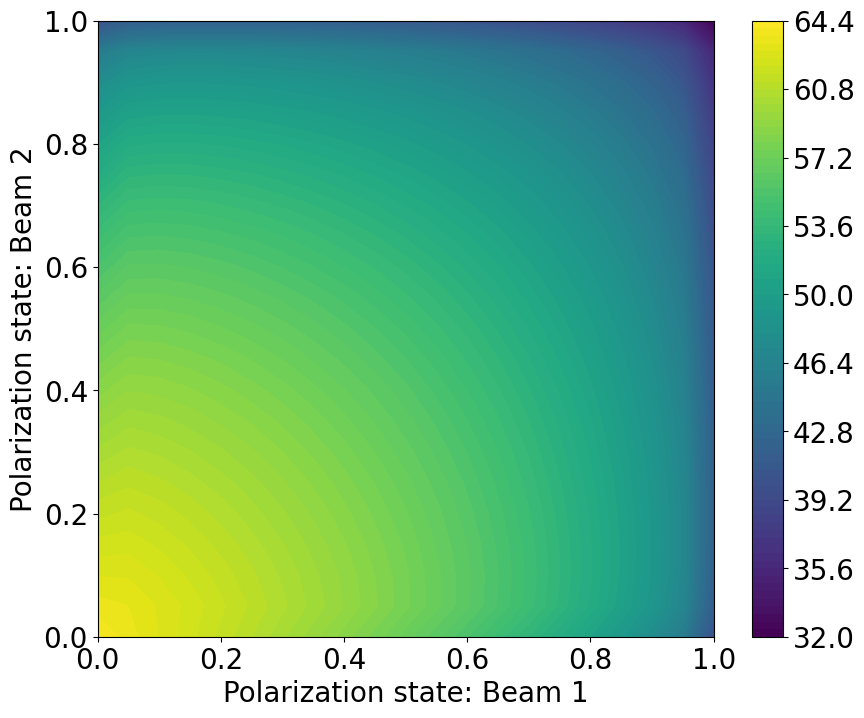

In [ ]:
#@title Contour Plotting
plt.rcParams.update({'font.size': 20})
effctpol4b55vv = [[59.356686142692375, 61.55990032428677, 62.14830675404821, 62.45804103635522, 62.61476248569312, 62.666087148123005, 62.63538499328071, 62.53544496046788, 62.37340511602583, 62.15285093320203, 61.87478339966573, 61.53797119523019, 61.13893550889982, 60.6715288727697, 60.12601538386736, 59.48722276864504, 58.73079365084571, 57.814649471729275, 56.65554461178905, 55.036970657354225, 50.67216244499989], [61.559900734827764, 64.20292410218671, 64.97691546085011, 65.43054558349127, 65.70967523762006, 65.86975570670845, 65.93818779995031, 65.93016552057921, 65.85440606207477, 65.71560784143898, 65.51559732554901, 65.25378805790115, 64.9272295397409, 64.53022910805953, 64.05346887632362, 63.482197926119134, 62.792532565773186, 61.943021346936014, 60.85145261744026, 59.303730693477874, 55.037263476741074], [62.14830694764384, 64.97691563041921, 65.83128032968428, 66.34811397443188, 66.68165389993334, 66.89060786394761, 67.00405761483054, 67.03820803151068, 67.00244678960101, 66.90195464445715, 66.73892463507448, 66.51307016815512, 66.22169983624589, 65.85936344172293, 65.41699278936808, 64.88011752174316, 64.22521616986444, 63.41137544311145, 62.35735265031106, 60.8514527085872, 56.6558345371982], [62.45804143368511, 65.43054581116175, 66.3481138866223, 66.91501955886096, 67.29193109521235, 67.54005997622026, 67.68978232753243, 67.75808474175035, 67.7548791329224, 67.68572178029792, 67.5531007557438, 67.35697245982945, 67.09486188533486, 66.76153082500178, 66.34813268199728, 65.84046067453245, 65.21534343601124, 64.43240171159468, 63.41137556656372, 61.94302194609428, 57.81493584989681], [62.6147634341238, 65.7096755028201, 66.6816540669351, 67.29193124925699, 67.70660106713278, 67.98898736826757, 68.17056279438559, 68.26897728962395, 68.29458796941091, 68.25327768488756, 68.14778956243497, 67.97829517988762, 67.74251618147754, 67.43540858373596, 67.04833858682387, 66.56735601784378, 65.96963765078041, 65.21534338887514, 64.22521608632088, 62.79253257712901, 58.73107676268721], [62.66608766640977, 65.86975599885913, 66.89060791857403, 67.54006004392912, 67.98898737682632, 68.30257885822478, 68.51327564886923, 68.63931592748587, 68.69145455311761, 68.67586664506734, 68.59552684067692, 68.45080498313793, 68.23960704103293, 67.95707541879872, 67.59478266662333, 67.13903370508707, 66.56735610514033, 65.84046072220949, 64.88011788783193, 63.4821978653685, 59.487502446493465], [62.63538542706709, 65.93818774652624, 67.00405772694387, 67.68978267426378, 68.17056315481129, 68.51327556002722, 68.75124089229992, 68.90323167477158, 68.98036612777787, 68.98908939444466, 68.9325911270333, 68.81142742250208, 68.62368174351137, 68.36467615822829, 68.0261900066097, 67.59478274295782, 67.04833857962362, 66.34813251908281, 65.41699283816578, 64.05346906952475, 60.12629136623422], [62.535445711949436, 65.93016548747444, 67.03820786660641, 67.7580852122524, 68.26897734536949, 68.63931617643183, 68.9032317686964, 69.0799930725607, 69.18105671265312, 69.21311828595991, 69.17957209226995, 69.08115389649626, 68.9161173288475, 68.67996343137513, 68.3646766614505, 67.95707538249063, 67.435408819418, 66.76153090079244, 65.8593637391108, 64.53022908778611, 60.67180117823611], [62.37340527948053, 65.85440622970137, 67.00244705055752, 67.75487896792016, 68.29458778411143, 68.69145477383195, 68.98036604994297, 69.18105656864623, 69.30529915857382, 69.36002895134135, 69.34883644175801, 69.27262943310616, 69.12983028558547, 68.91611746276034, 68.62368184087771, 68.23960719826894, 67.74251607383997, 67.09486250045794, 66.22169991434133, 64.9272295210766, 61.13920376968125], [62.15285166925996, 65.71560805023438, 66.90195467899134, 67.68572210800406, 68.25327792544816, 68.6758667191532, 68.98908952915285, 69.21311791415853, 69.36002934436807, 69.43698654786914, 69.44776849104684, 69.39345389105212, 69.2726295004888, 69.08115408131206, 68.81142764012291, 68.45080492823232, 67.97829498294344, 67.3569724407603, 66.51307075196605, 65.25378855167028, 61.538235063971044], [61.874784058658996, 65.51559775758662, 66.73892512149861, 67.5531012270825, 68.14778988296095, 68.59552692698479, 68.93259085569439, 69.17957206840455, 69.34883627721065, 69.44776887165278, 69.48032578252969, 69.44776887165278, 69.34883627721065, 69.17957206840455, 68.93259085569439, 68.59552692698479, 68.14778988296095, 67.5531012270825, 66.73892512149861, 65.51559775758662, 61.87504375043558], [61.53797113156375, 65.25378855167028, 66.51307075196605, 67.3569724407603, 67.97829498294344, 68.45080492823232, 68.81142764012291, 69.08115408131206, 69.2726295004888, 69.39345389105212, 69.44776849104684, 69.43698654786914, 69.36002934436807, 69.21311791415853, 68.98908952915285, 68.6758667191532, 68.25327792544816, 67.68572210800406, 66.90195467899134, 65.71560805023438, 62.15310693078183], [61.13893575693072, 64.9272295210766, 66.22169991434133, 67.09486250045794, 67.74251607383997, 68.23960719826894, 68.62368184087771, 68.91611746276034, 69.12983028558547, 69.27262943310616, 69.34883644175801, 69.36002895134135, 69.30529915857382, 69.18105656864623, 68.98036604994297, 68.69145477383195, 68.29458778411143, 67.75487896792016, 67.00244705055752, 65.85440622970137, 62.373655780865974], [60.67152940145106, 64.53022908778611, 65.8593637391108, 66.76153090079244, 67.435408819418, 67.95707538249063, 68.3646766614505, 68.67996343137513, 68.9161173288475, 69.08115389649626, 69.17957209226995, 69.21311828595991, 69.18105671265312, 69.0799930725607, 68.9032317686964, 68.63931617643183, 68.26897734536949, 67.7580852122524, 67.03820786660641, 65.93016548747444, 62.53569123476418], [60.12601571525244, 64.05346906952475, 65.41699283816578, 66.34813251908281, 67.04833857962362, 67.59478274295782, 68.0261900066097, 68.36467615822829, 68.62368174351137, 68.81142742250208, 68.9325911270333, 68.98908939444466, 68.98036612777787, 68.90323167477158, 68.75124089229992, 68.51327556002722, 68.17056315481129, 67.68978267426378, 67.00405772694387, 65.93818774652624, 62.635625554178034], [59.48722310297233, 63.4821978653685, 64.88011788783193, 65.84046072220949, 66.56735610514033, 67.13903370508707, 67.59478266662333, 67.95707541879872, 68.23960704103293, 68.45080498313793, 68.59552684067692, 68.67586664506734, 68.69145455311761, 68.63931592748587, 68.51327564886923, 68.30257885822478, 67.98898737682632, 67.54006004392912, 66.89060791857403, 65.86975599885913, 62.66632190573683], [58.73079406724961, 62.79253257712901, 64.22521608632088, 65.21534338887514, 65.96963765078041, 66.56735601784378, 67.04833858682387, 67.43540858373596, 67.74251618147754, 67.97829517988762, 68.14778956243497, 68.25327768488756, 68.29458796941091, 68.26897728962395, 68.17056279438559, 67.98898736826757, 67.70660106713278, 67.29193124925699, 66.6816540669351, 65.7096755028201, 62.61499123159064], [57.814649821206, 61.94302194609428, 63.41137556656372, 64.43240171159468, 65.21534343601124, 65.84046067453245, 66.34813268199728, 66.76153082500178, 67.09486188533486, 67.35697245982945, 67.5531007557438, 67.68572178029792, 67.7548791329224, 67.75808474175035, 67.68978232753243, 67.54005997622026, 67.29193109521235, 66.91501955886096, 66.3481138866223, 65.43054581116175, 62.45826185526935], [56.655545265112764, 60.8514527085872, 62.35735265031106, 63.41137544311145, 64.22521616986444, 64.88011752174316, 65.41699278936808, 65.85936344172293, 66.22169983624589, 66.51307016815512, 66.73892463507448, 66.90195464445715, 67.00244678960101, 67.03820803151068, 67.00405761483054, 66.89060786394761, 66.68165389993334, 66.34811397443188, 65.83128032968428, 64.97691563041921, 62.148518626089036], [55.036970689376965, 59.303730693477874, 60.85145261744026, 61.943021346936014, 62.792532565773186, 63.482197926119134, 64.05346887632362, 64.53022910805953, 64.9272295397409, 65.25378805790115, 65.51559732554901, 65.71560784143898, 65.85440606207477, 65.93016552057921, 65.93818779995031, 65.86975570670845, 65.70967523762006, 65.43054558349127, 64.97691546085011, 64.20292410218671, 61.56010096398125], [50.67216242999816, 55.03726320315254, 56.65583404077663, 57.81493567215011, 58.73107627351792, 59.487502072719145, 60.12629100987946, 60.671800561233226, 61.13920357805554, 61.53823515274253, 61.87504306001299, 62.1531061600726, 62.37365564356416, 62.53569035543629, 62.635625103455304, 62.666321426421725, 62.61499023674282, 62.45826149351949, 62.14851841490634, 61.56010062384806, 59.35703184455118]]
effctpol4b11vv = [[69.48032782245292, 68.82282767525024, 68.14778866210168, 67.45372194087794, 66.73892144838814, 66.00141430024894, 65.23888517976133, 64.44859885966308, 63.62728770473633, 62.77098013985061, 61.87478262568177, 60.93253472600587, 59.93631524806582, 58.87562822221827, 57.73605785423466, 56.49684835860236, 55.12614540173683, 53.570328624324105, 51.724842521020385, 49.31975730364741, 43.513736712946745], [68.82282789596735, 68.60513672187552, 68.1156829030751, 67.56551122166202, 66.97311924187652, 66.34436836244592, 65.68097306400075, 64.98260430818704, 64.24757325999161, 63.473021917849294, 62.654881179374556, 61.78763696506117, 60.86389460426804, 59.873613473878706, 58.80279688616287, 57.631108647703364, 56.32716922850515, 54.83798608794525, 53.060035327425744, 50.72580191037477, 45.01812308341949], [68.14778898484528, 68.11568331471179, 67.70660218342562, 67.2196343416153, 66.68165252952072, 66.10177509608077, 65.48339800939517, 64.82720127384421, 64.13216916973523, 63.39592323627038, 62.61476340994857, 61.783473494789746, 60.894919640754765, 59.93930294047078, 58.90287512716432, 57.765582980389674, 56.49640773320234, 55.04289432595605, 53.30249013574431, 51.010079062484884, 45.37324866472842], [67.45372151219638, 67.56551149531253, 67.21963429221023, 66.78273824005122, 66.28812820892041, 65.74742520208186, 65.16532102746923, 64.54327715716994, 63.88079945567178, 63.17588880687336, 62.42513812747067, 61.62357446290084, 60.76428055718406, 59.83766860863141, 58.83021341410486, 57.72212439483572, 56.48273356395811, 55.06011902062485, 53.352710969908, 51.09784621163841, 45.528548303282264], [66.73892128015495, 66.97311896333372, 66.68165254131017, 66.28812850364166, 65.83127640804514, 65.32483105517431, 64.77457989439993, 64.18264734616807, 63.54898699693939, 62.871922925653976, 62.14830489386887, 61.37337517335415, 60.54041261237227, 59.64002443510091, 58.65889770422248, 57.57749827560899, 56.365505527736914, 54.97153914129909, 53.295030536851776, 51.07583551002486, 45.57316757604984], [66.00141410350378, 66.34436789622785, 66.1017748422689, 65.74742568778392, 65.32483130329412, 64.84959101723398, 64.32846090104931, 63.764154489614974, 63.157022039331714, 62.505680377309695, 61.8072106461464, 61.057053310451415, 60.248672213311906, 59.37285950864669, 58.41651004117976, 57.36034420532723, 56.1743928647436, 54.807824798438, 53.16110065646132, 50.976669279772814, 45.540761546185564], [65.23888506244526, 65.68097287787786, 65.4833975018388, 65.16532072807723, 64.77457962344401, 64.32846079674071, 63.834598651696474, 63.2962434916125, 62.71410676611138, 62.0870761956699, 61.41244759232761, 60.685848628296654, 59.90091994365535, 59.04863382655685, 58.11609034334215, 57.084266391133085, 55.92354790711938, 54.583669642574826, 52.96614853749511, 50.816113071052186, 45.447723400059445], [64.44859856873254, 64.98260379937524, 64.82720109769589, 64.54327695020534, 64.18264784651248, 63.76415413264252, 63.29624301760062, 62.782657900597016, 62.22445033934451, 61.62075856043068, 60.969082006138265, 60.26522869242861, 59.50300868735332, 58.67357444622138, 57.76423009855637, 56.75621213899193, 55.620271232161336, 54.30672125285665, 52.71817231445879, 50.6025265062188, 45.3028865374082], [63.627287317199496, 64.24757317644051, 64.132169076234, 63.880799632241306, 63.548987227698895, 63.157021880768674, 62.71410650795851, 62.22445018686907, 61.68942190469502, 61.108398444960365, 60.479075077843916, 59.797433300414184, 59.05745032566549, 58.2504568970985, 57.363964109538536, 56.379472718822484, 55.268107718754244, 53.98078136512665, 52.42123756206042, 50.34025597410097, 45.11101796768216], [62.77097983604815, 63.4730213088177, 63.39592283101231, 63.17588877982128, 62.871922786039725, 62.505680208109624, 62.08707592538798, 61.620758487522444, 61.108398070407354, 60.54960190427347, 59.942253843778126, 59.28250346724937, 58.564495733661104, 57.77973978934663, 56.91595649557719, 55.9549170144377, 54.86813294139071, 53.6071382807915, 52.076854254599795, 50.031061012908886, 44.874295968437096], [61.87478216323079, 62.65488093798035, 62.61476318589384, 62.42513772807477, 62.14830501973398, 61.80721046503237, 61.41244746125908, 60.9690816641132, 60.47907507748047, 59.94225389730416, 59.35668159241978, 58.71868826591794, 58.02257267097154, 57.2600278588576, 56.418989595715715, 55.481508906062786, 54.41949765741483, 53.18513648520391, 51.68457873490711, 49.67474004201718, 44.592974200144674], [60.93253377099227, 61.787636346408924, 61.783473099269045, 61.62357355982388, 61.37337448142297, 61.057052890471, 60.68584836937897, 60.26522870690451, 59.797432777069716, 59.282503297821876, 58.71868858124966, 58.10247099679883, 57.4283302681535, 56.68813867262974, 55.870052830909955, 54.956412950170865, 53.91955005357434, 52.71232187198309, 51.24217321438211, 49.26931516152294, 44.265602016412885], [59.936314757142426, 60.86389400912462, 60.89491886845222, 60.76428008014989, 60.540412288977585, 60.2486719910901, 59.90091953327399, 59.50300838489449, 59.05745010280599, 58.564495596000235, 58.02257252588522, 57.42833010706988, 56.77641647316868, 56.05889353184571, 55.26414655573857, 54.37481755368619, 53.36367671990826, 52.1842956155855, 50.74548180932028, 48.81092961988592, 43.88896759607487], [58.87562771238013, 59.87361309057984, 59.93930250690291, 59.83766824010648, 59.640024212473755, 59.37285941257567, 59.04863366267084, 58.67357415026636, 58.250456773079115, 57.77973969502046, 57.260027658083025, 56.688138413988554, 56.058893393849374, 55.36454949172984, 54.59373082908524, 53.72939859165069, 52.74478572153607, 51.59422130286534, 50.18796236325134, 48.29340866021076, 43.45772224574153], [57.73605733928938, 58.80279611864252, 58.90287464190514, 58.830213042528456, 58.65889741254831, 58.41650987118603, 58.11608974681419, 57.764229760201324, 57.36396417382162, 56.91595641679964, 56.41898951127291, 55.87005275156718, 55.26414623586381, 54.5937308916172, 53.847683138117596, 53.00930110194629, 52.05231419117143, 50.931861379336006, 49.559755249405086, 47.7073740976546, 42.96359978067437], [56.49684763384709, 57.63110815618339, 57.76558243510074, 57.722124046383406, 57.57749786197065, 57.36034407472446, 57.08426558399376, 56.7562117284525, 56.37947279312713, 55.954916783068086, 55.481508327077, 54.95641276567525, 54.37481738621774, 53.72939857116994, 53.00930121019978, 52.198187540499866, 51.27032203845528, 50.18172196460752, 48.84588836990079, 47.038525048604704, 42.39387888505737], [55.12614444157449, 56.32716859553051, 56.49640689926901, 56.48273284212595, 56.36550505304607, 56.174391959451, 55.9235474974074, 55.62027093020681, 55.26810754184851, 54.86813263047308, 54.41949700866705, 53.91955001347738, 53.36367667739197, 52.74478554036619, 52.052314061460606, 51.27032164293662, 50.3736613125408, 49.31931921575484, 48.02266030762744, 46.26417017160511, 41.72827371725566], [53.57032752508361, 54.837984985143365, 55.042893295845786, 55.060118434178726, 54.97153853475716, 54.807824313166655, 54.58366918073126, 54.306720855921085, 53.980780981990684, 53.60713720336408, 53.185135957027796, 52.71232158238025, 52.18429530841758, 51.59422078545512, 50.93186127118605, 50.181721727717985, 49.319319137778095, 48.302734822662714, 47.04944756206308, 45.3453683063549, 40.931872321776005], [51.72484148546965, 53.060034636131626, 53.302489331811984, 53.35271017639204, 53.295029536394445, 53.161099398838765, 52.96614774251561, 52.71817206502851, 52.421236772917545, 52.076853745949336, 51.684578203113354, 51.24217256880822, 50.74548164163934, 50.18796196582513, 49.55975492134989, 48.845888085219165, 48.02265991570348, 47.04944753248833, 45.84623259659903, 44.205356602336906, 39.93574753436315], [49.319756119664696, 50.72580084738879, 51.010078080974466, 51.09784541910955, 51.07583451732947, 50.97666807290444, 50.81611220242831, 50.60252570589612, 50.34025515141701, 50.03106035547889, 49.674739392715075, 49.26931443230172, 48.81092913223358, 48.293408295967325, 47.70737368978472, 47.038524462795344, 46.26417001796577, 45.345367997953886, 44.20535627312933, 42.644853510798285, 38.560818535252665], [43.51373530425219, 45.018121547342346, 45.373247377722606, 45.5285469476913, 45.573166160774285, 45.540760153018546, 45.44772209522041, 45.30288541281918, 45.11101698093667, 44.874294945575826, 44.59297318284412, 44.26560098845903, 43.888966851266055, 43.45772133349951, 42.963598696135605, 42.39387831336677, 41.7282731739352, 40.93187171435663, 39.93574712166487, 38.56081822568808, 34.91653684342876]]
H = effctpol4b11vv
fig = plt.figure(figsize=(10, 8))
H1 = H[::-1]
ax = fig.add_subplot(111)
x = np.linspace(0,1,21)
X,Y = np.meshgrid(x,x)
#ax.set_title('Efficiency contour plot')
plt.contourf(X,Y, np.divide(H,69.4803)*64, 100) #81*np.divide(H,82.69)
#plt.contourf(H)
# plt.xlim(0,1)
# plt.ylim(0,1)
plt.colorbar()
plt.xlabel("Polarization state: Beam 1")
plt.ylabel("Polarization state: Beam 2")
#plt.clim(34, 83.14)
ax.set_aspect('equal')

In [ ]:
#@title Visibility with PER
n = 501
m = 2
r1 = 0
r2 = 0
vmt = []
for i in range(m):
  vm = []
  #r2 = 0
  for i in tqdm(range(n),ncols=120):
    dr2 = np.random.uniform(0,0.1,1)
    v = np.sqrt(r1*(r2+dr2))+ np.sqrt((1-r1)*(1-(r2+dr2)))
    vm.append(v)
    r2 = r2 + 0.00099999999999999
  vmt.append(vm)
  #r1 = r1 + 0.0499999999
  r1 = r1 + 0.5
  r2 = 0.5

print(vmt)


100%|██████████████████████████████████████████████████████████████████████████████| 501/501 [00:00<00:00, 68307.59it/s]

[[array([0.95011307]), array([0.98714428]), array([0.96382091]), array([0.95745268]), array([0.96373938]), array([0.96579121]), array([0.98474164]), array([0.99275436]), array([0.95299944]), array([0.99546934]), array([0.96139384]), array([0.97720989]), array([0.95592225]), array([0.97012004]), array([0.98605917]), array([0.96754405]), array([0.94428522]), array([0.98611168]), array([0.97653358]), array([0.94353577]), array([0.94822868]), array([0.96317937]), array([0.95946611]), array([0.98171182]), array([0.9419397]), array([0.95598174]), array([0.96174932]), array([0.93922882]), array([0.96021235]), array([0.96450409]), array([0.97264266]), array([0.96636576]), array([0.93296478]), array([0.95793741]), array([0.93895292]), array([0.96623299]), array([0.93167059]), array([0.94353052]), array([0.97543598]), array([0.97844582]), array([0.95121466]), array([0.97136698]), array([0.93659238]), array([0.95196555]), array([0.96346186]), array([0.94592365]), array([0.96901399]), array([0.971

In [ ]:
plt.plot(vmt[1])

Text(0, 0.5, 'Visibility')

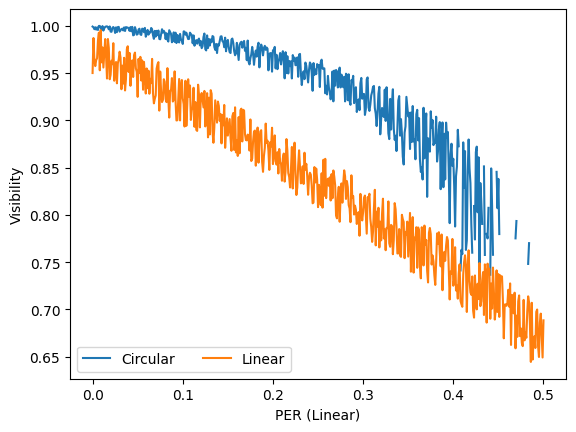

In [ ]:
vc=[[1.0, 0.9999874996094045, 0.9999499937488872, 0.9998874683448664, 0.9997998999167149, 0.9996872555396801, 0.9995494927927869, 0.9993865596915353, 0.9991983946051479, 0.998984926158071, 0.9987460731153641, 0.9984817442515632, 0.9981918382025267, 0.9978762432997137, 0.9975348373862727, 0.9971674876142358, 0.9967740502220435, 0.9963543702915304, 0.9959082814834184, 0.9954356057502549, 0.9949361530256404, 0.9944097208884591, 0.9938560942007164, 0.9932750447174397, 0.9926663306669559, 0.992029696299701, 0.9913648714035312, 0.9906715707833211, 0.9899494937024144, 0.9891983232832632, 0.9884177258643323, 0.9876073503100575, 0.9867668272703353, 0.9858957683856687, 0.9849937654337071, 0.9840603894124849, 0.9830951895551813, 0.9820976922706917, 0.9810674000036885, 0.9800037900071876, 0.9789063130198713, 0.9777743918395725, 0.9766074197833601, 0.9754047590235898, 0.9741657387880481, 0.9728896534109355, 0.9715757602198463, 0.9702232772421056, 0.9688313807117622, 0.9673992023561844, 0.9659258264384974, 0.964410286528995, 0.9628515619750628, 0.9612485740350036, 0.9596001816363272, 0.9579051767134654, 0.9561622790733162, 0.9543701307293495, 0.9525272896359878, 0.9506322227443293, 0.9486832982876845, 0.946678777190413, 0.944616803475669, 0.9424953935262259, 0.94031242402674, 0.9380656183845753, 0.9357525313883369, 0.933370531816835, 0.93091678265413, 0.9283882184957547, 0.9257815196434198, 0.9230930822755693, 0.9203189839424977, 0.9174549434585652, 0.9144962740384184, 0.9114378282326742, 0.9082739328386336, 0.9049983114615361, 0.9016039917366534, 0.8980831933274982, 0.8944271915962004, 0.8906261501588185, 0.8866689131800332, 0.8825427449040629, 0.8782329990528984, 0.8737226935320218, 0.8689919550219216, 0.8640172812204358, 0.8587705417462594, 0.8532175947791812, 0.8473163217094902, 0.8410137492417025, 0.8342416805592291, 0.8269097664485396, 0.8188939025796909, 0.8100154028475458, 0.8000000020571421, 0.7883859852139535, 0.7742730452087633, 0.7553368035823962, 0.7071291415087293]]
vl =[[1.0, 0.9974968671680127, 0.9949874371166704, 0.9924716620790742, 0.9899494936813695, 0.9874208829318935, 0.9848857802100709, 0.982344135255054, 0.9797958971540961, 0.9772410143306511, 0.9746794345321953, 0.9721111048177569, 0.969535971545151, 0.9669539803579071, 0.964365076171882, 0.9617692031615485, 0.9591663047459497, 0.95655632357431, 0.9539392015112913, 0.9513148796218841, 0.948683298155923, 0.9460443965322135, 0.9433981133222601, 0.9407443862335826, 0.9380831520926063, 0.9354143468271159, 0.9327379054482561, 0.9300537620320666, 0.9273618497005363, 0.9246621006021605, 0.9219544458919865, 0.9192388157111295, 0.9165151391657422, 0.9137833443054212, 0.9110433581010291, 0.9082951064219161, 0.9055385140125184, 0.9027735044683134, 0.900000000211111, 0.8972179224636565, 0.8944271912235225, 0.8916277252362669, 0.8888194419678273, 0.8860022575761305, 0.8831760868818855, 0.8803408433385332, 0.8774964390013215, 0.8746427844954761, 0.8717797889834334, 0.8689073601311016, 0.8660254040731137, 0.8631338253770384, 0.8602325270065064, 0.8573214102832145, 0.8544003748477641, 0.8514693186192911, 0.8485281377538401, 0.8455767266014361, 0.8426149776618024, 0.8396427815386731, 0.836660026892644, 0.833666600392507, 0.8306623866650035, 0.8276472682429393, 0.824621125511589, 0.8215838366533265, 0.818535277590404, 0.8154753219258079, 0.8124038408821069, 0.8093207032382156, 0.8062257752639764, 0.8031189206524771, 0.8000000004499999, 0.7968688729835041, 0.7937253937855332, 0.7905694155164363, 0.7874007878837814, 0.7842193575588401, 0.7810249680900091, 0.7778174598130334, 0.774596669757881, 0.7713624315521205, 0.7681145753206352, 0.7648529275815056, 0.7615773111378776, 0.7582875449656283, 0.7549834440966237, 0.7516648194973606, 0.7483314779427628, 0.7449832218848957, 0.741619849316346, 0.7382411536279997, 0.7348469234609339, 0.7314369425521244, 0.7280109895736463, 0.724568837965034, 0.7211102557584379, 0.7176350053961971, 0.714142843540422, 0.7106335208741562, 0.7071067818936541]]
x = np.linspace(0,0.5,501)
plt.plot(x,vmt[1],label="Circular")
plt.plot(x,vmt[0],label="Linear")
plt.legend(loc=3, ncol=2)
plt.xlabel("PER (Linear)")
plt.ylabel("Visibility")

# plt.plot(vmt[2])
# plt.plot(vmt[3])
# plt.plot(vmt[4])
# plt.plot(vmt[5])


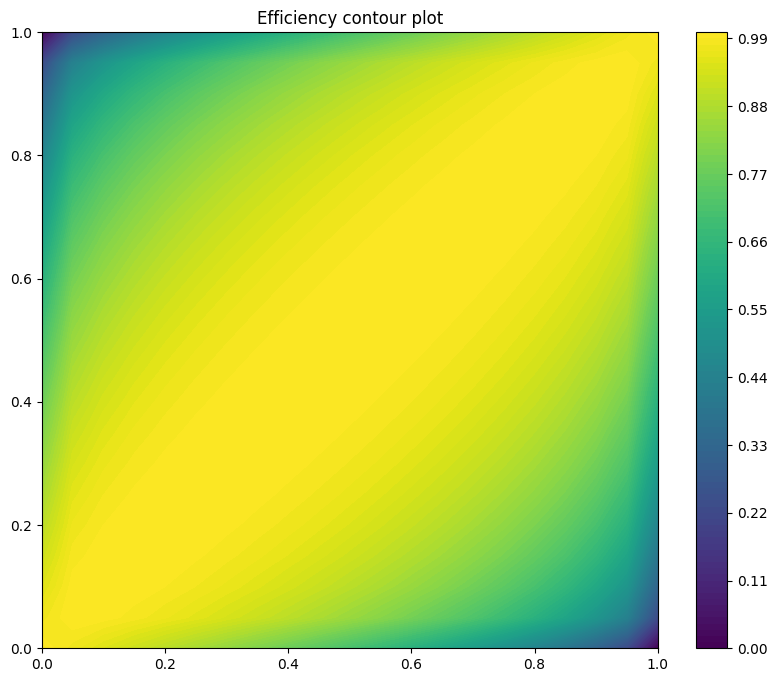

In [ ]:
#@title Contour Plotting
H = [[array([0.99557909]), array([0.95025208]), array([0.98638192]), array([0.95587674]), array([0.96582354]), array([0.99027894]), array([0.99374223]), array([0.95454624]), array([0.9748304]), array([0.97502926]), array([0.98129213]), array([0.98477813]), array([0.96394279]), array([0.95244299]), array([0.98790153]), array([0.97615586]), array([0.98058178]), array([0.95912838]), array([0.97256101]), array([0.9964605]), array([0.97365142]), array([0.95199146]), array([0.96484129]), array([0.97046463]), array([0.94872017]), array([0.96903906]), array([0.99394659]), array([0.95221671]), array([0.97450753]), array([0.9667133]), array([0.95086436]), array([0.99907699]), array([0.97621454]), array([0.96003255]), array([0.99035156]), array([0.97358914]), array([0.99705713]), array([0.99040773]), array([0.98716789]), array([0.97361363]), array([0.98825247]), array([0.96494534]), array([0.96630066]), array([0.95508267]), array([0.97941474]), array([0.97260818]), array([0.9550847]), array([0.96453983]), array([0.98705616]), array([0.98362587])], [array([0.99531522]), array([0.99619379]), array([0.99645621]), array([0.99961083]), array([0.99375393]), array([0.99434319]), array([0.99840986]), array([0.99648828]), array([0.99345512]), array([0.99933416]), array([0.99377115]), array([0.99897149]), array([0.99699837]), array([0.99399247]), array([0.99994717]), array([0.99851068]), array([0.99862548]), array([0.99425348]), array([0.99461633]), array([0.99973861]), array([0.9938034]), array([0.99967607]), array([0.99537685]), array([0.9978643]), array([0.99594129]), array([0.99459457]), array([0.99619454]), array([0.99779638]), array([0.99942841]), array([0.99429391]), array([0.99922949]), array([0.99659667]), array([0.99828321]), array([0.99823487]), array([0.99854606]), array([0.99329543]), array([0.99656638]), array([0.99954889]), array([0.99931026]), array([0.99679866]), array([0.99627425]), array([0.99441795]), array([0.99862232]), array([0.99981718]), array([0.99993079]), array([0.99949965]), array([0.99790507]), array([0.99985432]), array([0.99634805]), array([0.99957961])], [array([0.99671039]), array([0.99981131]), array([0.9958636]), array([0.99882769]), array([0.99551173]), array([0.99681221]), array([0.99973218]), array([0.99624904]), array([0.9996553]), array([0.99721961]), array([0.99622075]), array([0.99996876]), array([0.99989955]), array([0.9995701]), array([0.99955418]), array([0.99645652]), array([0.99966053]), array([0.99996846]), array([0.99998347]), array([0.99939673]), array([0.99706386]), array([0.99767179]), array([0.99807412]), array([0.99915157]), array([0.99716501]), array([0.99865989]), array([0.99872352]), array([0.99784012]), array([0.99688082]), array([0.9993527]), array([0.9984275]), array([0.99585538]), array([0.99802569]), array([0.99978713]), array([0.99939557]), array([0.99928824]), array([0.99998625]), array([0.99845109]), array([0.99873141]), array([0.99752564]), array([0.99999693]), array([0.99999058]), array([0.99746176]), array([1.]), array([0.99979932]), array([0.99503763]), array([0.99998775]), array([0.99887247]), array([0.99685645]), array([0.99843508])], [array([0.99740225]), array([0.99874937]), array([0.99972578]), array([0.99668411]), array([0.99998048]), array([0.99955733]), array([0.99913397]), array([0.99585898]), array([0.99608319]), array([0.99570891]), array([0.99829158]), array([0.99859786]), array([0.99962466]), array([0.99917775]), array([0.9977327]), array([0.99516819]), array([0.99722499]), array([0.99999116]), array([0.99930595]), array([0.99894373]), array([0.99998124]), array([0.99991973]), array([0.99454374]), array([0.99762225]), array([0.99997263]), array([0.99899786]), array([0.99964619]), array([0.9955219]), array([0.9954969]), array([0.99648334]), array([0.99832654]), array([0.99911658]), array([0.99573873]), array([0.99999856]), array([0.99941608]), array([0.99997587]), array([0.99800696]), array([0.99948522]), array([0.99478075]), array([0.99975686]), array([0.99948757]), array([0.99832868]), array([0.99981239]), array([0.99483199]), array([0.99844984]), array([0.99844027]), array([0.99578652]), array([0.99994332]), array([0.99976666]), array([0.99972495])], [array([0.99484864]), array([0.9999927]), array([0.99951763]), array([0.99980424]), array([0.99486095]), array([0.99917254]), array([0.99992998]), array([0.99329722]), array([0.9998413]), array([0.99845977]), array([0.9943255]), array([0.99397561]), array([0.99516861]), array([0.99541737]), array([0.99971485]), array([0.99325917]), array([0.99828963]), array([0.9958025]), array([0.99999938]), array([0.99845832]), array([0.99970413]), array([0.99512846]), array([0.9930681]), array([0.99984967]), array([0.99260684]), array([0.99536908]), array([0.99643137]), array([0.99708999]), array([0.99707532]), array([0.99316083]), array([0.99635186]), array([0.99964225]), array([0.99706655]), array([0.99921502]), array([0.99227314]), array([0.99624053]), array([0.99990061]), array([0.99146646]), array([0.99915784]), array([0.99962323]), array([0.99059754]), array([0.99976311]), array([0.99183225]), array([0.99883666]), array([0.99515099]), array([0.99871227]), array([0.99988212]), array([0.9999998]), array([0.9999977]), array([0.99016115])], [array([1.03775149]), array([1.01015676]), array([1.04380028]), array([1.00026498]), array([1.01785611]), array([1.04503053]), array([1.00802294]), array([1.01679892]), array([1.01548247]), array([1.04812372]), array([1.03697604]), array([1.01674298]), array([1.01495563]), array([1.0396644]), array([1.01533385]), array([1.01566483]), array([1.02150116]), array([1.0071965]), array([1.0241833]), array([1.00251535]), array([1.00286409]), array([1.00882342]), array([1.00733563]), array([1.0063456]), array([1.00665471]), array([1.02748046]), array([1.03145577]), array([1.03350911]), array([1.020361]), array([1.02389688]), array([1.01188999]), array([1.03285284]), array([1.03391008]), array([1.01533253]), array([1.00495994]), array([1.01372445]), array([1.00852135]), array([1.00674355]), array([1.00108653]), array([1.01601131]), array([1.04704016]), array([1.01513039]), array([1.00829951]), array([1.04075342]), array([1.00694331]), array([1.00394171]), array([1.03368792]), array([1.00085231]), array([1.00210523]), array([1.03503401])]]
#vmt
fig = plt.figure(figsize=(10, 8))
H1 = H[::-1]
ax = fig.add_subplot(111)
x = np.linspace(0,1,21)
X,Y = np.meshgrid(x,x)
ax.set_title('Efficiency contour plot')
plt.contourf(X,Y, H, 100)
#plt.xlim(1,3)
#plt.ylim(1,3)
plt.colorbar()
plt.xlabel("Beam 1 PER")
plt.ylabel("Beam 2 PER")
#plt.clim(34, 83.14)
ax.set_aspect('equal')

In [ ]:
#@title Visibility
m = 21
n = 21
#phx1 = 0

#phx2 = 0
#phy1 = 0
vmt = []
dphx = 0#phx1-phx2

for j in range(m):
  vm = []
  #phy2 = 0
  dphy = 0 #phy1-phy2
  for i in range(n):

    v = np.abs((np.cos(dphx)+ np.cos(dphy))/2)
    vm.append(v)
    dphy = dphy + np.pi/21
  vmt.append(vm)
  dphx = dphx + np.pi/21

print(vmt)

#plt.contourf(dphx,dphy, v, 100)
#plt.colorbar()
# plt.xlabel("Millimeters")
# plt.ylabel("Millimeters")

[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.99860189859059, 0.99860189859059, 0.99860189859059, 0.99860189859059, 0.99860189859059, 0.99860189859059, 0.99860189859059, 0.99860189859059, 0.99860189859059, 0.99860189859059, 0.99860189859059, 0.99860189859059, 0.99860189859059, 0.99860189859059, 0.99860189859059, 0.99860189859059, 0.99860189859059, 0.99860189859059, 0.99860189859059, 0.99860189859059, 0.99860189859059], [0.9944154131125642, 0.9944154131125642, 0.9944154131125642, 0.9944154131125642, 0.9944154131125642, 0.9944154131125642, 0.9944154131125642, 0.9944154131125642, 0.9944154131125642, 0.9944154131125642, 0.9944154131125642, 0.9944154131125642, 0.9944154131125642, 0.9944154131125642, 0.9944154131125642, 0.9944154131125642, 0.9944154131125642, 0.9944154131125642, 0.9944154131125642, 0.9944154131125642, 0.9944154131125642], [0.9874639560909119, 0.9874639560909119, 0.9874639560909119, 0.9874639560909119, 0.9874639

In [ ]:
H = vmt
fig = plt.figure(figsize=(10, 8))
H1 = H[::-1]
ax = fig.add_subplot(111)
ax.set_title('Efficiency contour plot')
plt.imshow(H1,extent=(0,90,0,90))
plt.colorbar()
# plt.xlabel("Beam 1 waist (mm)")
# plt.ylabel("Beam 2 waist (mm)")
#plt.clim(34, 83.14)
ax.set_aspect('equal')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
E_0 = 1.0  # amplitude
omega = 1.0  # angular frequency
phi = np.pi / 4.0  # initial phase
theta = 0#np.pi /4  # phase angle between x and y components

# Define time range
t_min = 0.0
t_max = 2.0 * np.pi
num_points = 1000
t = np.linspace(t_min, t_max, num_points)

# Calculate electric field components
E_x = E_0 * np.cos(omega * t)
E_y = E_0 * np.sin(omega * t + theta)

# Calculate elliptical polarization
E = E_x + E_y * 1j
E_ellipse = np.real(E) * np.cos(theta) - np.imag(E) * np.sin(theta) + 1j * (np.real(E) * np.sin(theta) + np.imag(E) * np.cos(theta))

# Plot electric field components and elliptical polarization
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(t, E_x, label='E(x)')
axs[0].plot(t, E_y, label='E(y)')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Electric field (a.u.)')
axs[0].legend()
axs[1].plot(np.real(E_ellipse), np.imag(E_ellipse), label='Elliptical polarization')
axs[1].set_xlabel('Electric field along x-axis (a.u.)')
axs[1].set_ylabel('Electric field along y-axis (a.u.)')
axs[1].legend()
plt.show()
